# GNN CODE 

Installs:

In [1]:
#!pip install torch
#!pip install torch_scatter
#!pip install torch_sparse
#!pip install torch_geometric
#!pip install sklearn
#!pip install networkx
#!pip install metaknowledge
#!pip install matplotlib

Imports:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import InMemoryDataset, Data
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import StandardScaler
import metaknowledge as mk
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import linear_model

Data Import Functions:

In [3]:
def network_import(file_txt):
    #lists to hold outputs
    networks = []
    masks = []
    
    #creates core, non-core and mixed networks from .txt files
    RC = mk.RecordCollection(file_txt)
    network1 = RC.networkCitation(nodeType='full',coreOnly=True)
    network1 = nx.Graph(network1)
    network1 = network1.to_undirected()
    c1 = list(network1.nodes)
    
    network2 = RC.networkCitation(nodeType='full',coreOnly=False)
    network2 = nx.Graph(network2)
    network2 = network2.to_undirected()

    network3 = nx.compose(network1,network2)
    
    #creates sub-graphs from mixed network
    sub_graphs = (network3.subgraph(c).copy() for c in nx.connected_components(network3))
    
    #loops for nodes in each subgraph
    for idx,g in enumerate(sub_graphs,start=1):
        
        #creates initial variables for an index list and mask
        index=[]
        mask = torch.zeros(g.number_of_nodes(), dtype=torch.bool)
        
        #only uses if sub-graphs above a size of 1000 nodes
        if len(g.nodes())>1000:
            c2 = list(g.nodes)
            #print(c2)
            
            #loops for mixed nodes
            for i in range(0,len(c2)):
                
                #loops for all core nodes
                for nodes2 in c1:
                    
                    #records index of core node in mixed network
                    if c2[i]==nodes2:
                        index.append(i)
                        
            #creates mask using index of core nodes
            mask[index] = True
            #adds network and mask to list
            networks.append(g)
            masks.append(mask)
    #outputs list of networks and masks
    return networks, masks

def panda_import(file_csv):
    #reads file as dataframe, drops duplicates and resets index as needed
    panda = pd.read_csv(file_csv)
    panda.drop_duplicates()
    panda.reset_index()
    return panda

Data Setup Function:

In [4]:
scaler = StandardScaler()
def data_setup(G,df):
    
    #creates edge index from network
    adj = nx.to_scipy_sparse_matrix(G).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    
    #creates labels from dataframe
    labels = ((df['FR'].to_numpy()).astype(np.compat.long))
    
    #scales imported centralities of nodes
    df[['DC','EC','LC','BC','CC']] = scaler.fit_transform(df[['DC','EC','LC','BC','CC']])

    #reformats dataframe as numpy array
    embeddings = ((df[['DC','EC','LC','BC','CC']]).to_numpy().astype(np.float64))

    #returns variables
    return labels,edge_index,embeddings,G

Dataset Class:

In [5]:
#defines custom data class
class GNNDataset(InMemoryDataset):
    def __init__(self, Mask, transform=None):
        super(GNNDataset, self).__init__('.', transform, None, None)

        # edge index
        data = Data(edge_index=edge_index)
        
        # number of nodes
        data.num_nodes = G.number_of_nodes()
        
        # embedding data
        data.x = torch.from_numpy(embeddings.copy()).type(torch.float32)
        
        data.num_features  = np.size(embeddings, 1)
        
        # labels
        y = torch.from_numpy(labels.copy()).type(torch.long)
        data.y = y.clone().detach()
        
        # core node mask
        data['mask'] = Mask
        
        # class data
        data.num_classes = 2

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

Creating Dataset:

In [6]:
#imports dataset
JOPCS, JOPCS_Masks = network_import("JOPCS_t.txt")
AMM, AMM_Masks = network_import("AMM_t.txt")
IJEEEE, IJEEEE_Masks = network_import("IJEEEE_t.txt")
JMS, JMS_Masks = network_import("JMS_t.txt") 

#ensures imports correctly due to multiple subgraphs in one dataset
c=0
if len(list(JOPCS[0].nodes))!= 4883:
    c=1
while c==1:
    #print(c,len(list(JOPCS[0].nodes)),len(list(JOPCS[1].nodes)))
    temp1 = JOPCS.copy()
    JOPCS[0]=temp1[1]
    JOPCS[1]=temp1[0]
    
    temp2 = JOPCS_Masks.copy()
    JOPCS_Masks[0]=temp2[1]
    JOPCS_Masks[1]=temp2[0]
    
    if len(list(JOPCS[0].nodes)) == 4883:
        c=0

#creates and orders dataset variable
JOPCS1 = panda_import('JOPCS_Cent_1.csv')
JOPCS1.ND = JOPCS1.ND.astype("category")
JOPCS1.ND.cat.set_categories([' Filler1']+list(JOPCS[0].nodes), inplace=True)
#print(JOPCS1['ND']) 
JOPCS1 = JOPCS1.sort_values(["ND"], ignore_index=True)
#print(JOPCS1['ND'])
JOPCS1.reset_index()

#creates and orders dataset variable
JOPCS2 = panda_import('JOPCS_Cent_2.csv')
JOPCS2.ND = JOPCS2.ND.astype("category")
JOPCS2.ND.cat.set_categories([' Filler2']+list(JOPCS[1].nodes), inplace=True)
#print(JOPCS2['ND'])
JOPCS2 = JOPCS2.sort_values(["ND"], ignore_index=True)
#print(JOPCS2['ND'])
JOPCS2.reset_index()

#creates and orders dataset variable
AMM1 = panda_import('AMM_Cent_1.csv')
AMM1.ND = AMM1.ND.astype("category")
AMM1.ND.cat.set_categories([' Filler3']+list(AMM[0].nodes), inplace=True)
#print(AMM1['ND'])
AMM1 = AMM1.sort_values(["ND"], ignore_index=True)
#print(AMM1['ND'])
AMM1.reset_index()

#creates and orders dataset variable
IJEEEE1 = panda_import('IJEEEE_Cent_1.csv')
IJEEEE1.ND = IJEEEE1.ND.astype("category")
IJEEEE1.ND.cat.set_categories([' Filler4']+list(IJEEEE[0].nodes), inplace=True)
#print(IJEEEE1['ND'])
IJEEEE1 = IJEEEE1.sort_values(["ND"], ignore_index=True)
#print(IJEEEE1['ND'])
IJEEEE1.reset_index()

#creates and orders dataset variable
JMS1 = panda_import('JMS_Cent_1.csv')
JMS1.ND = JMS1.ND.astype("category")
JMS1.ND.cat.set_categories([' Filler5']+list(JMS[0].nodes), inplace=True)
#print(JMS1['ND'])
JMS1 = JMS1.sort_values(["ND"], ignore_index=True)
#print(JMS1['ND'])axis=0,ignore_index=Tru
JMS1.reset_index()

#merges masks
Mask = torch.cat((JOPCS_Masks[0],JOPCS_Masks[1],AMM_Masks[0],IJEEEE_Masks[0],JMS_Masks[0]))

#merges datasets
Node_Data = pd.concat([JOPCS1,JOPCS2,AMM1,IJEEEE1,JMS1],axis=0,ignore_index=True)

#merges networks
G = nx.disjoint_union(JOPCS[0],JOPCS[1])
G = nx.disjoint_union(G,AMM[0])
G = nx.disjoint_union(G,IJEEEE[0])
G = nx.disjoint_union(G,JMS[0])

#sets up data and creates custom dataset
labels,edge_index,embeddings,G = data_setup(G,Node_Data)
Dataset = GNNDataset(Mask)


Resampling Data:

In [7]:
#splits data into test and training
X_train, X_test, Y_train, Y_test = train_test_split(pd.Series(list(G.nodes())), pd.Series(labels), test_size=0.30, random_state=42)

#oversamples cases of fraud
X = pd.concat([X_train, Y_train], axis=1)

#splits fraud and non-fraud index
not_fraud = X[X[1]==0]
fraud = X[X[1]==1]
n = 1500

#resamples index as needed
fraud_upsampled = resample(fraud,replace=True, n_samples= n , random_state=42) 

#merges indexes
X_up = pd.concat([not_fraud, fraud_upsampled])

#changes used variables to over sampled ones
X_train = X_up[0].copy()
Y_train = X_up[1].copy()

GNN Model Class Creation:

In [8]:
#defines model with five layers and both uses dropout and hyperbolic tangent normalisation
class GNNModel(nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(5, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = nn.Linear(2, 2)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = F.dropout(h, training=self.training)
        h = self.conv3(h, edge_index.long())
        h = h.tanh()
        out = self.classifier(h)
        return out, h

Training Model:

In [9]:
#sets seed
torch.manual_seed(42)

#uses GPU is possible
device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
model = GNNModel().to(device)

#sets criterion as Cross Entropy Loss and learning rate as 0.1
criterion = torch.nn.CrossEntropyLoss()
learn_rate=0.1

#sets optimiser as AdaDelta (stochastic gradient descent)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learn_rate, weight_decay=1e-4)

#defines a training function
def train(data,mask1):
    #resets gradient
    optimizer.zero_grad()
    
    #uses model to give outputs
    out, h = model(data[0].x, data[0].edge_index)
    
    #finds loss of model and its current outputs
    loss = criterion(out[torch.tensor(list(mask1))[torch.index_select(data[0]['mask'], 0, torch.tensor(list(mask1)))]],
        data[0].y[torch.tensor(list(mask1))[torch.index_select(data[0]['mask'], 0, torch.tensor(list(mask1)))]])
    
    #performs gradient descent
    loss.backward()
    optimizer.step()
    
    #returns loss
    return loss.item()

#sets up variables
embeddings = []
outs=[]
epochs = range(0, int((10000)/5))
count=0
counts=[]

losses_val = []
losses_train = []
losses_val_temp = []
losses_train_temp = []  
indx=[]

tps=[]
fps=[]
tns=[]
fns=[]
tprs=[]
tnrs=[]
accs=[]

#cross validation training split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#counting variable
y=0

#loops for 5*epochs
for epoch in epochs:
    
    #splits data and loops for all splits
    for train_index, test_index in sss.split(X_train,Y_train):
        
        #creates training and validation test indexes
        train_index = X_train.copy().iloc[train_index]
        test_index = X_train.copy().iloc[test_index]
        
        #fins loss using function
        loss = train(Dataset,train_index)
        count+=1
        
        #saves trainign and validation losses
        if (epoch%20)==0:
            #training loss
            losses_train_temp.append(loss)
            
            #validation loss
            out, h = model(Dataset[0].x,Dataset[0].edge_index)
            losses_val_temp.append(criterion(out[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]],Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]]).item())
            
            #averages and records losses
            if len(losses_train_temp) == 5:
                indx.append(count-1)
                losses_train.append(np.mean(losses_train_temp))
                losses_val.append(np.mean(losses_val_temp))
                losses_val_temp = []
                losses_train_temp = []            
        
        #saves a range of variables form validation data & prints it
        if (epoch%100)==0:
            out = (out[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]]).max(1)[1]
            h = (h[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])
            counts.append(count)
            outs.append(out)
            embeddings.append(h)
            
            #saves true positives, false positives, true negatives, false negatives and accuracy
            tp = (out[(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])==1]).sum().item()
            fp = (out[(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])==0]).sum().item()
            tn = (out[(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])==0]==0).sum().item()
            fn = (out[(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])==1]==0).sum().item()
            acc1 = out.eq(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]]).sum()
            acc2 = Dataset[0]['mask'][torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]].sum()
            acc =  acc1/acc2 
            
            #finds true positive/negative rates
            if tp!=0 or fn!=0:
                tpr = tp/(tp+fn)
            else:
                tpr = -0.0
                
            if tn!=0 or fp!=0:
                tnr = tn/(tn+fp)
            else:
                tnr = -0.0
            
            #appends variables to be exported
            accs.append(acc.item())
            tps.append(tp)
            fps.append(fp)
            tns.append(tn)
            fns.append(fn)
            tprs.append(tpr)
            tnrs.append(tnr)

            #prints to show progress
            print(f"Epoch: {count}",
                  f" Accuracy: {acc:2f}",
                  f" FP: {fn}",
                  f" TP: {tp}",
                  f" TPR: {tpr:2f}",
                  f" TNR: {tnr:2f}")

Epoch: 1  Accuracy: 0.543641  FP: 58  TP: 124  TPR: 0.681319  TNR: 0.429224
Epoch: 2  Accuracy: 0.570312  FP: 52  TP: 126  TPR: 0.707865  TNR: 0.451456
Epoch: 3  Accuracy: 0.556136  FP: 63  TP: 110  TPR: 0.635838  TNR: 0.490476
Epoch: 4  Accuracy: 0.615960  FP: 48  TP: 134  TPR: 0.736264  TNR: 0.515982
Epoch: 5  Accuracy: 0.576923  FP: 69  TP: 114  TPR: 0.622951  TNR: 0.536232
Epoch: 501  Accuracy: 0.628429  FP: 117  TP: 65  TPR: 0.357143  TNR: 0.853881
Epoch: 502  Accuracy: 0.713542  FP: 81  TP: 97  TPR: 0.544944  TNR: 0.859223
Epoch: 503  Accuracy: 0.697128  FP: 89  TP: 84  TPR: 0.485549  TNR: 0.871429
Epoch: 504  Accuracy: 0.688279  FP: 92  TP: 90  TPR: 0.494505  TNR: 0.849315
Epoch: 505  Accuracy: 0.697436  FP: 92  TP: 91  TPR: 0.497268  TNR: 0.874396
Epoch: 1001  Accuracy: 0.695761  FP: 79  TP: 103  TPR: 0.565934  TNR: 0.803653
Epoch: 1002  Accuracy: 0.752604  FP: 60  TP: 118  TPR: 0.662921  TNR: 0.830097
Epoch: 1003  Accuracy: 0.746736  FP: 66  TP: 107  TPR: 0.618497  TNR: 0.8523

Loss Plot:

10000


[]

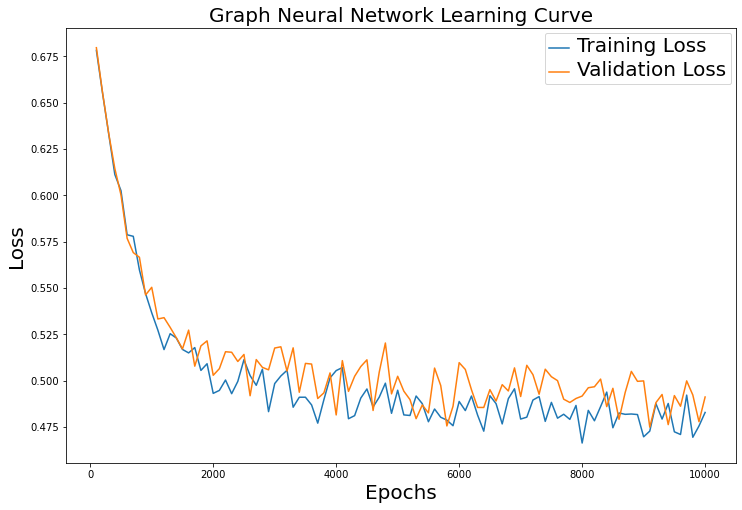

In [10]:
#sets up variables
lv=[]
lt=[]
indx=[]
print(count)

#reduces the data to only 100 entries
for i in range(0,len(losses_val),int(len(losses_val)/100)):
    #print(i)
    lv.append(losses_val[i])
    lt.append(losses_train[i])
    indx.append((i+1)*100)

#plots reduced data
plt.figure(figsize=(12,8))
plt.plot(indx,lt)
plt.plot(indx,lv)
legend = plt.legend(['Training Loss','Validation Loss'])
plt.setp(legend.get_title(),fontsize=20)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.yticks([0.675,0.650,0.625,.600,.575,.550,.525,.500,.475,.450])
plt.title('Graph Neural Network Learning Curve', fontsize=20)
plt.plot()

Data Export:

In [11]:
#creates dataframe
df=pd.DataFrame()

#sets up columns
df['Epoch']=counts
df['Accuracy']=accs
df['TP']=tps 
df['TN']=tns 
df['FP']=fps 
df['FN']=fns
df['TPR']=tprs
df['TNR']=tnrs

#saves to file
df.to_csv('Full_Training_Results_Rev.csv',index=False)

#creates an index list
index=[]
for i in range(4,0,-1):
    try:
        index.append(20-i)
    except:
        pass
    try:
        index.append(40-i)
    except:
        pass
    try:
        index.append(60-i)
    except:
        pass
    try:
        index.append(80-i)
    except:
        pass
    try:
        index.append(100-i)
    except:
        pass

#saves to file with reduced index
df.iloc[index].to_csv('Non_Full_Training_Results_Rev.csv',index=False)

Plot Function:

In [12]:
#defines plot function
def plot_embedding(j, h, color, leg, size=100):
    #sets up variables and figure
    h = h.detach().numpy()
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111)
    
    
    i=0
    if len(leg)==2:
        color = color+2
        i=-2
    scatters=[]
    leg1=[]
    
    #checks to see what colours are used and therefore what colours to use in the labels
    if (color==0).sum()>0:
        scatter0 = ax.scatter(h[color==0][:, 0], h[color==0][:, 1], c='blue', s=size)
        scatters.append(scatter0)
        leg1.append(leg[i])
        
    i+=1
    if (color==1).sum()>0:
        scatter1 = ax.scatter(h[color==1][:, 0], h[color==1][:, 1], c='orange', s=size)
        scatters.append(scatter1)
        leg1.append(leg[i])
        
    i+=1
    if (color==2).sum()>0:
        scatter2 = ax.scatter(h[color==2][:, 0], h[color==2][:, 1], c='green', s=size)
        scatters.append(scatter2)
        leg1.append(leg[i])
        
    i+=1
    if (color==3).sum()>0:
        scatter3 = ax.scatter(h[color==3][:, 0], h[color==3][:, 1], c='red', s=size)
        scatters.append(scatter3)
        leg1.append(leg[i])
        
    legend = ax.legend(scatters,leg1, title="Classifications:", prop={'size': 16}, loc = 'upper right')
    plt.setp(legend.get_title(),fontsize=20)
    plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')
    
    #sets plot limits and ticks
    plt.xlim((-1.1,1.1))
    plt.ylim((-1.1,1.1))
    plt.xticks([-1,0,1],[0.0,0.5,1.0], fontsize=20)
    plt.yticks([-1,0,1],[0.0,0.5,1.0], fontsize=20)
    
    #sets axes labels
    plt.xlabel('First Embedding Output', fontsize=20)
    plt.ylabel('Second Embedding Output', fontsize=20)
    
    #sets font size
    if type(j)==str:
        plt.title(f"{j}", fontsize=24)
    else:
        plt.title(f"Epoch: {counts[j]}", fontsize=24)
    plt.show()

Validation Classification Plots:

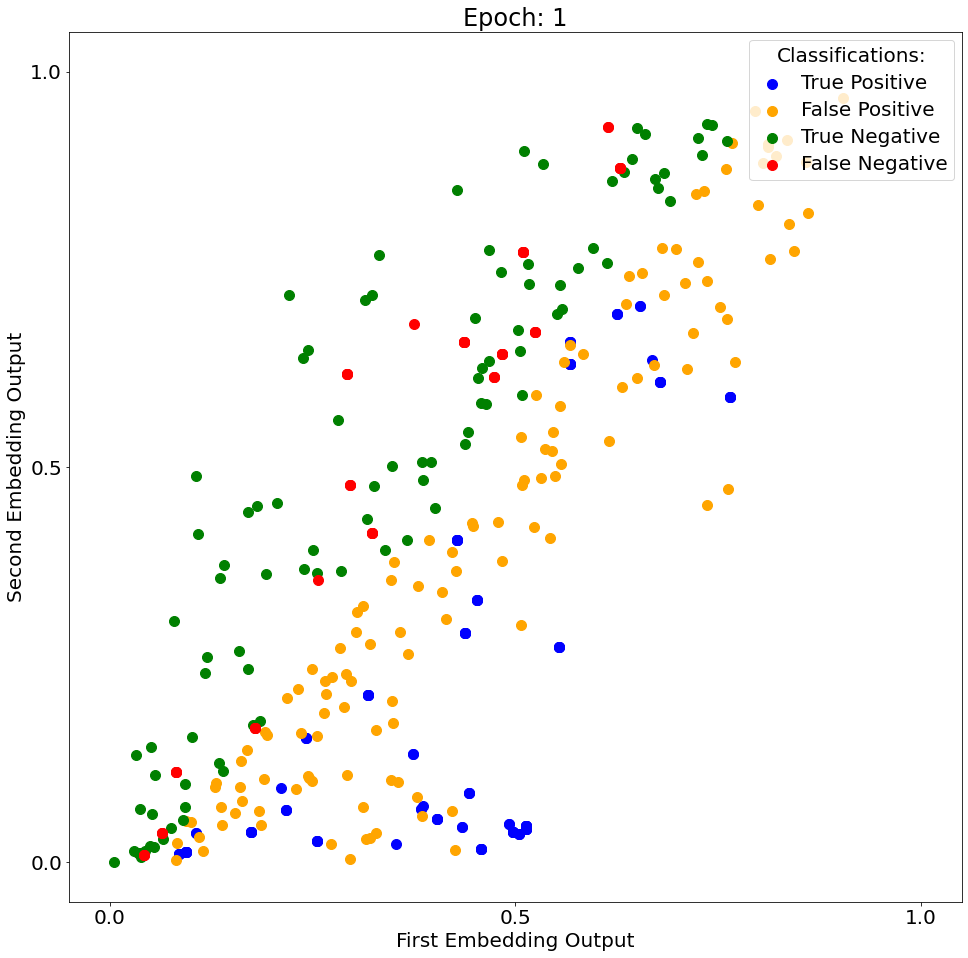

Epoch: 1  Accuracy: 0.543641  FP: 125  TP: 124  TPR: 0.681319  TNR: 0.429224


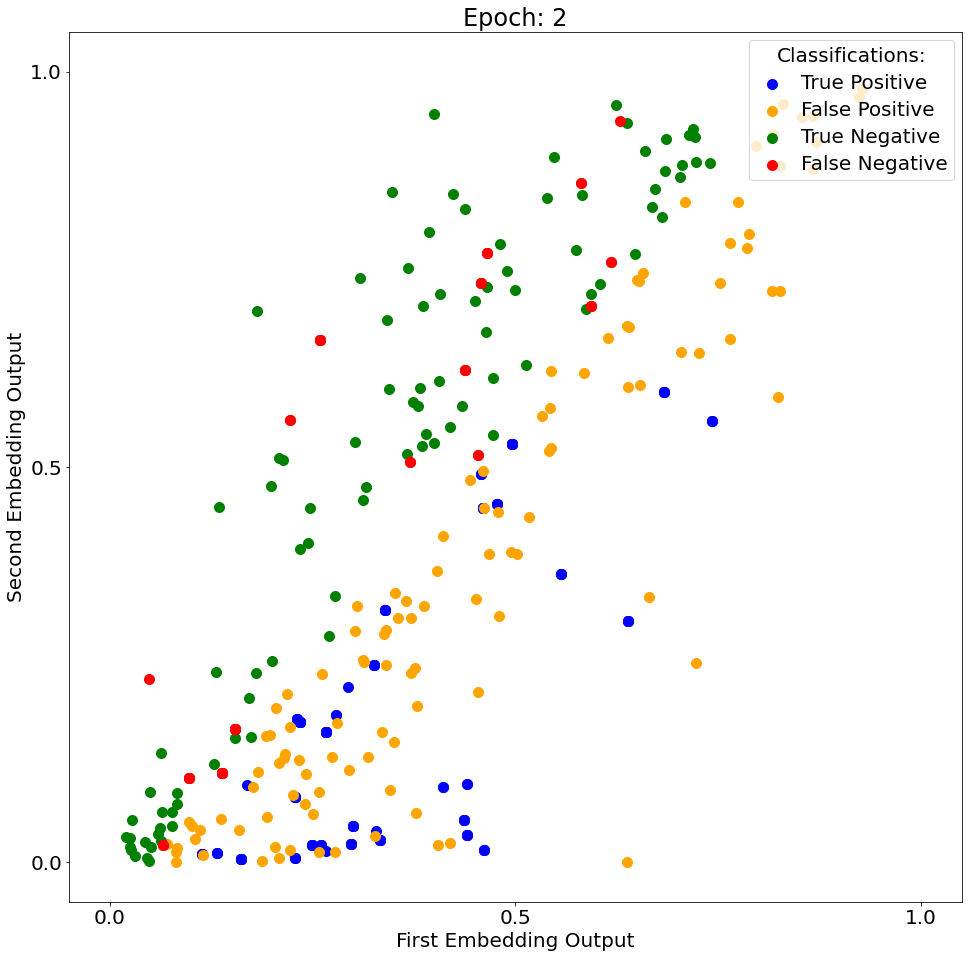

Epoch: 2  Accuracy: 0.570312  FP: 113  TP: 126  TPR: 0.707865  TNR: 0.451456


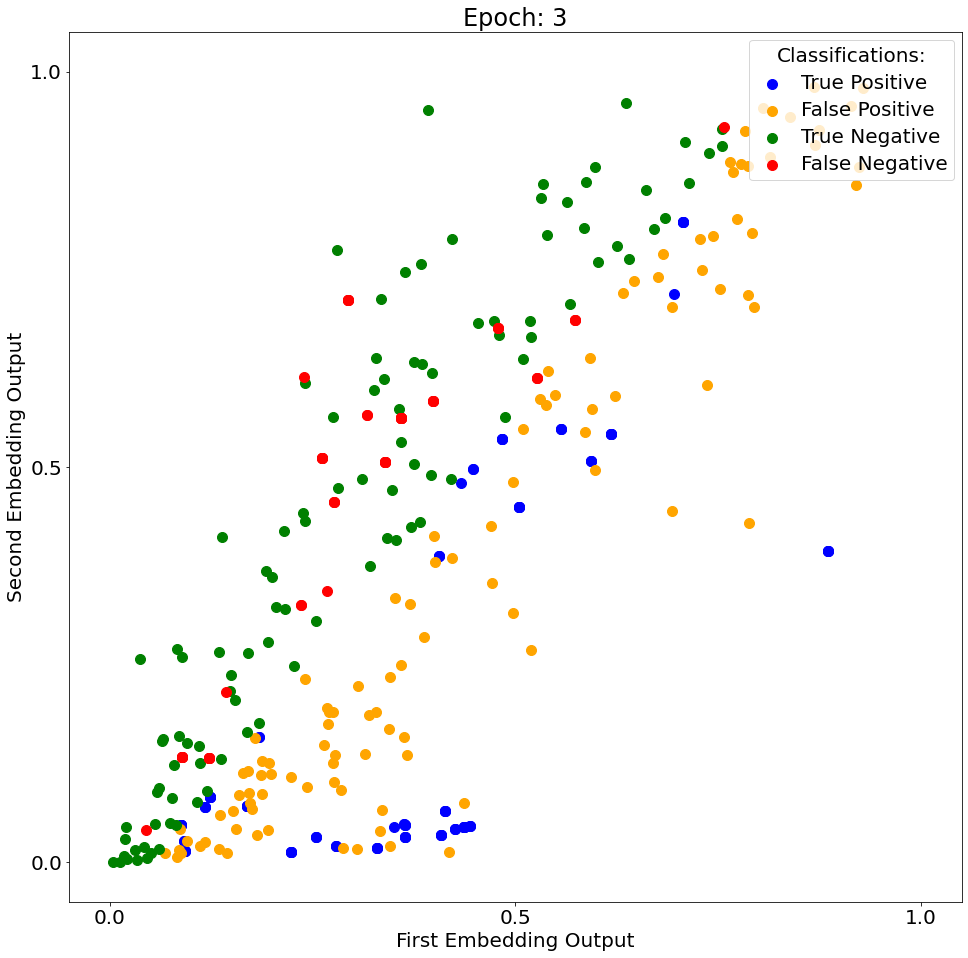

Epoch: 3  Accuracy: 0.556136  FP: 107  TP: 110  TPR: 0.635838  TNR: 0.490476


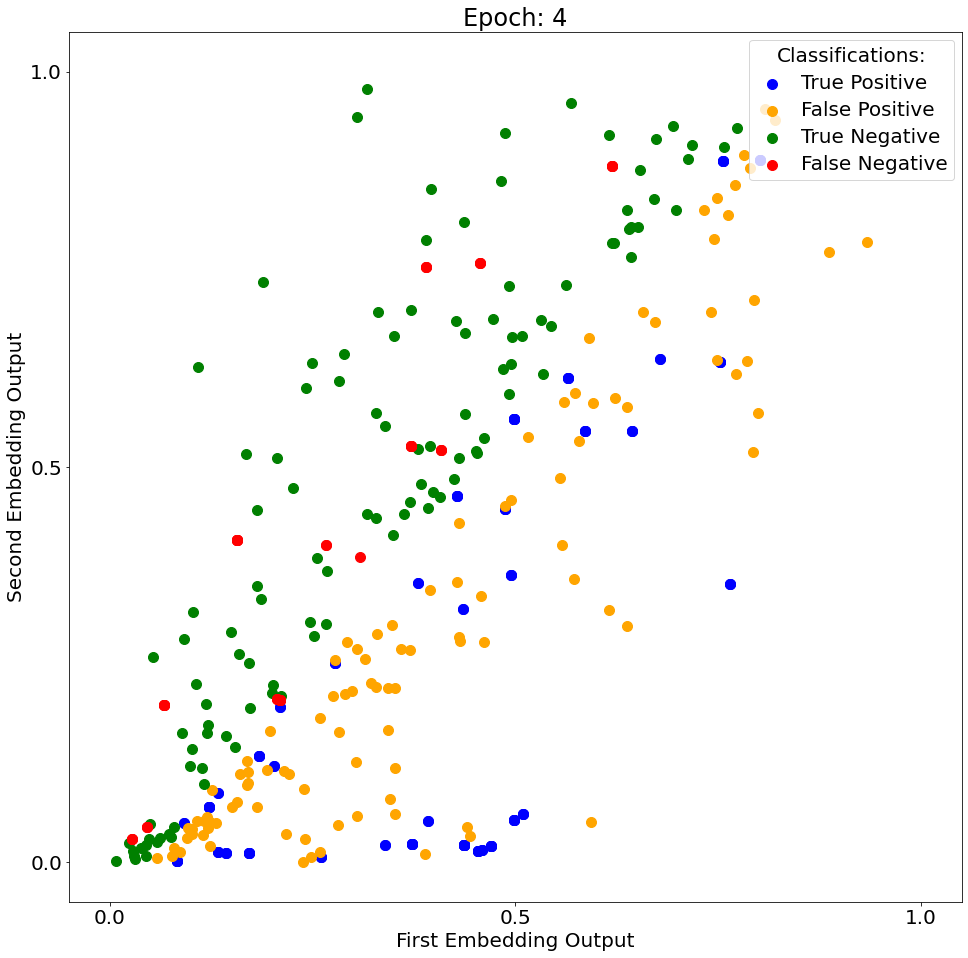

Epoch: 4  Accuracy: 0.615960  FP: 106  TP: 134  TPR: 0.736264  TNR: 0.515982


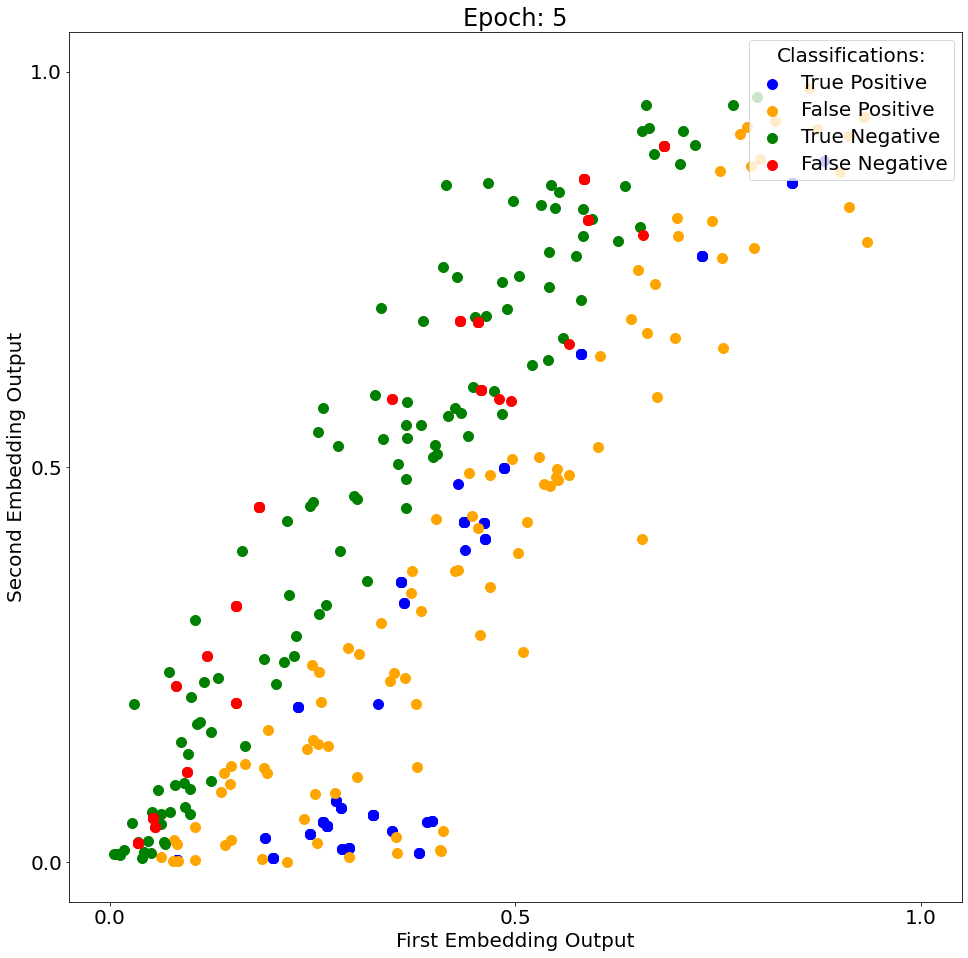

Epoch: 5  Accuracy: 0.576923  FP: 96  TP: 114  TPR: 0.622951  TNR: 0.536232


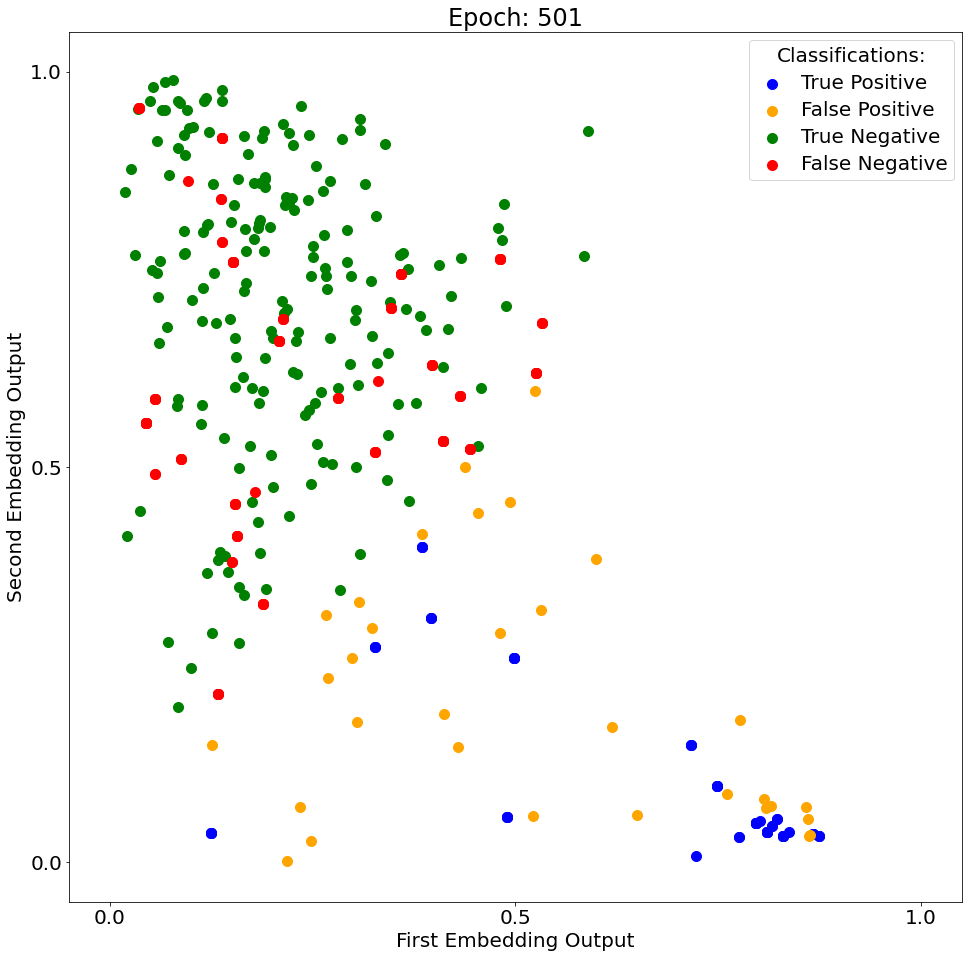

Epoch: 501  Accuracy: 0.628429  FP: 32  TP: 65  TPR: 0.357143  TNR: 0.853881


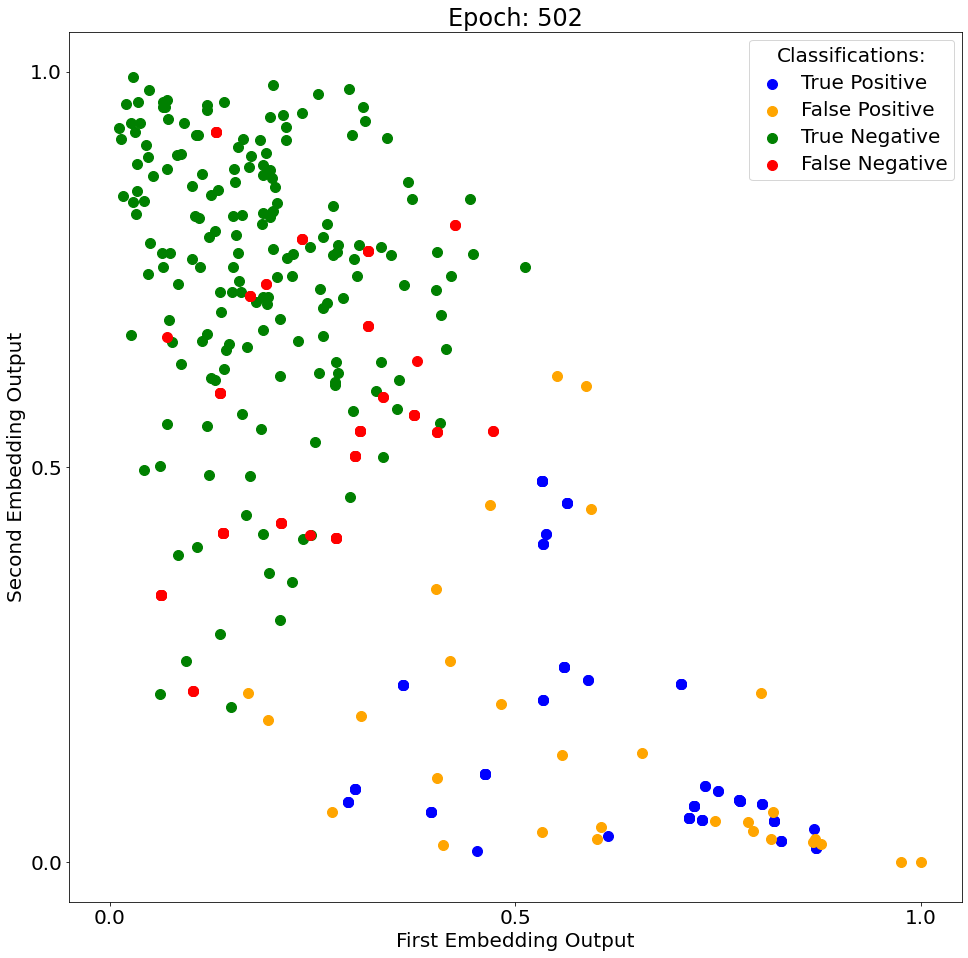

Epoch: 502  Accuracy: 0.713542  FP: 29  TP: 97  TPR: 0.544944  TNR: 0.859223


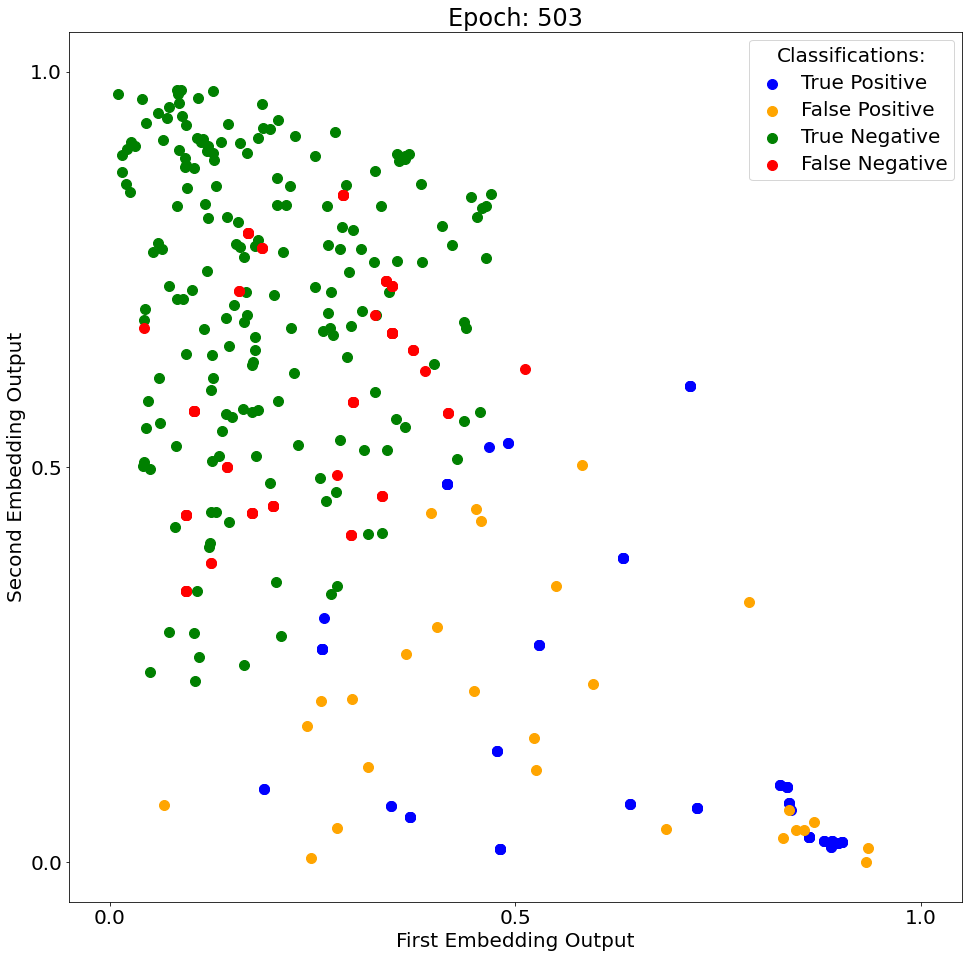

Epoch: 503  Accuracy: 0.697128  FP: 27  TP: 84  TPR: 0.485549  TNR: 0.871429


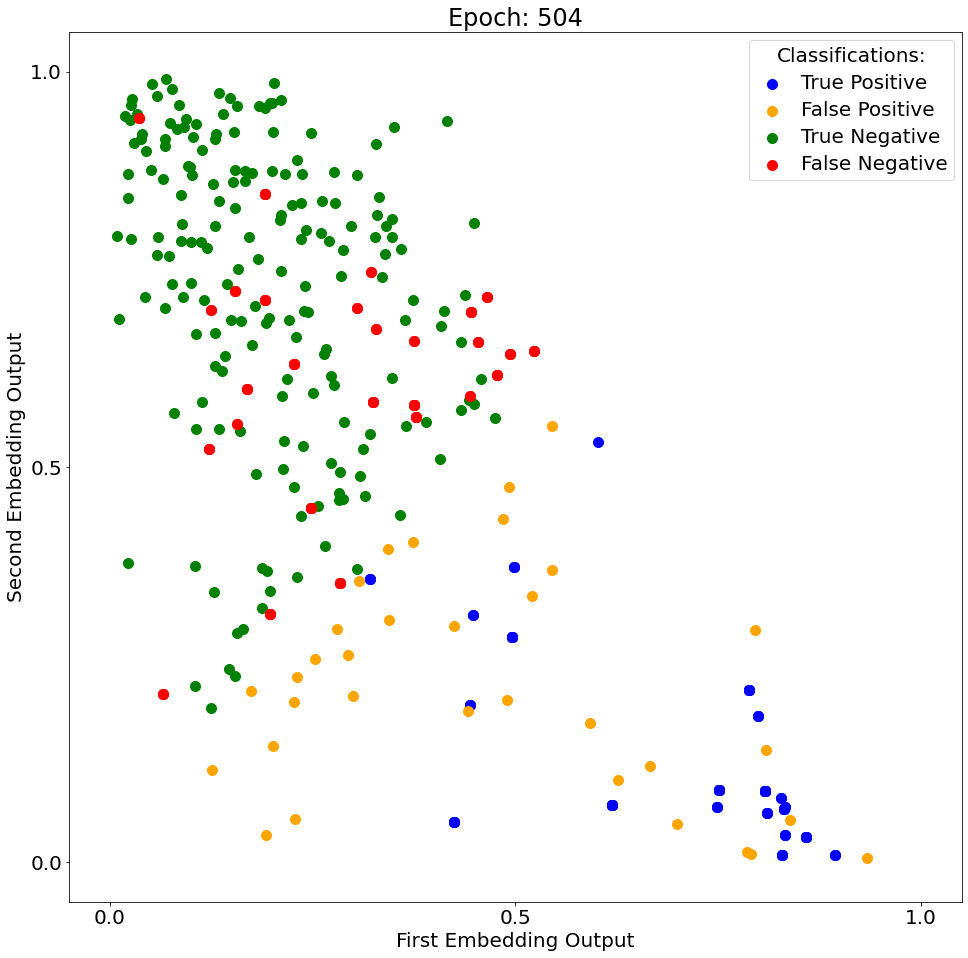

Epoch: 504  Accuracy: 0.688279  FP: 33  TP: 90  TPR: 0.494505  TNR: 0.849315


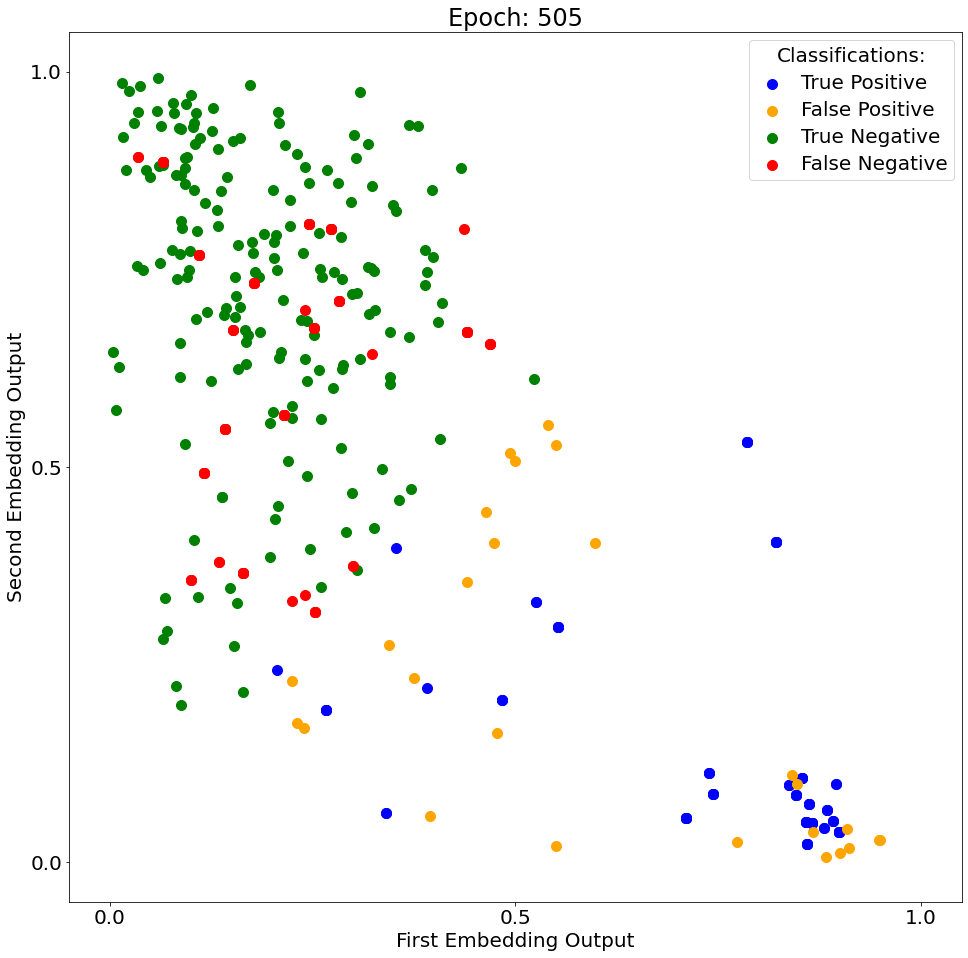

Epoch: 505  Accuracy: 0.697436  FP: 26  TP: 91  TPR: 0.497268  TNR: 0.874396


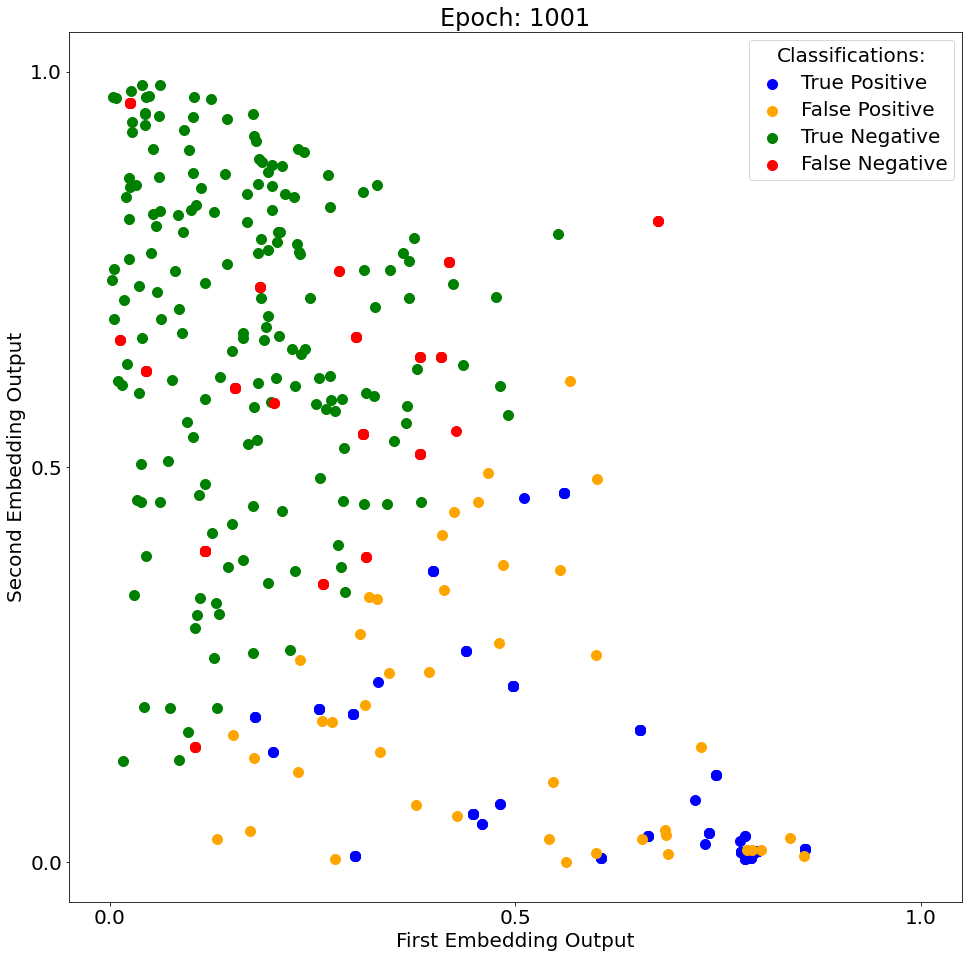

Epoch: 1001  Accuracy: 0.695761  FP: 43  TP: 103  TPR: 0.565934  TNR: 0.803653


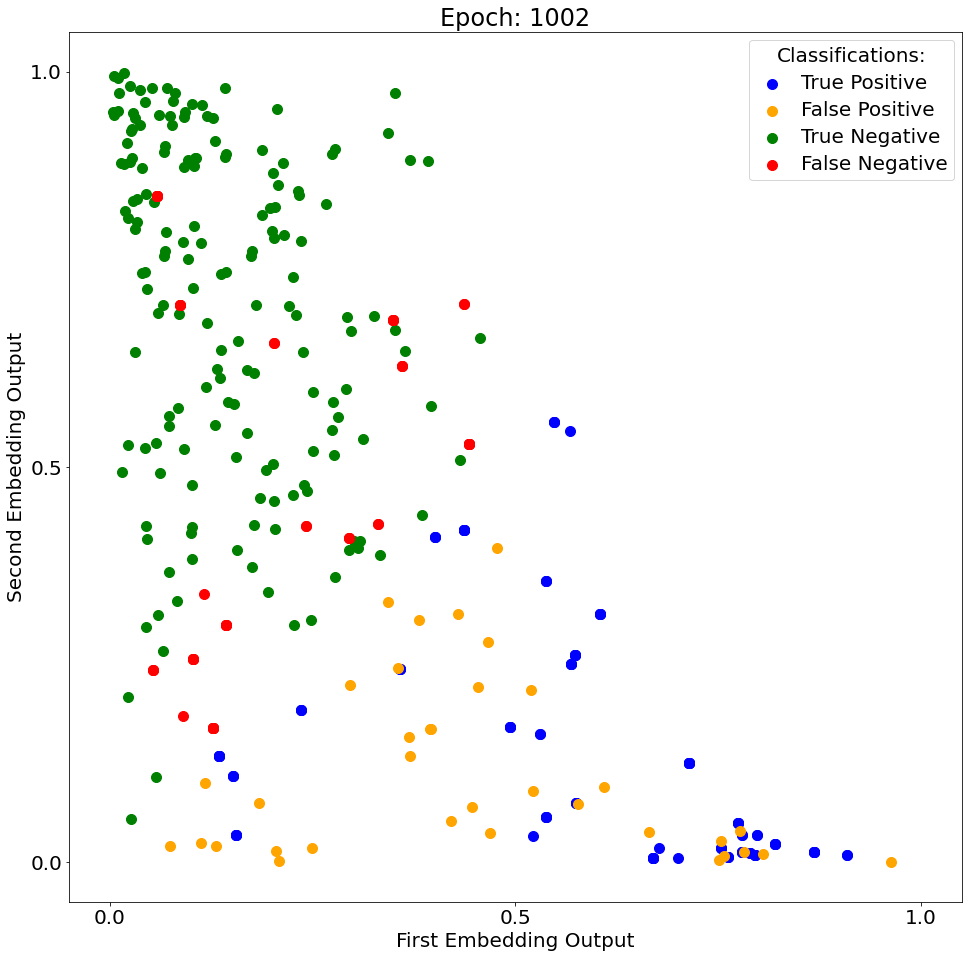

Epoch: 1002  Accuracy: 0.752604  FP: 35  TP: 118  TPR: 0.662921  TNR: 0.830097


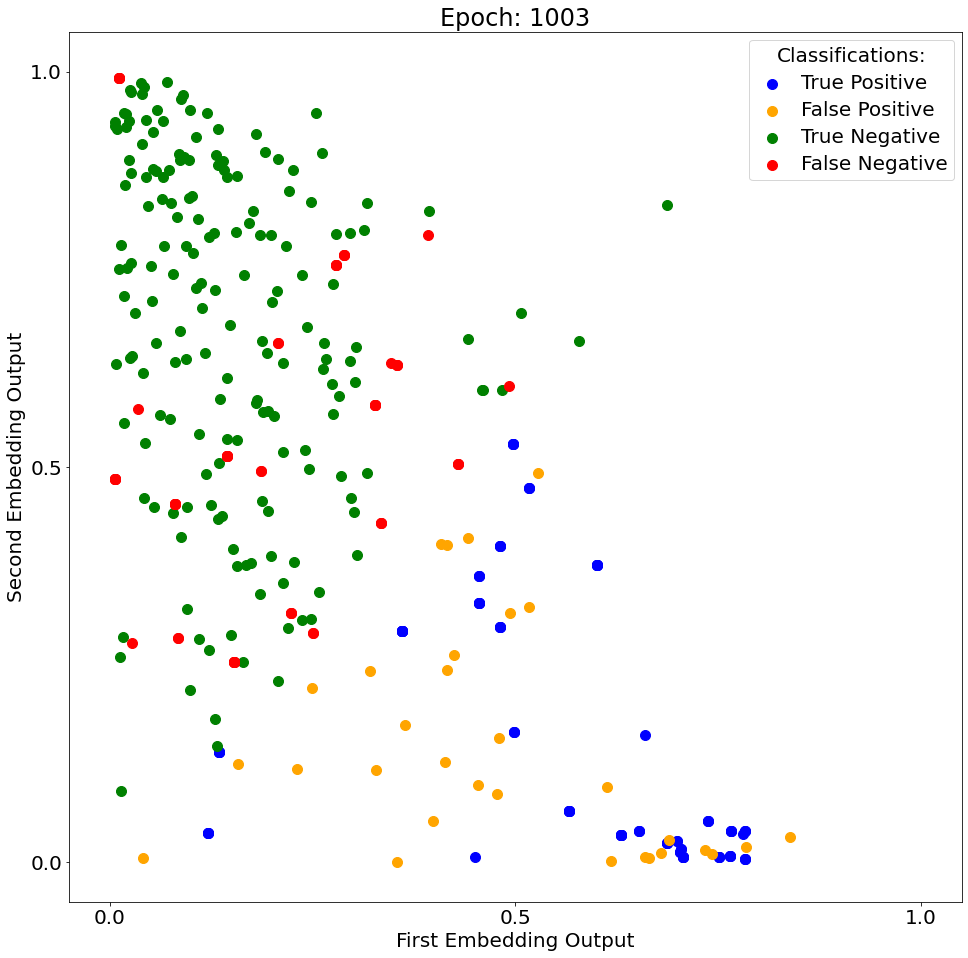

Epoch: 1003  Accuracy: 0.746736  FP: 31  TP: 107  TPR: 0.618497  TNR: 0.852381


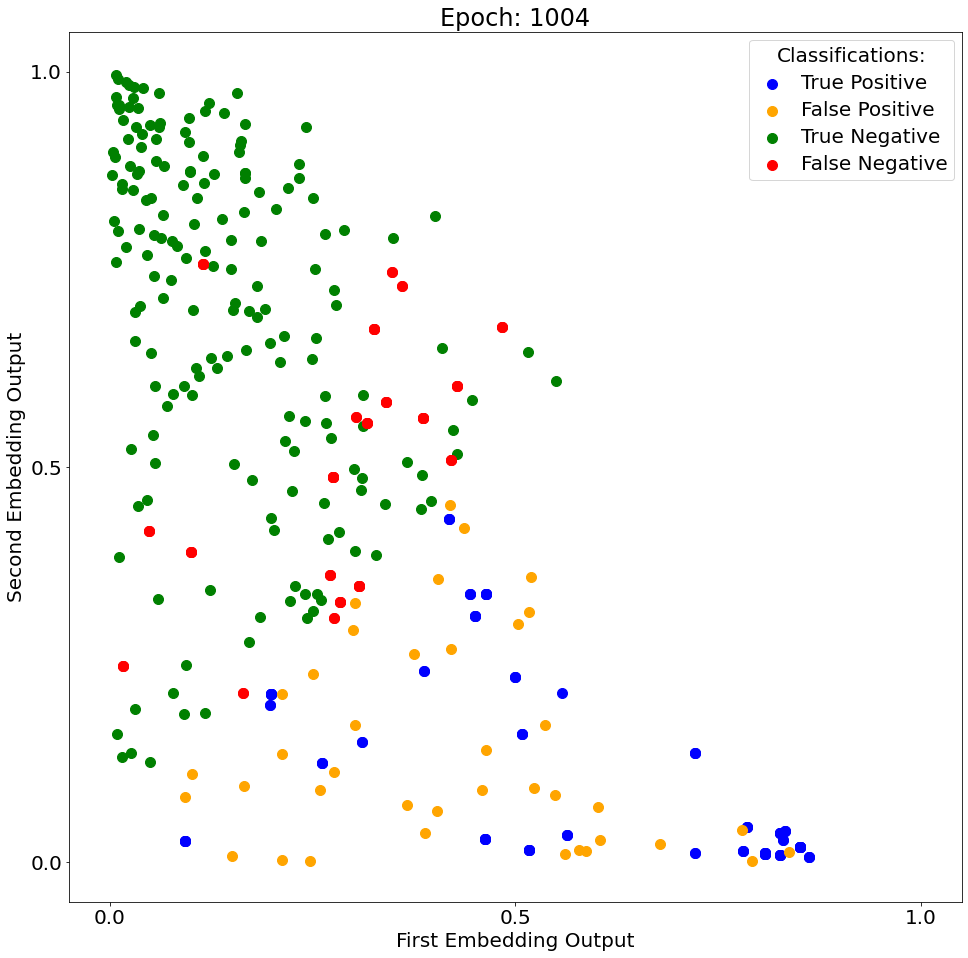

Epoch: 1004  Accuracy: 0.728180  FP: 39  TP: 112  TPR: 0.615385  TNR: 0.821918


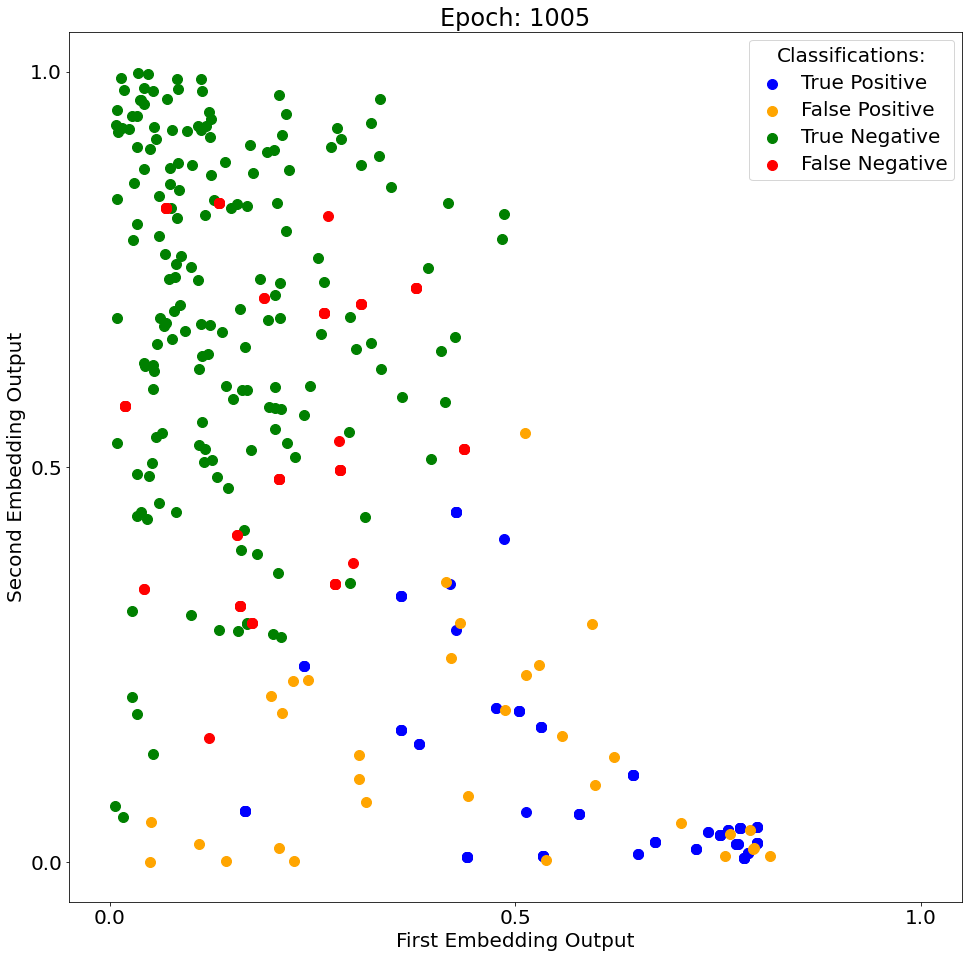

Epoch: 1005  Accuracy: 0.728205  FP: 33  TP: 110  TPR: 0.601093  TNR: 0.840580


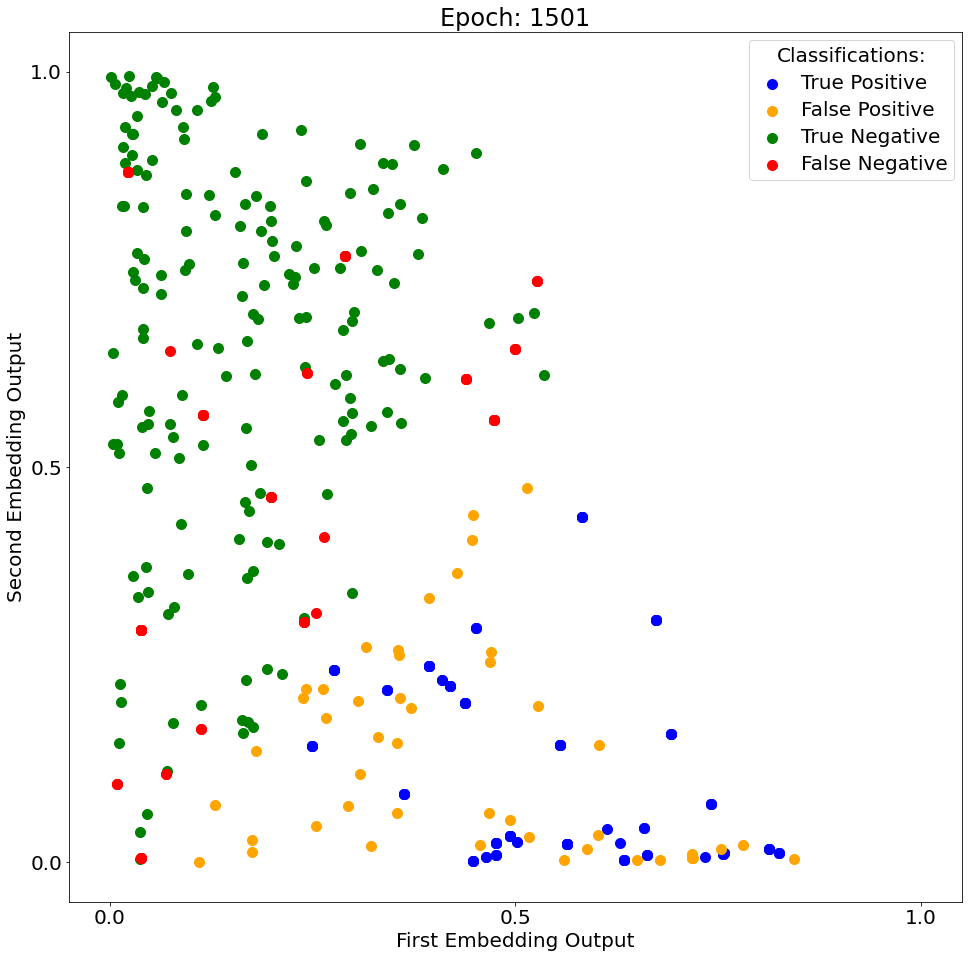

Epoch: 1501  Accuracy: 0.720698  FP: 47  TP: 117  TPR: 0.642857  TNR: 0.785388


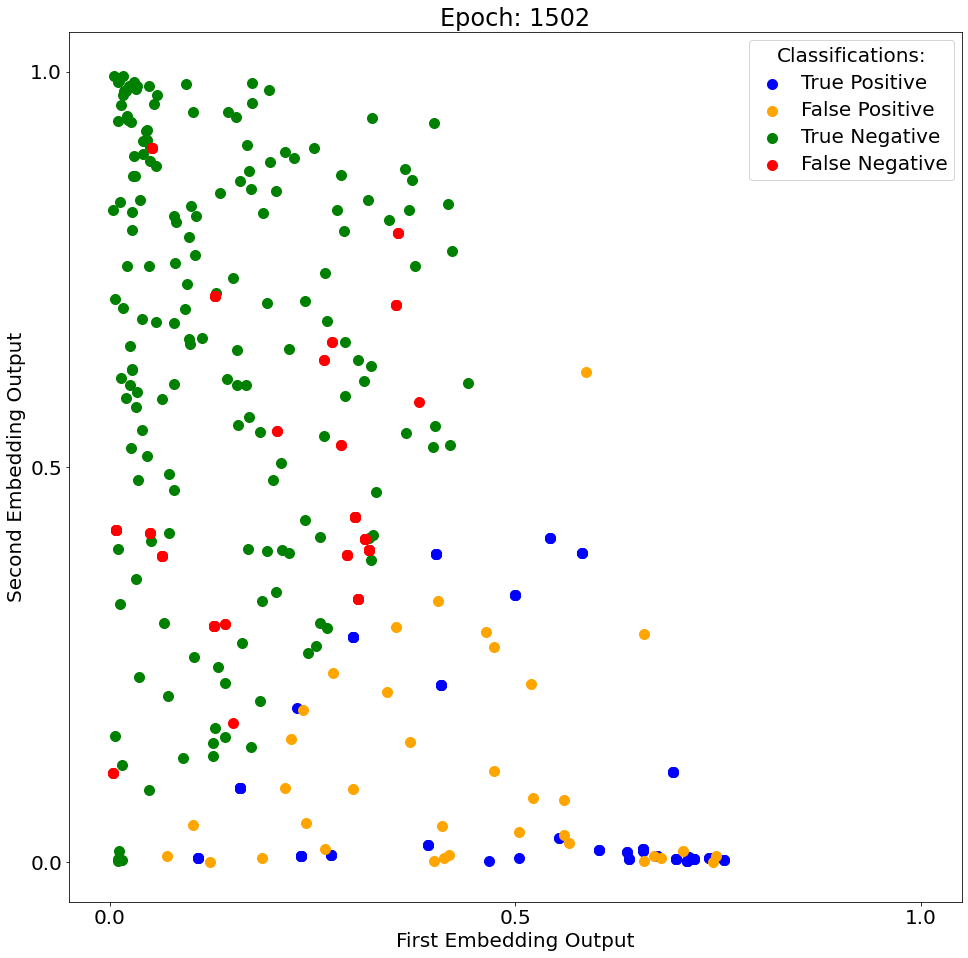

Epoch: 1502  Accuracy: 0.697917  FP: 36  TP: 98  TPR: 0.550562  TNR: 0.825243


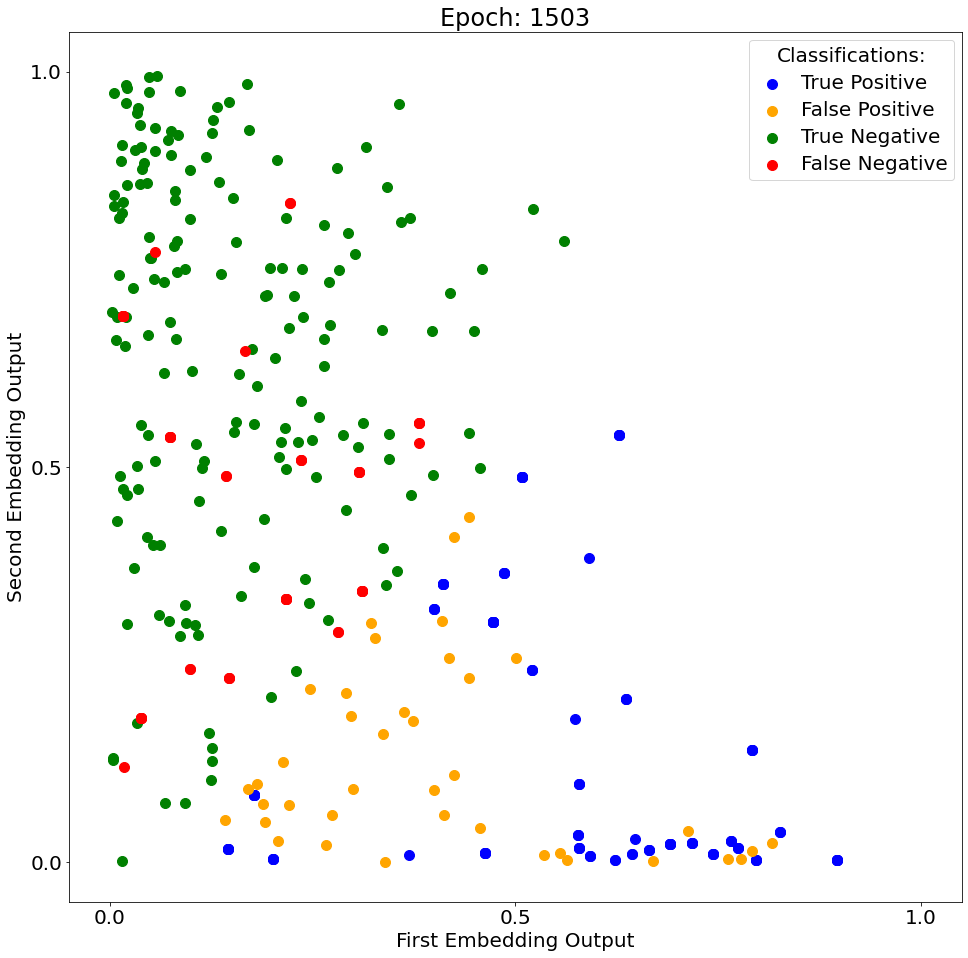

Epoch: 1503  Accuracy: 0.759791  FP: 39  TP: 120  TPR: 0.693642  TNR: 0.814286


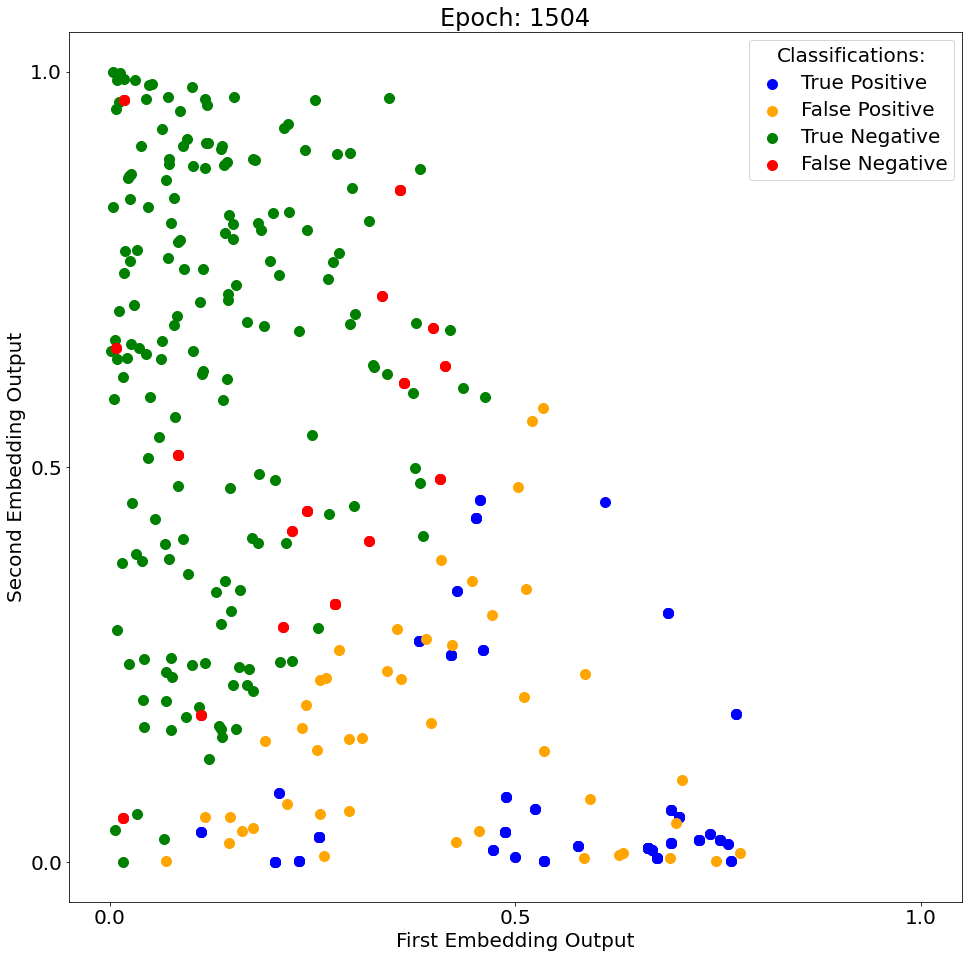

Epoch: 1504  Accuracy: 0.758105  FP: 46  TP: 131  TPR: 0.719780  TNR: 0.789954


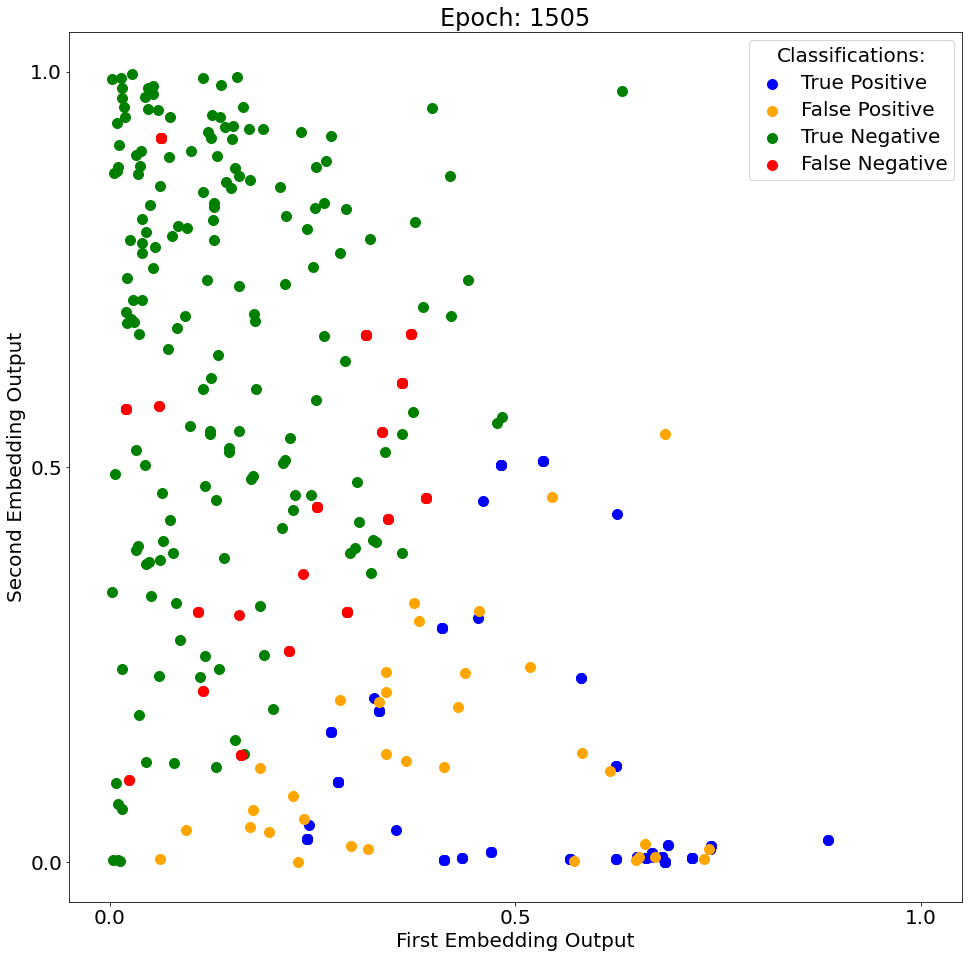

Epoch: 1505  Accuracy: 0.728205  FP: 35  TP: 112  TPR: 0.612022  TNR: 0.830918


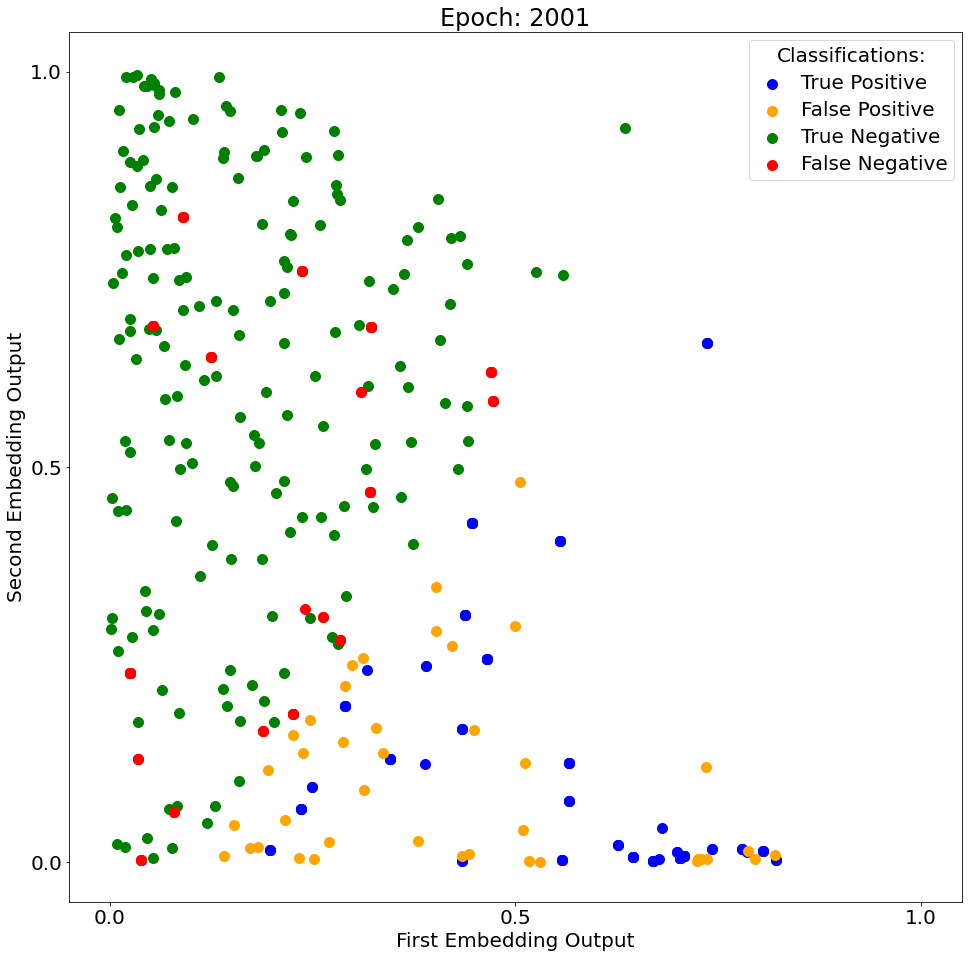

Epoch: 2001  Accuracy: 0.710723  FP: 41  TP: 107  TPR: 0.587912  TNR: 0.812785


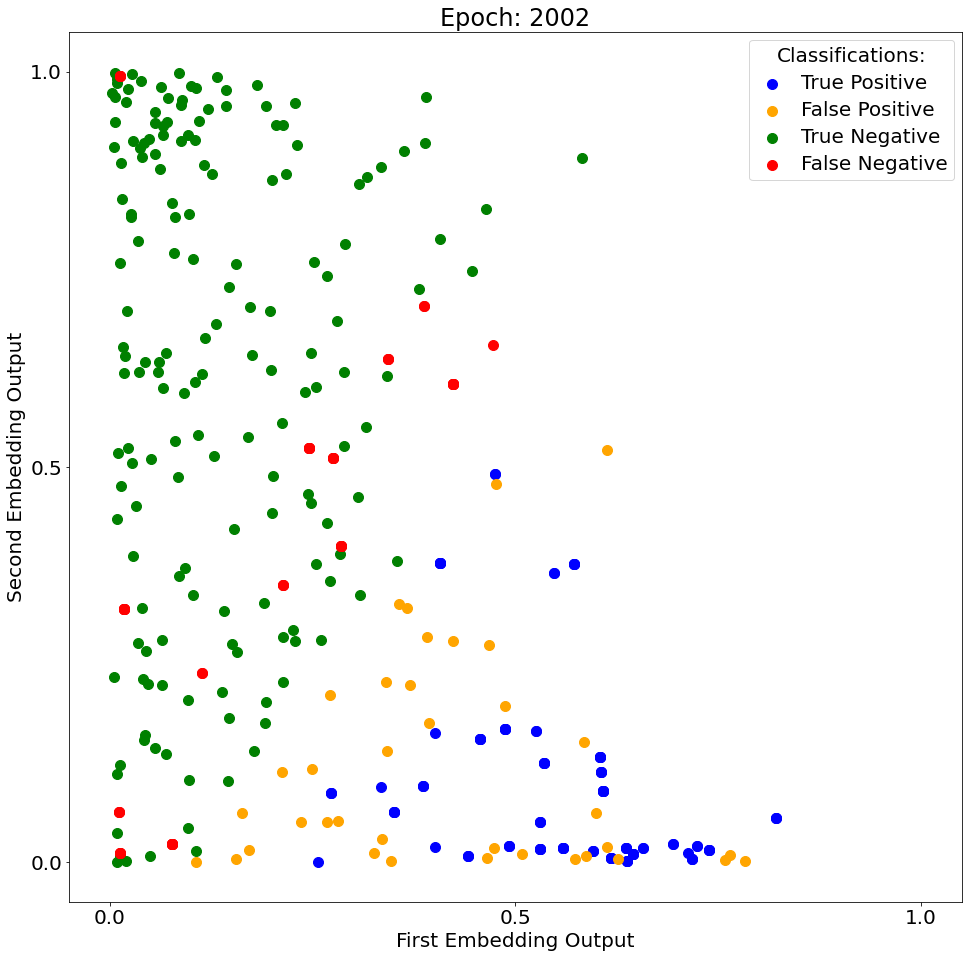

Epoch: 2002  Accuracy: 0.747396  FP: 37  TP: 118  TPR: 0.662921  TNR: 0.820388


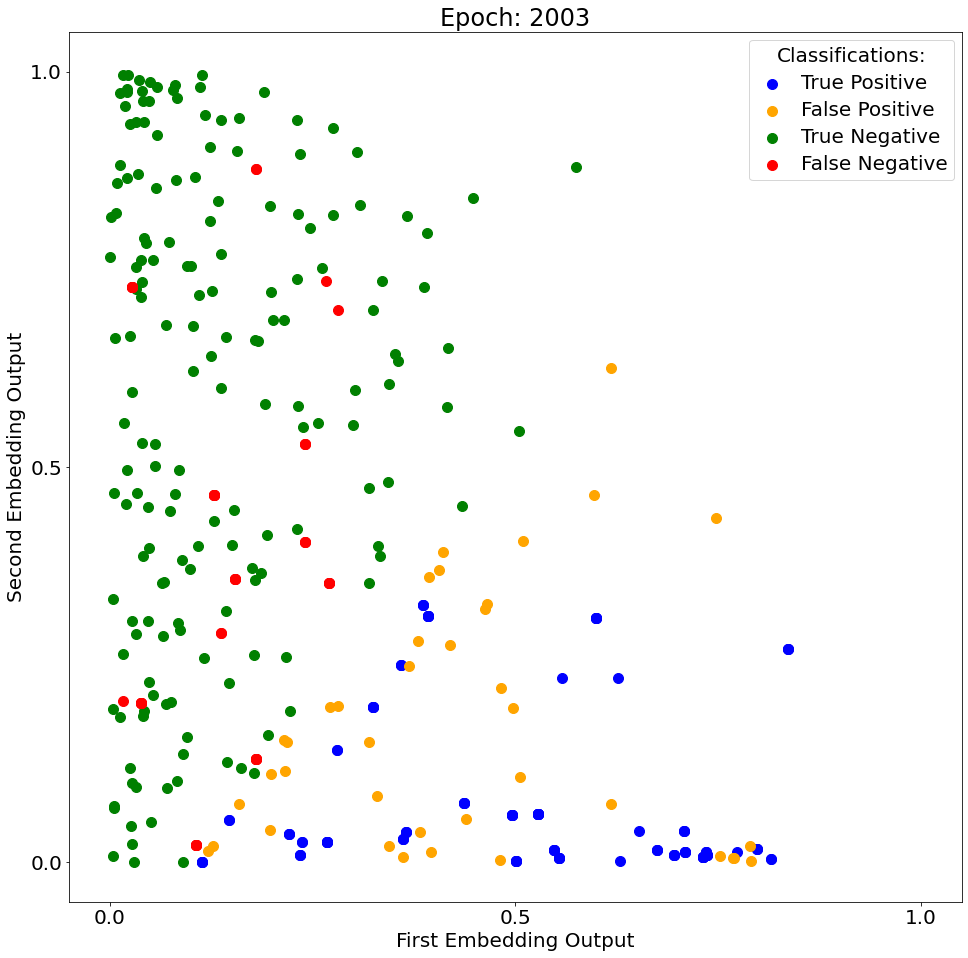

Epoch: 2003  Accuracy: 0.770235  FP: 39  TP: 124  TPR: 0.716763  TNR: 0.814286


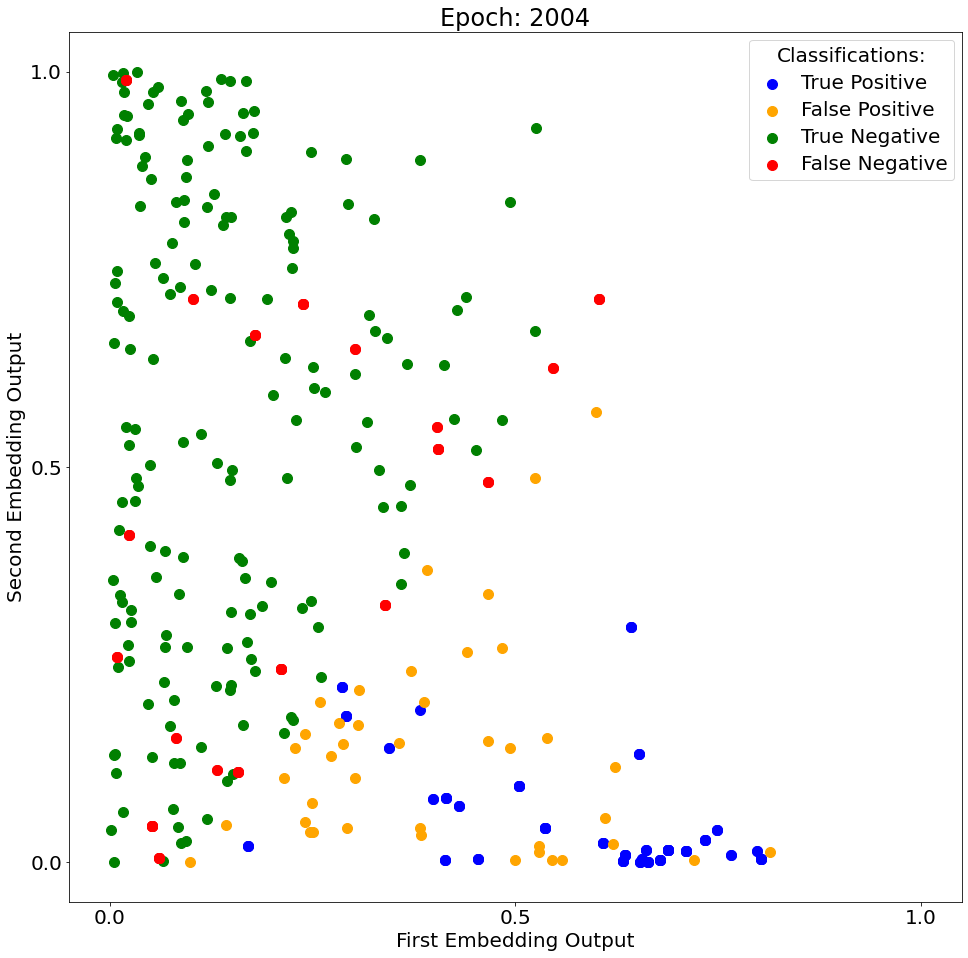

Epoch: 2004  Accuracy: 0.733167  FP: 41  TP: 116  TPR: 0.637363  TNR: 0.812785


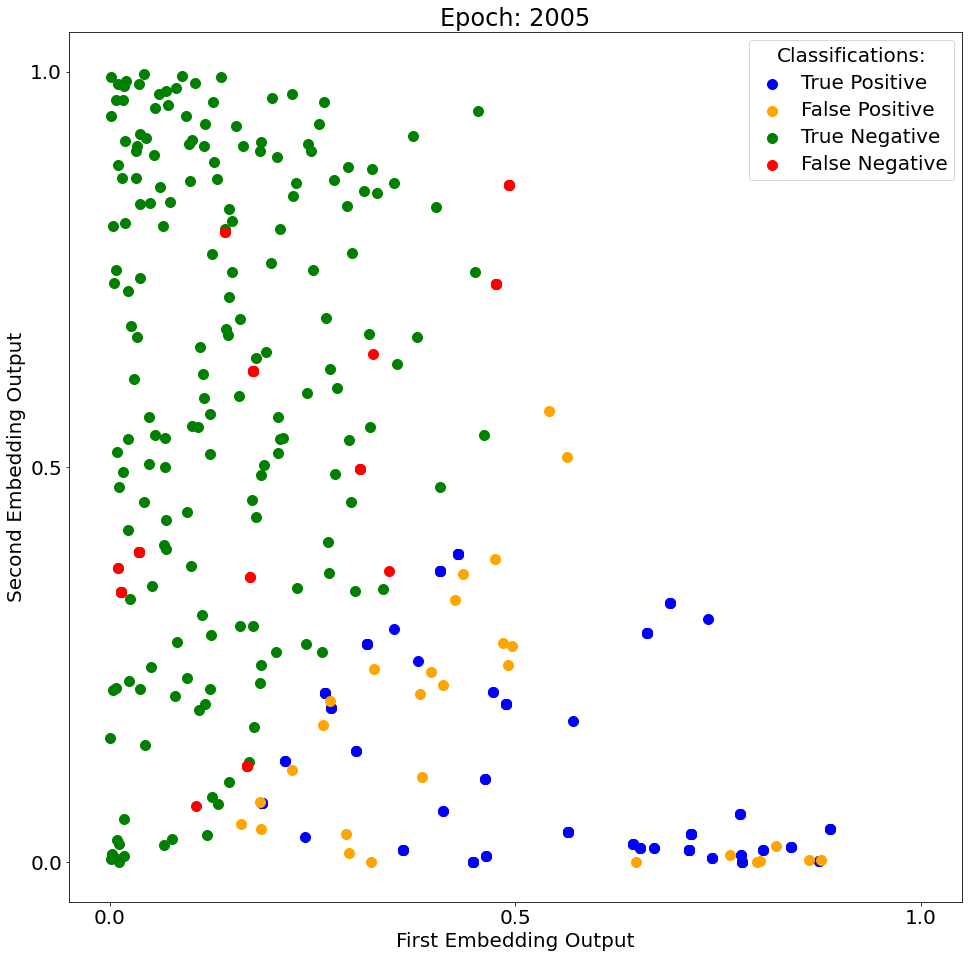

Epoch: 2005  Accuracy: 0.807692  FP: 29  TP: 137  TPR: 0.748634  TNR: 0.859903


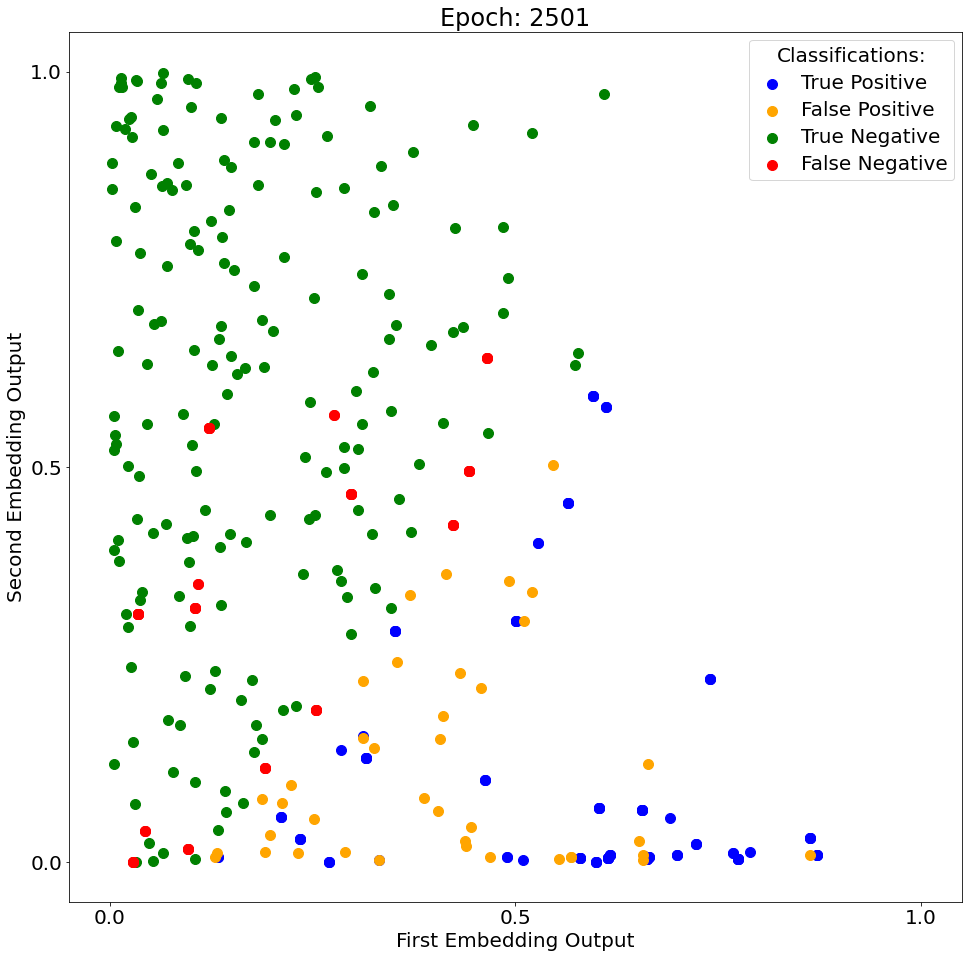

Epoch: 2501  Accuracy: 0.743142  FP: 39  TP: 118  TPR: 0.648352  TNR: 0.821918


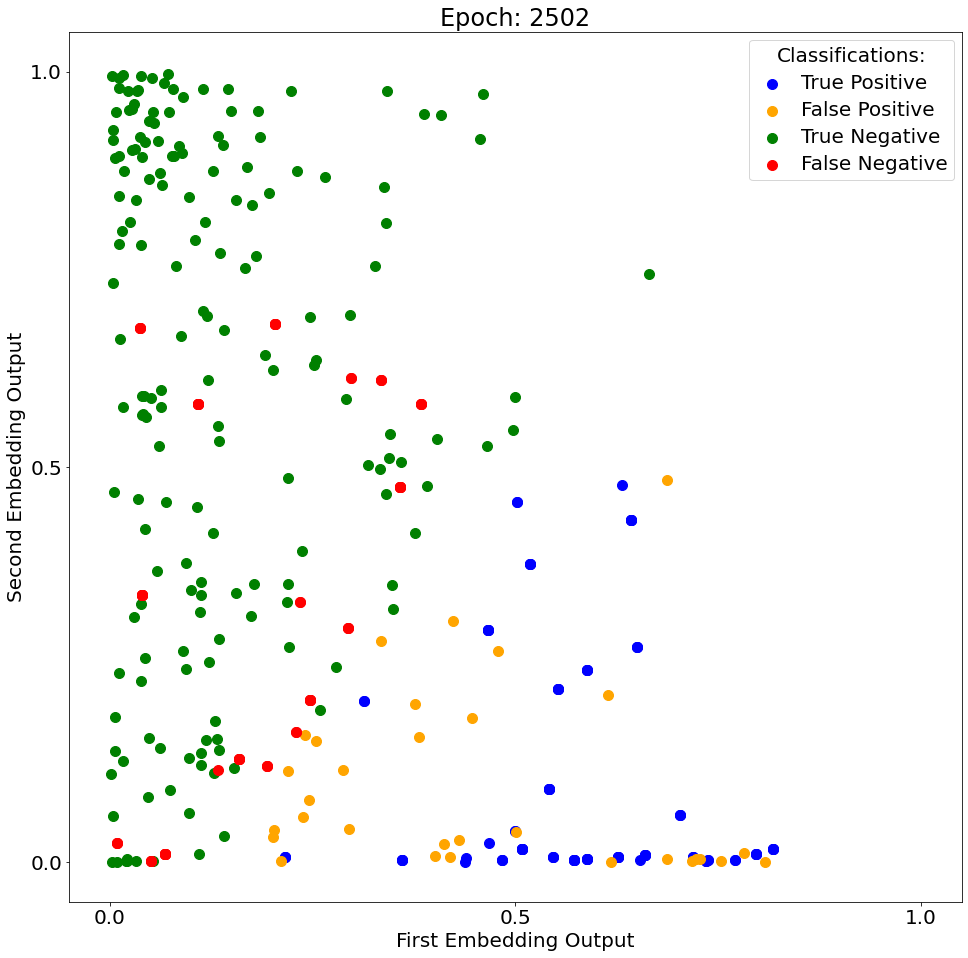

Epoch: 2502  Accuracy: 0.723958  FP: 31  TP: 103  TPR: 0.578652  TNR: 0.849515


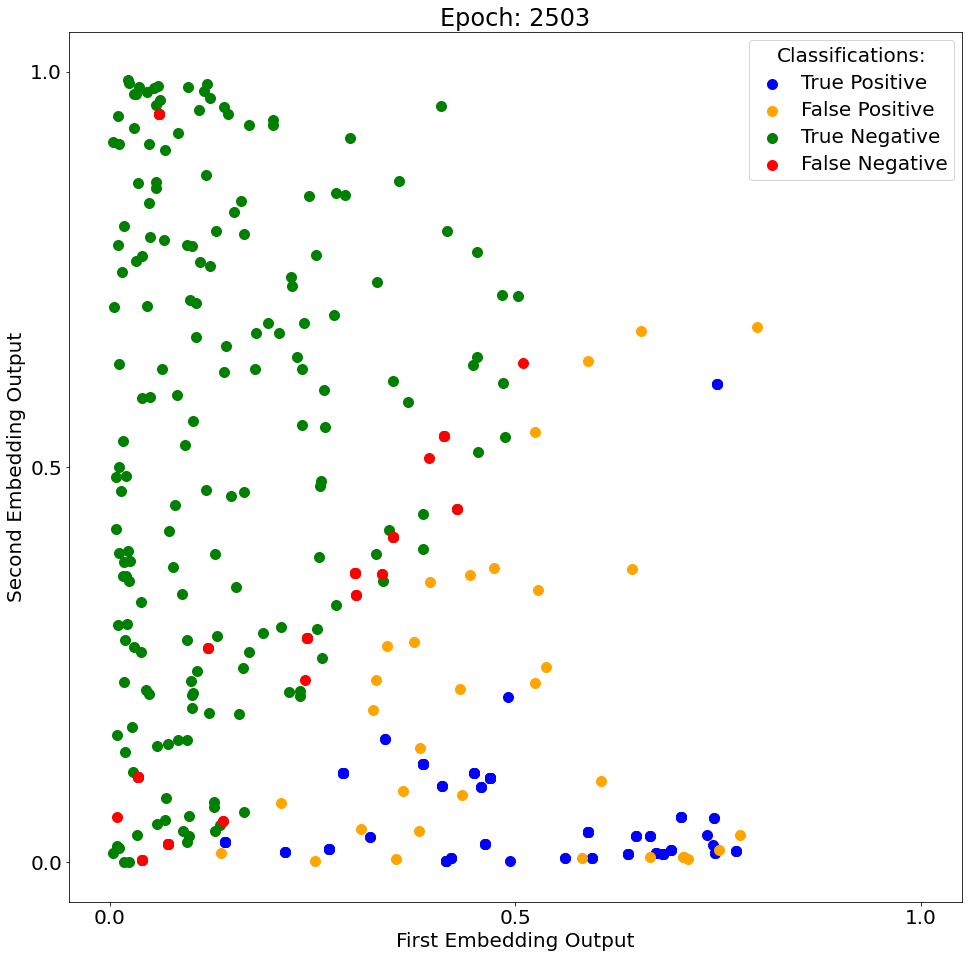

Epoch: 2503  Accuracy: 0.767624  FP: 33  TP: 117  TPR: 0.676301  TNR: 0.842857


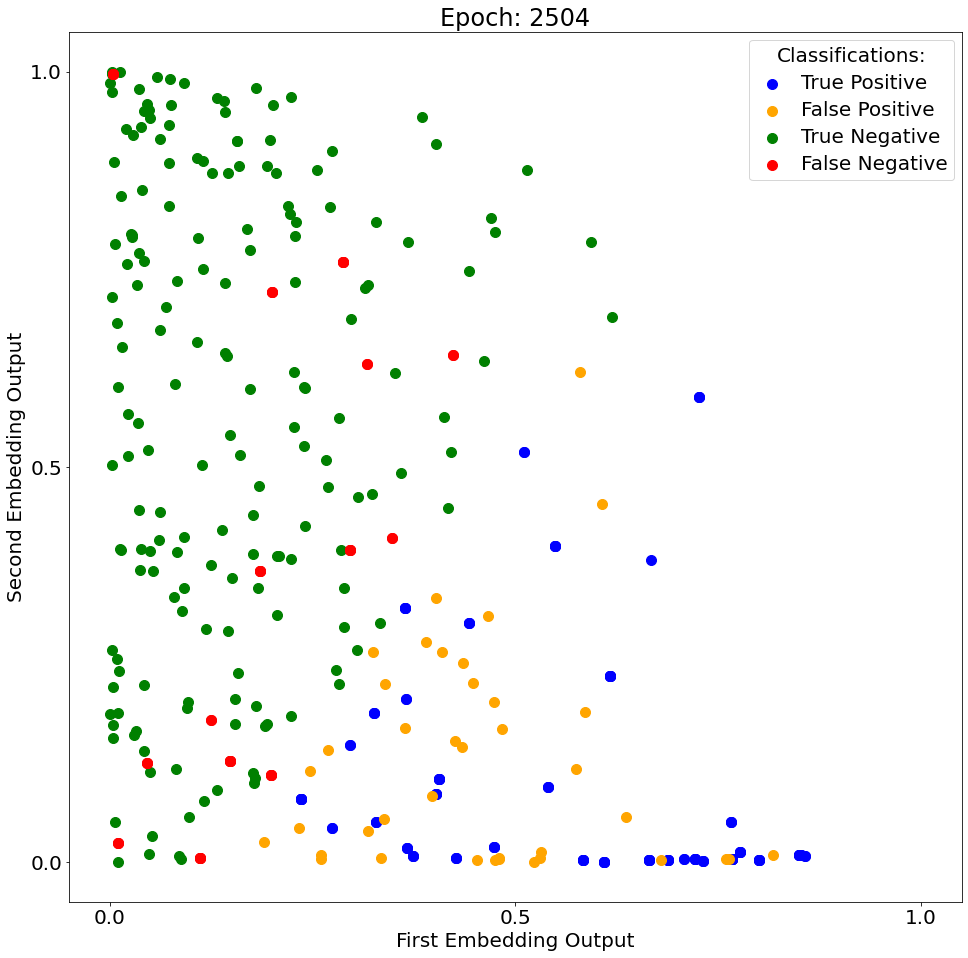

Epoch: 2504  Accuracy: 0.783042  FP: 39  TP: 134  TPR: 0.736264  TNR: 0.821918


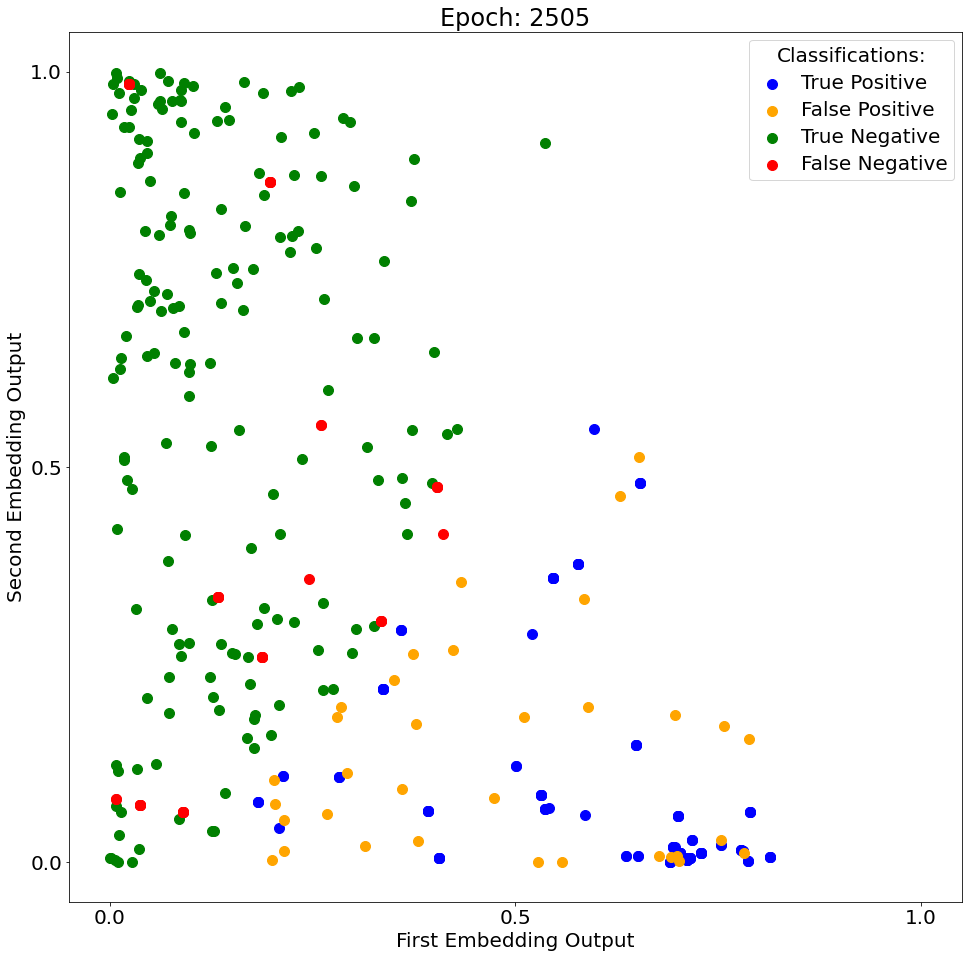

Epoch: 2505  Accuracy: 0.787179  FP: 34  TP: 134  TPR: 0.732240  TNR: 0.835749


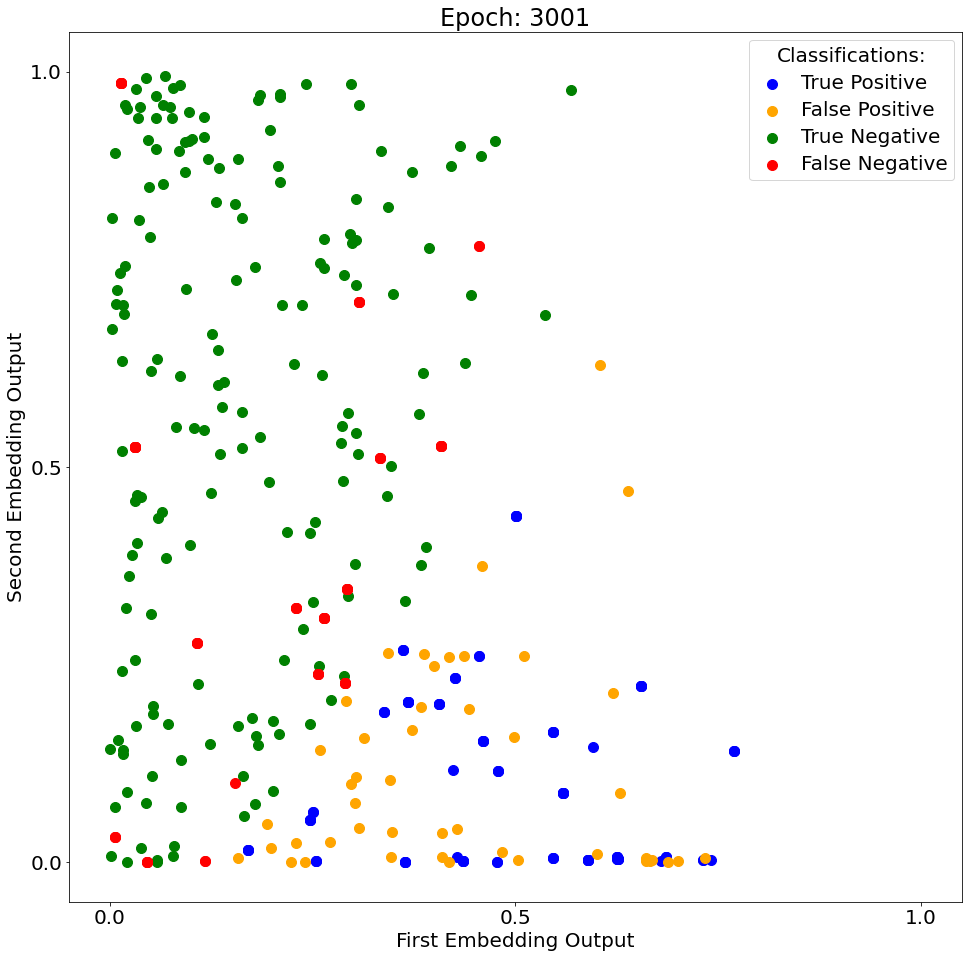

Epoch: 3001  Accuracy: 0.713217  FP: 46  TP: 113  TPR: 0.620879  TNR: 0.789954


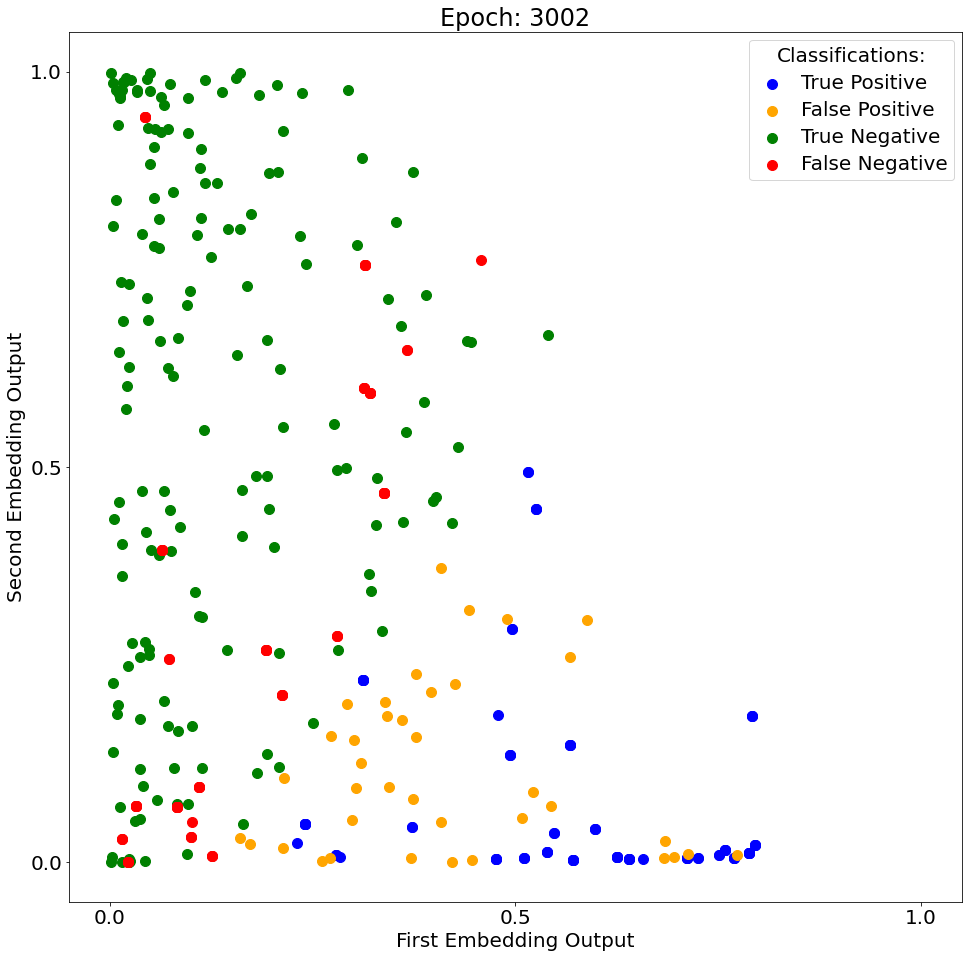

Epoch: 3002  Accuracy: 0.687500  FP: 38  TP: 96  TPR: 0.539326  TNR: 0.815534


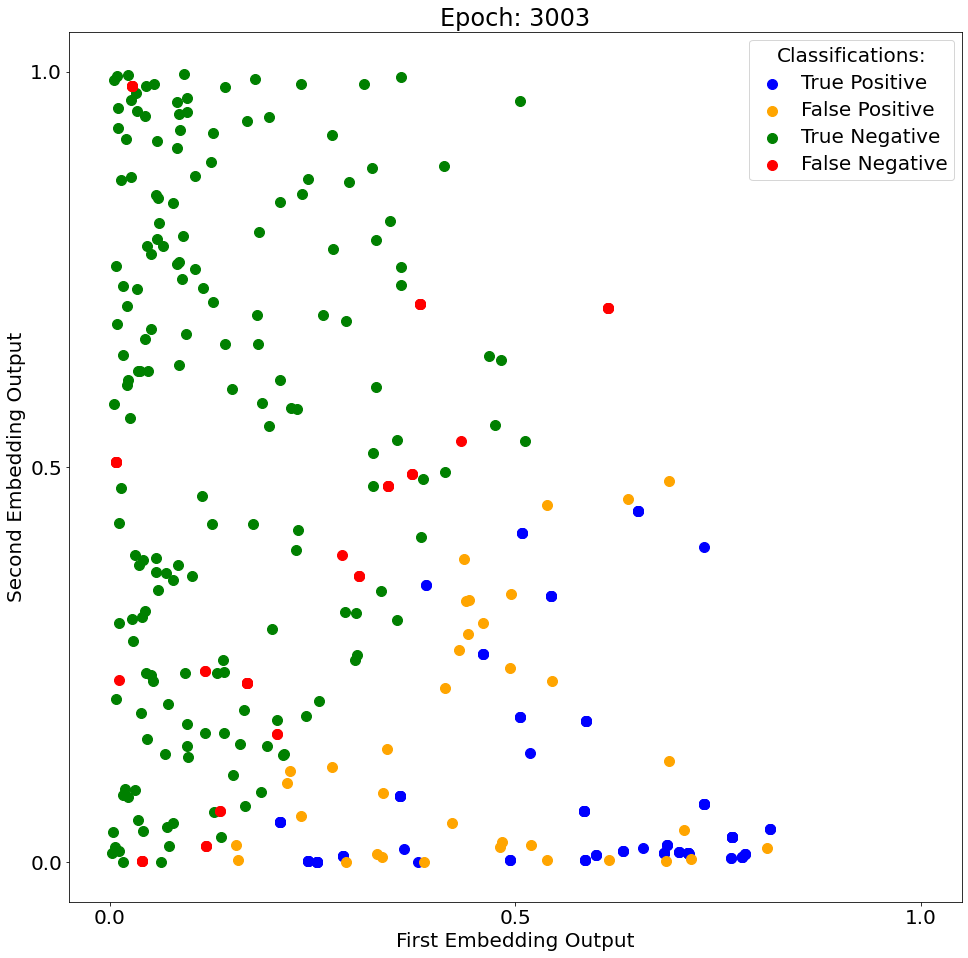

Epoch: 3003  Accuracy: 0.770235  FP: 36  TP: 121  TPR: 0.699422  TNR: 0.828571


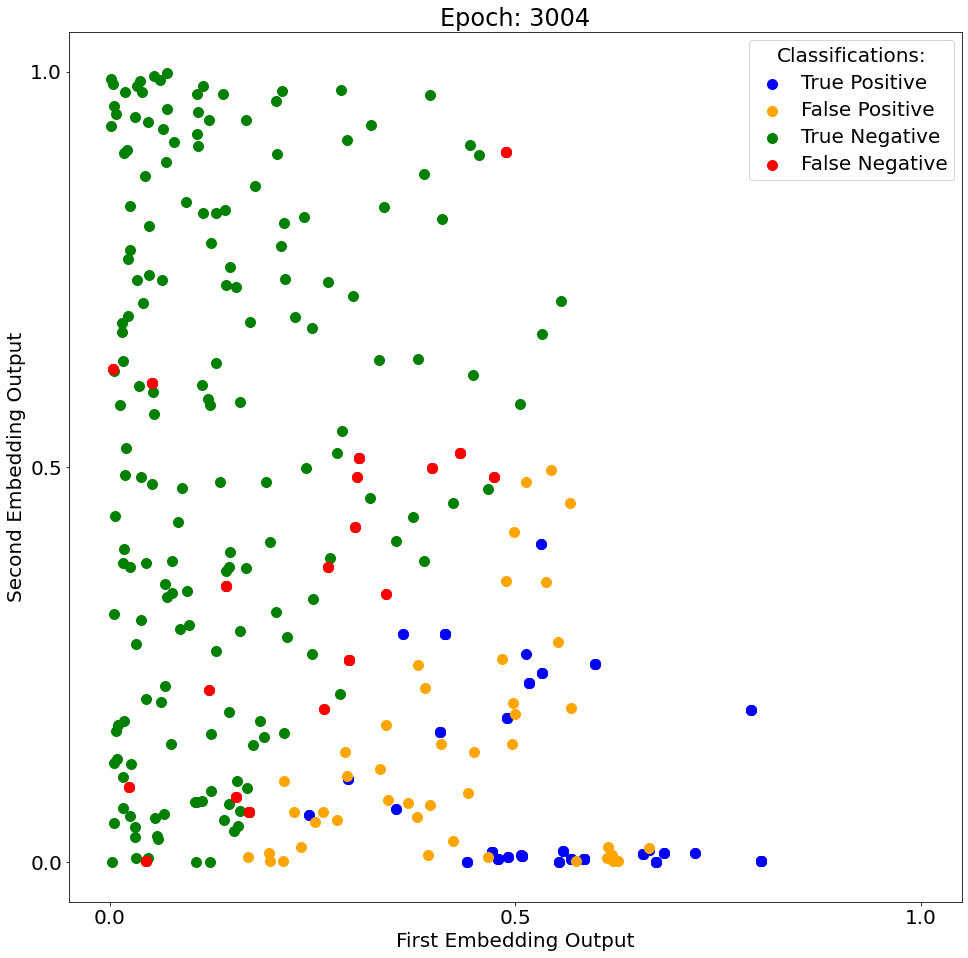

Epoch: 3004  Accuracy: 0.715711  FP: 45  TP: 113  TPR: 0.620879  TNR: 0.794521


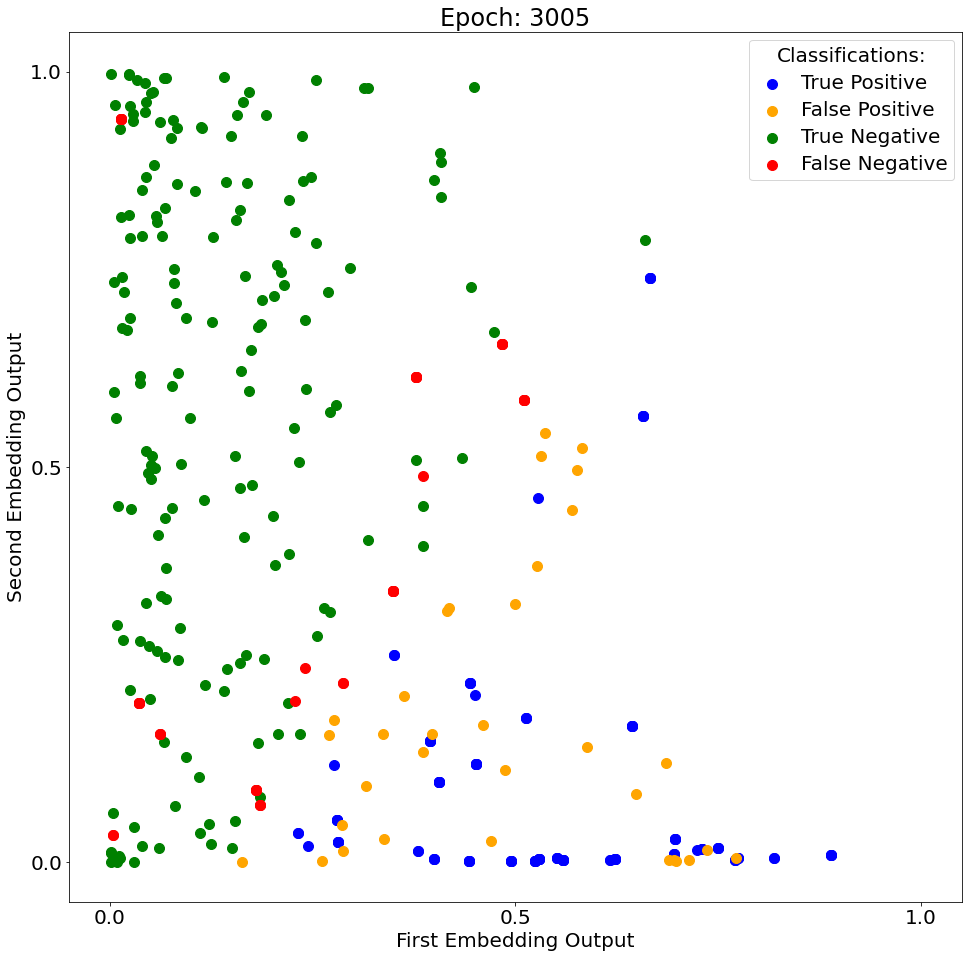

Epoch: 3005  Accuracy: 0.779487  FP: 33  TP: 130  TPR: 0.710383  TNR: 0.840580


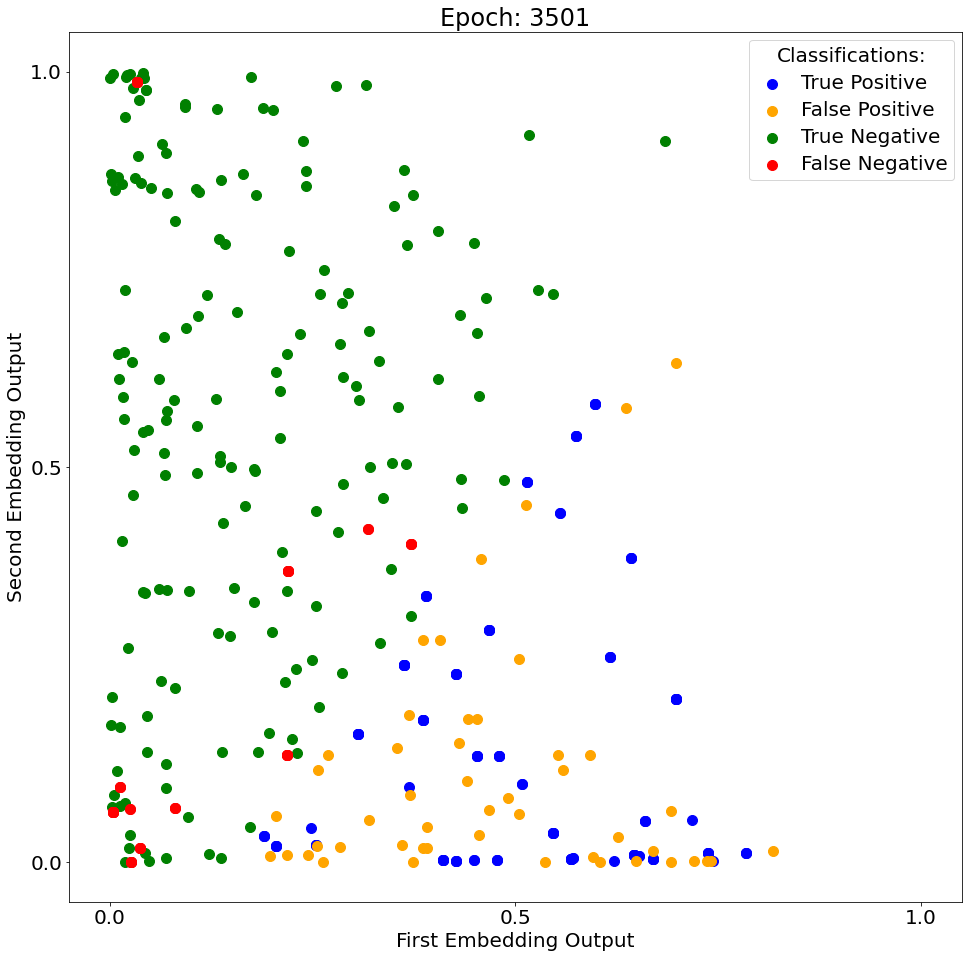

Epoch: 3501  Accuracy: 0.760598  FP: 48  TP: 134  TPR: 0.736264  TNR: 0.780822


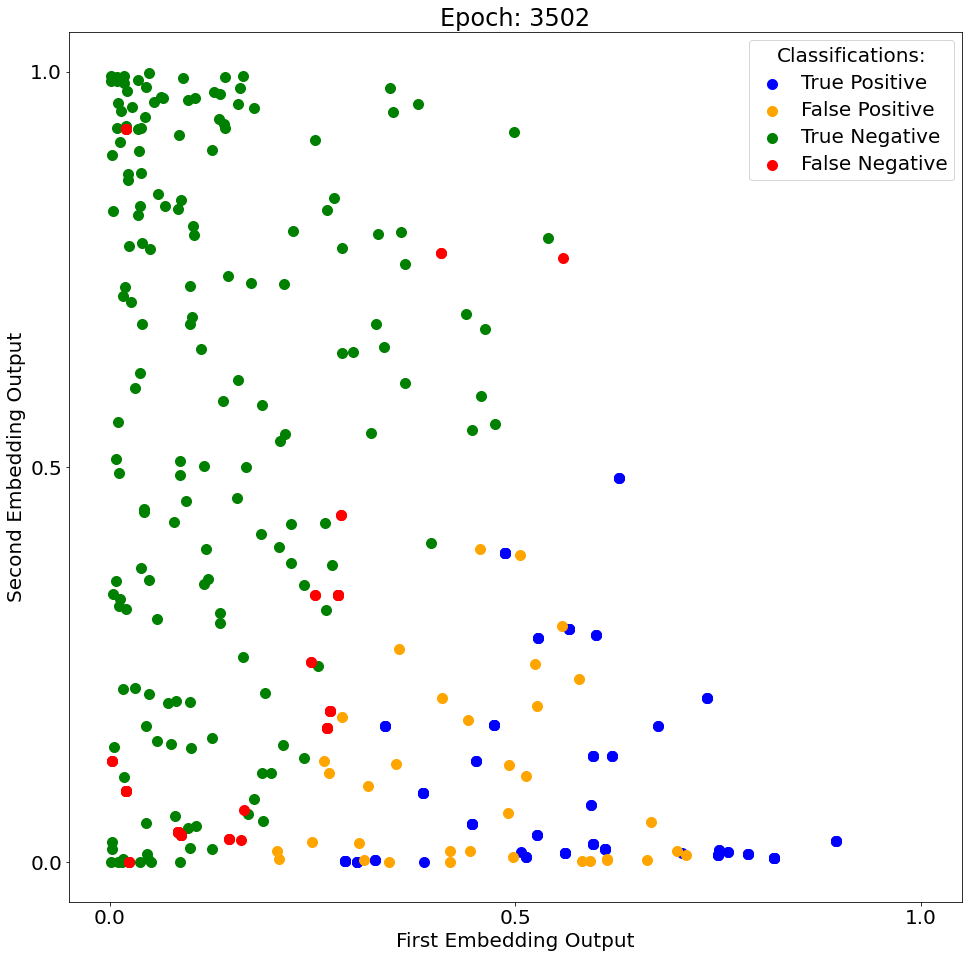

Epoch: 3502  Accuracy: 0.747396  FP: 35  TP: 116  TPR: 0.651685  TNR: 0.830097


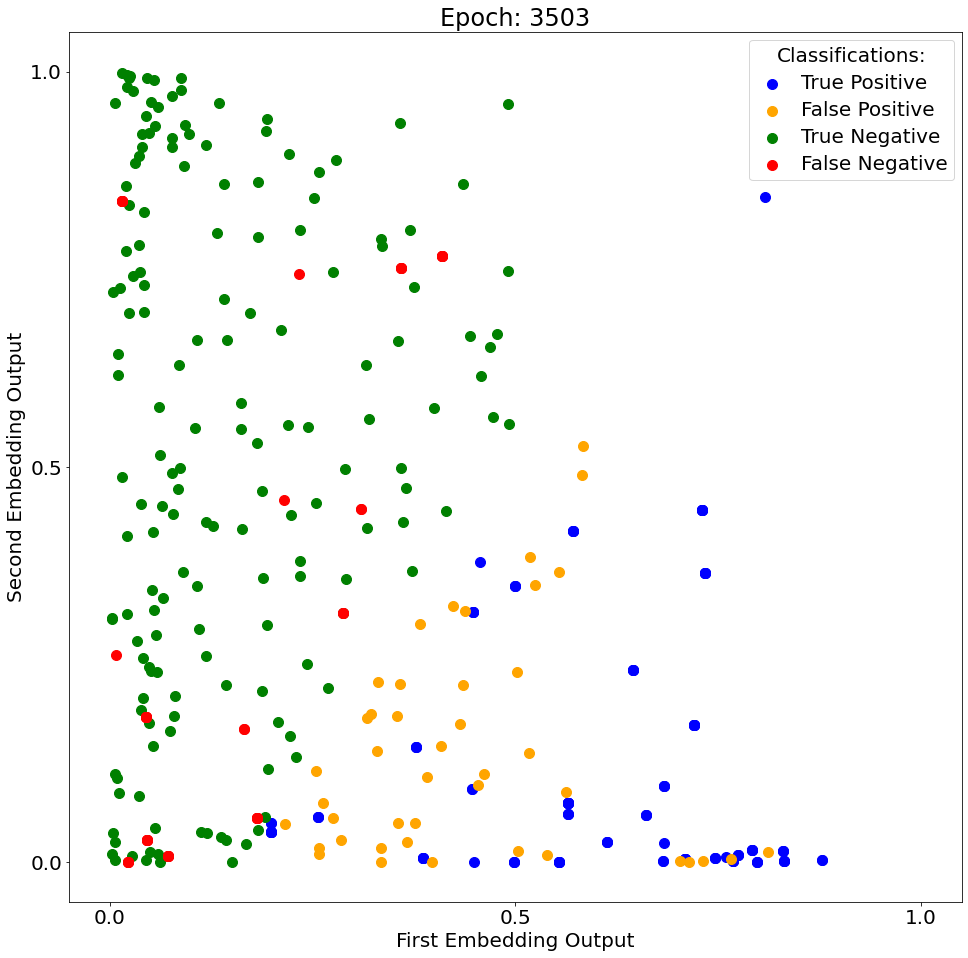

Epoch: 3503  Accuracy: 0.754569  FP: 43  TP: 122  TPR: 0.705202  TNR: 0.795238


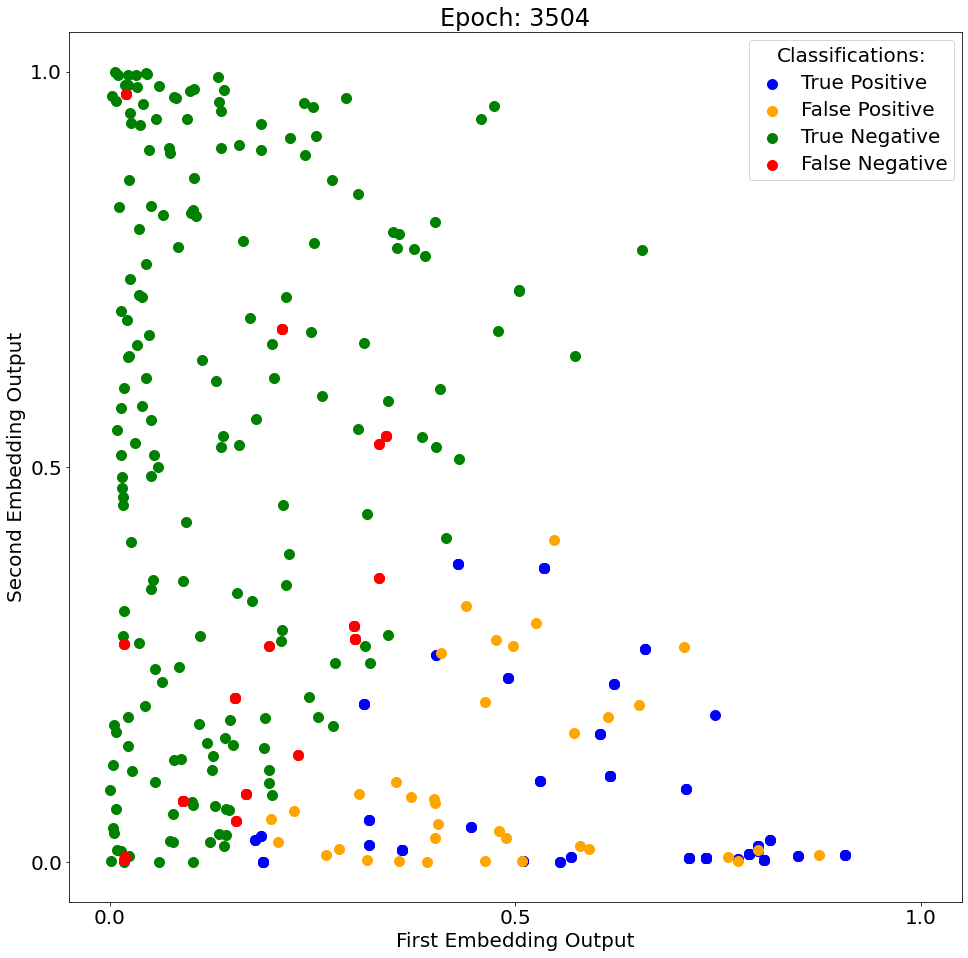

Epoch: 3504  Accuracy: 0.755611  FP: 36  TP: 120  TPR: 0.659341  TNR: 0.835616


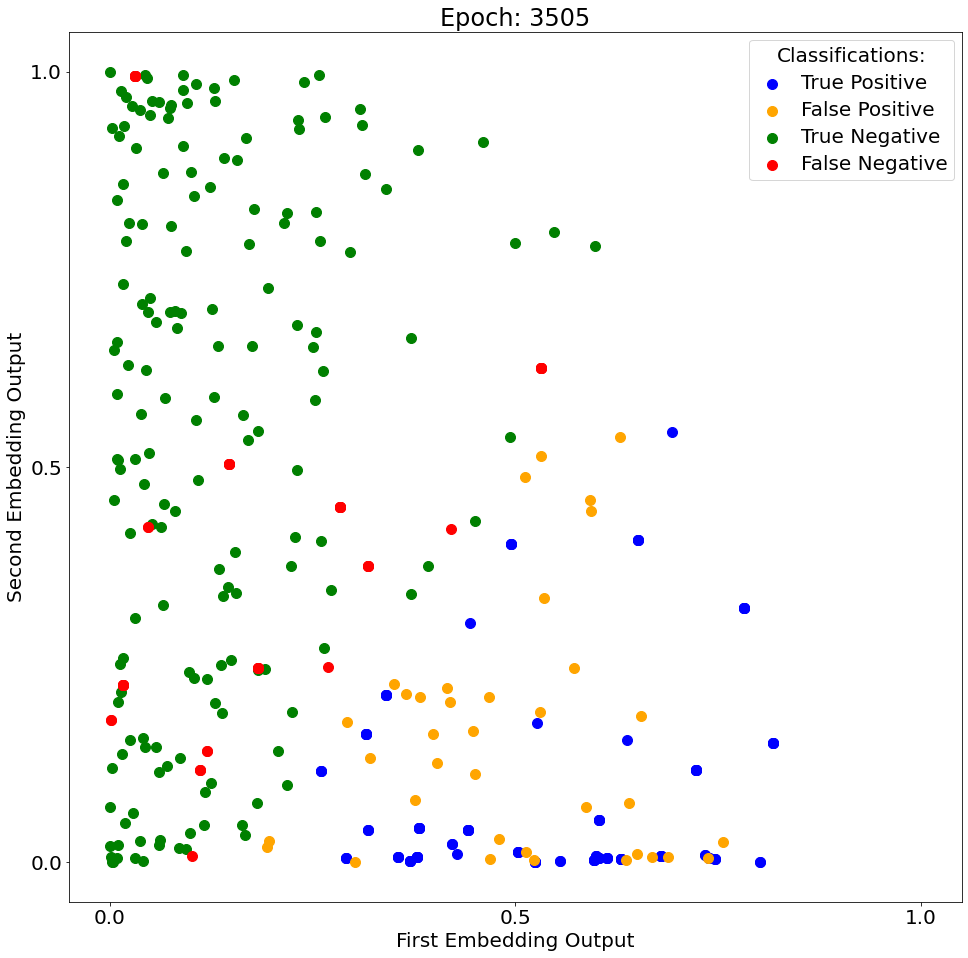

Epoch: 3505  Accuracy: 0.774359  FP: 37  TP: 132  TPR: 0.721311  TNR: 0.821256


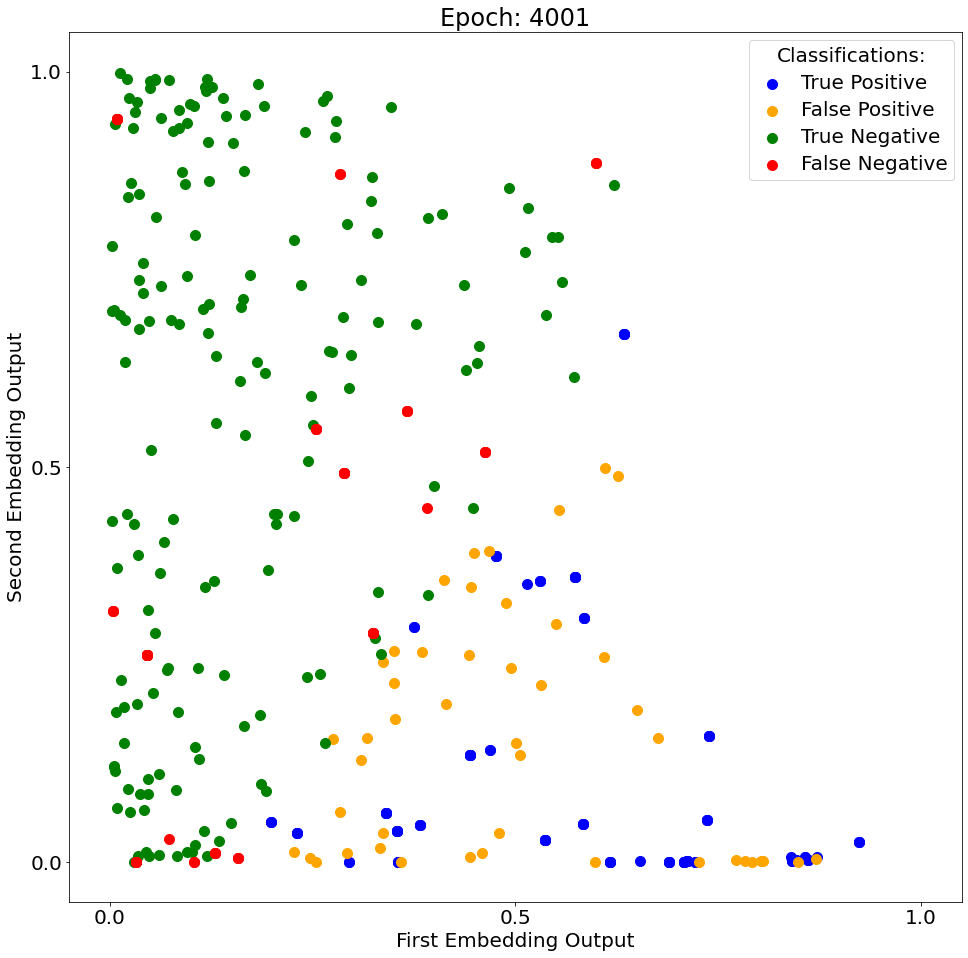

Epoch: 4001  Accuracy: 0.735661  FP: 46  TP: 122  TPR: 0.670330  TNR: 0.789954


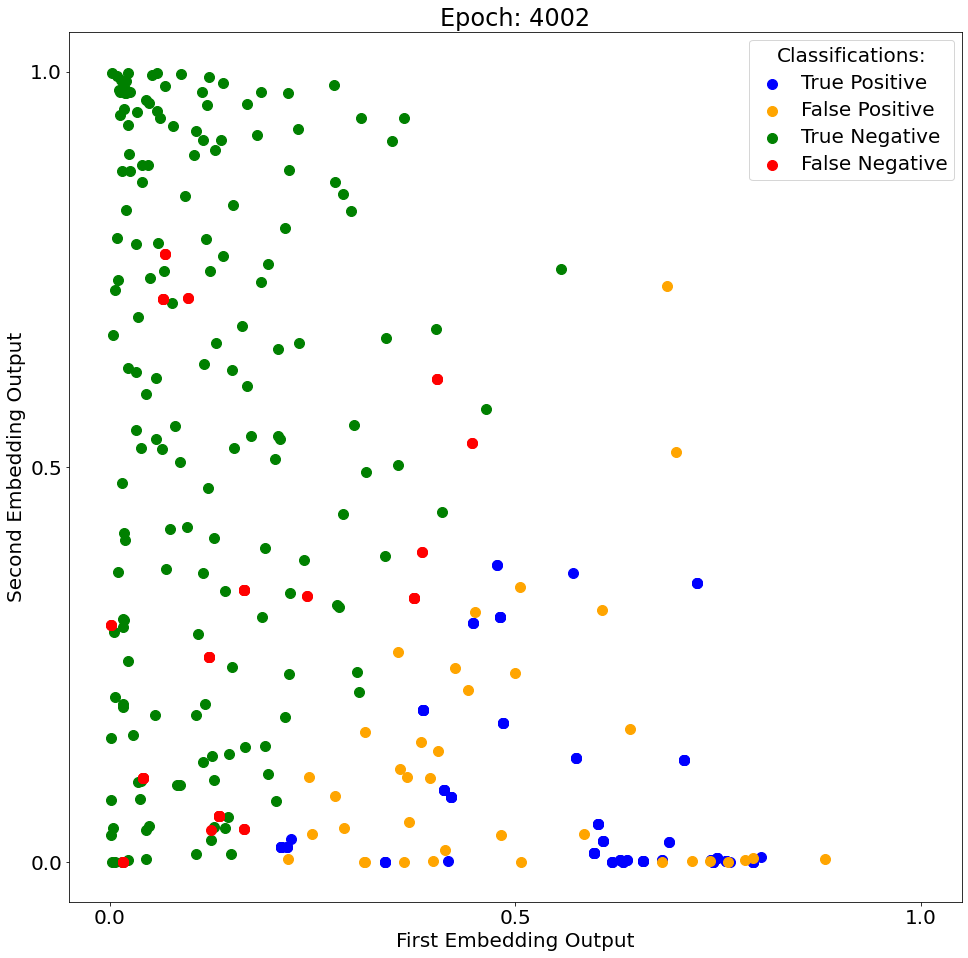

Epoch: 4002  Accuracy: 0.747396  FP: 37  TP: 118  TPR: 0.662921  TNR: 0.820388


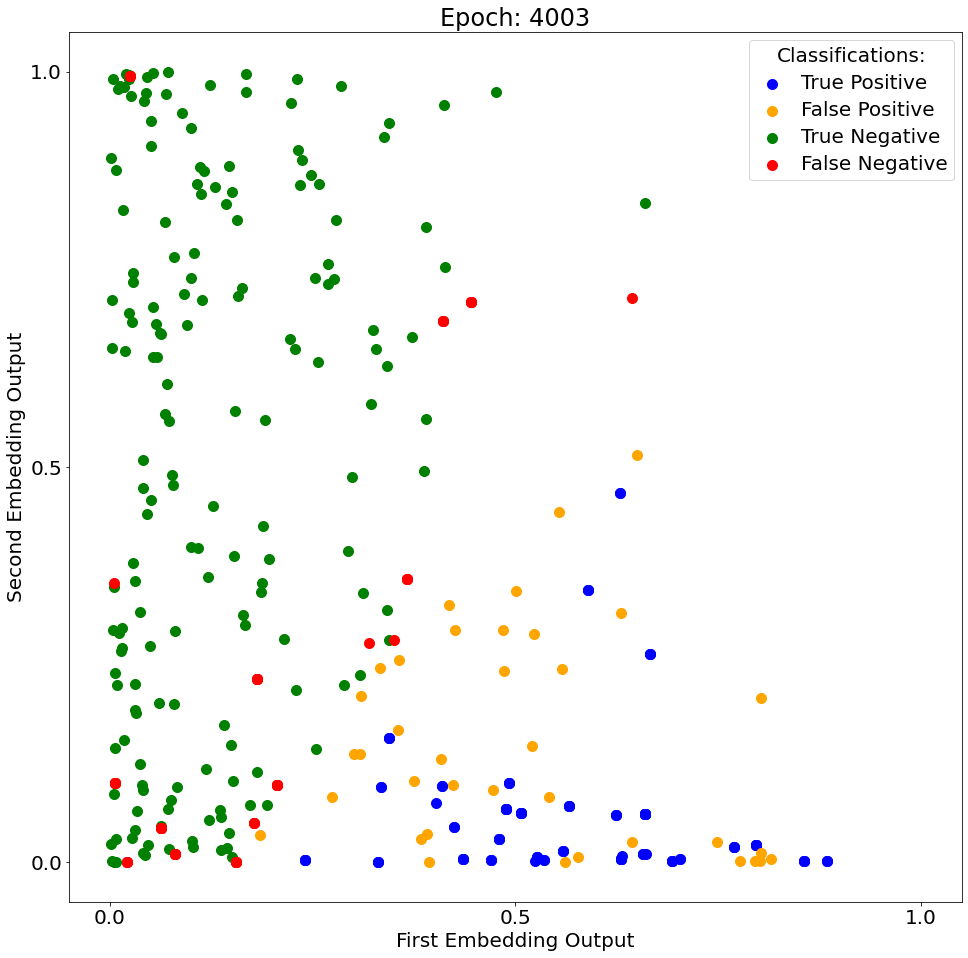

Epoch: 4003  Accuracy: 0.741514  FP: 37  TP: 111  TPR: 0.641618  TNR: 0.823810


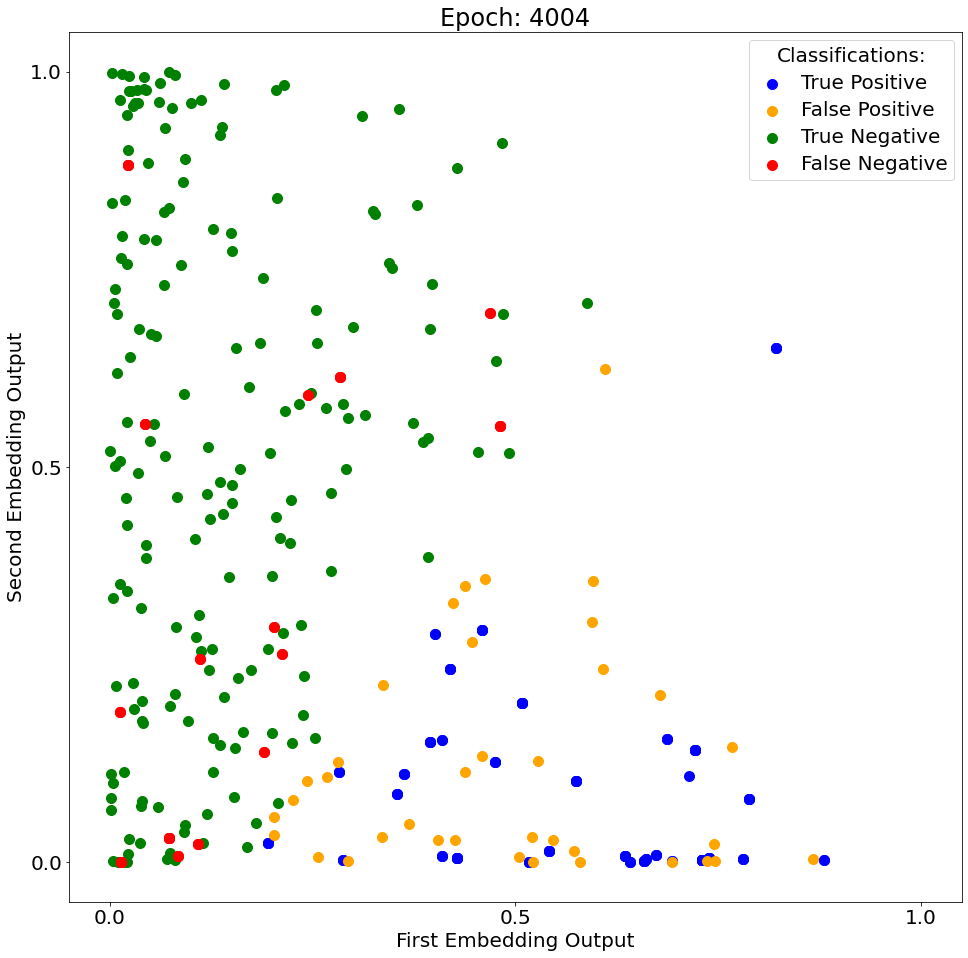

Epoch: 4004  Accuracy: 0.785536  FP: 37  TP: 133  TPR: 0.730769  TNR: 0.831050


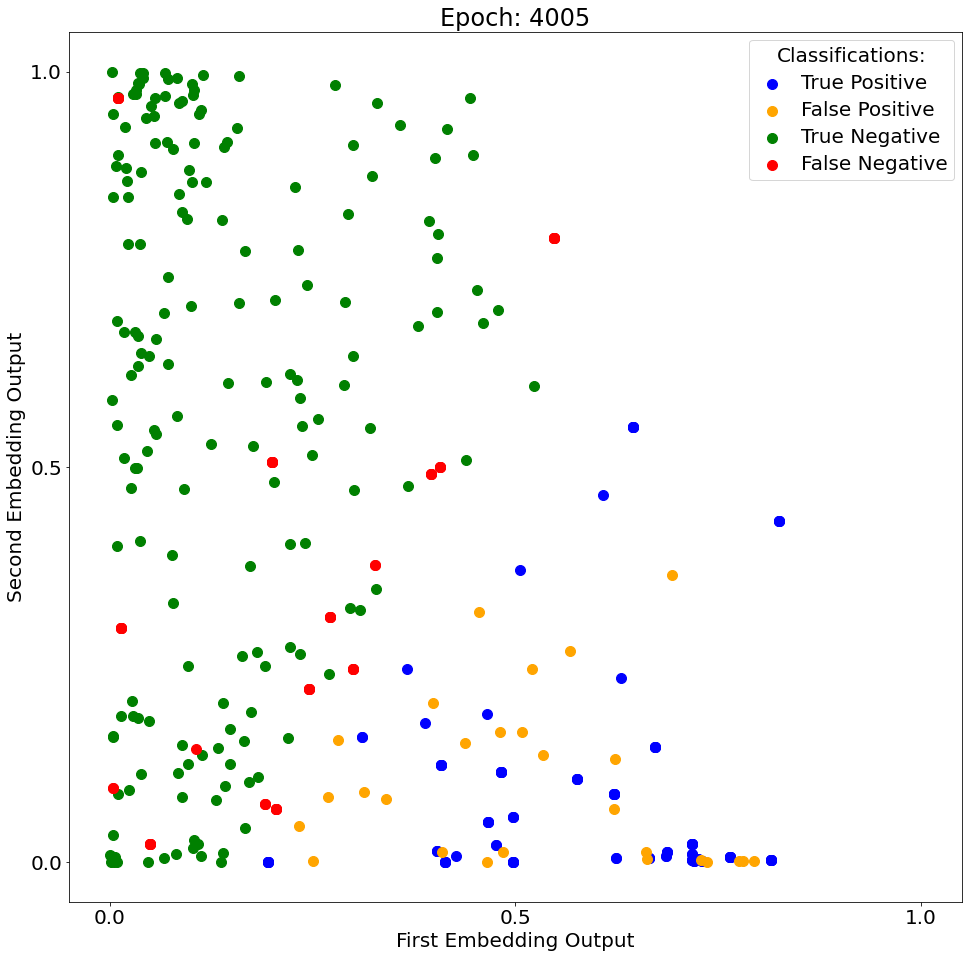

Epoch: 4005  Accuracy: 0.761538  FP: 27  TP: 117  TPR: 0.639344  TNR: 0.869565


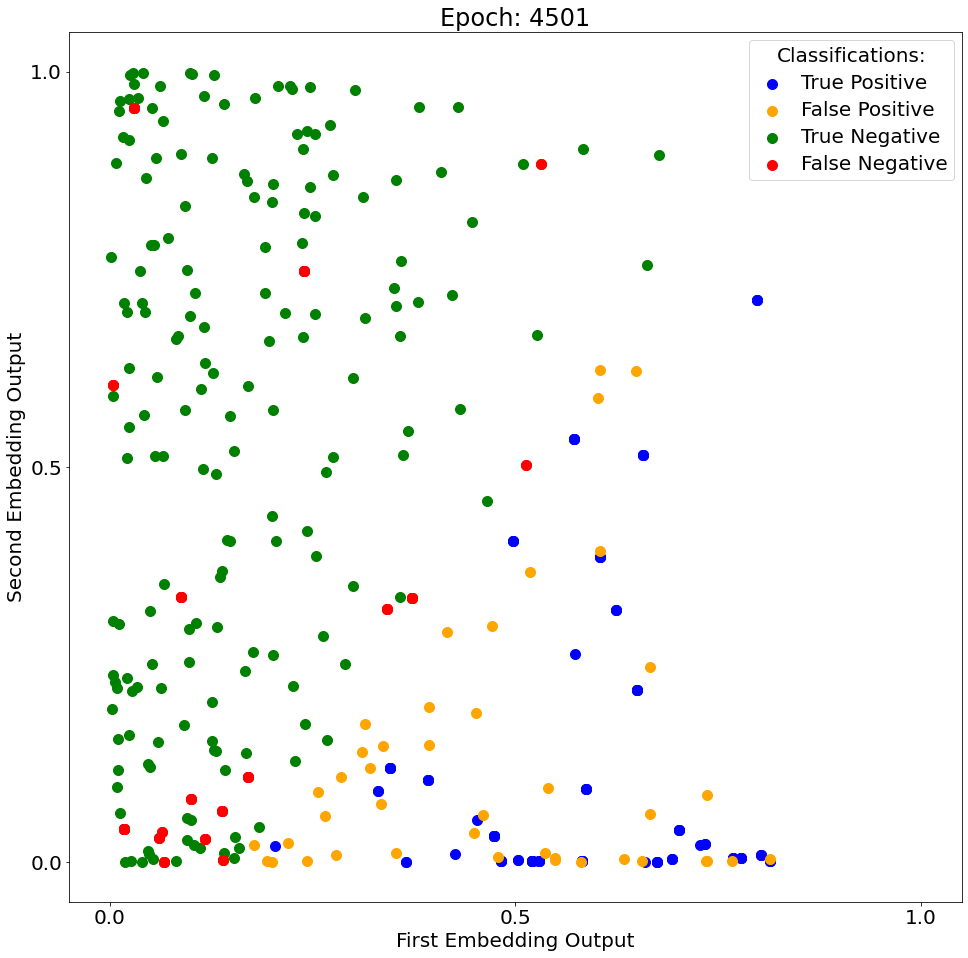

Epoch: 4501  Accuracy: 0.713217  FP: 42  TP: 109  TPR: 0.598901  TNR: 0.808219


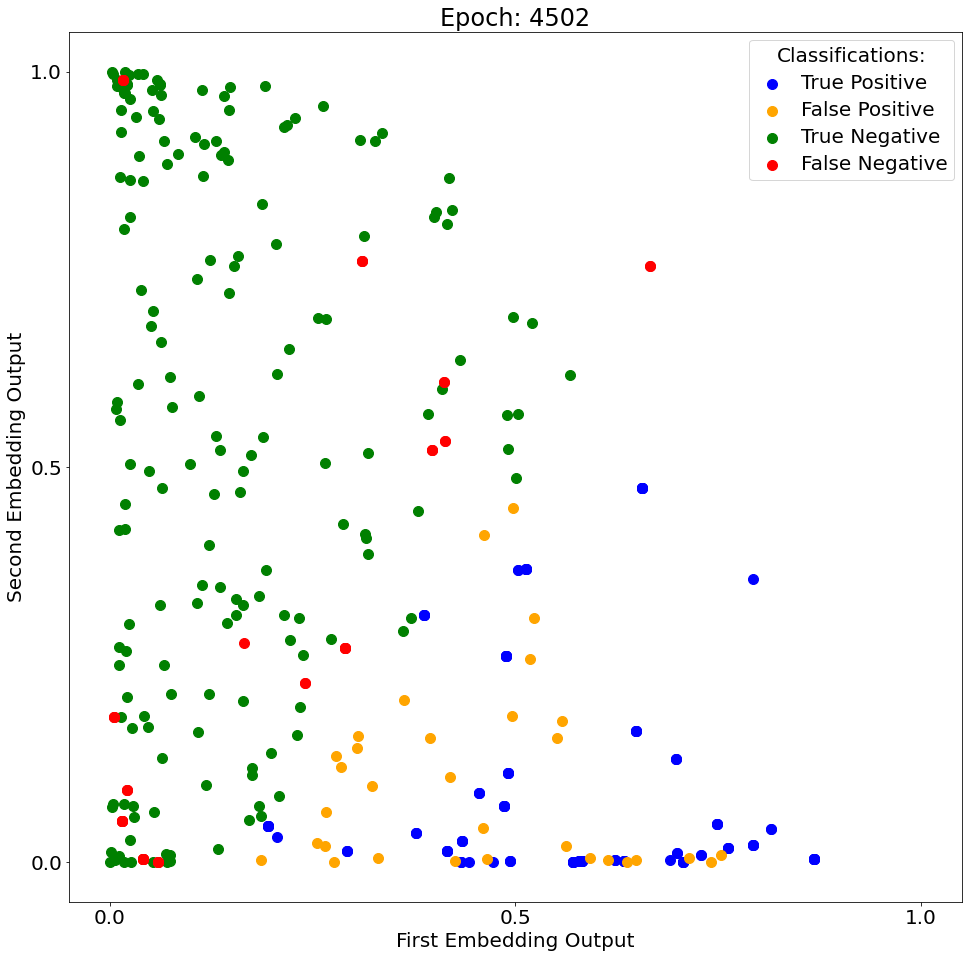

Epoch: 4502  Accuracy: 0.789062  FP: 32  TP: 129  TPR: 0.724719  TNR: 0.844660


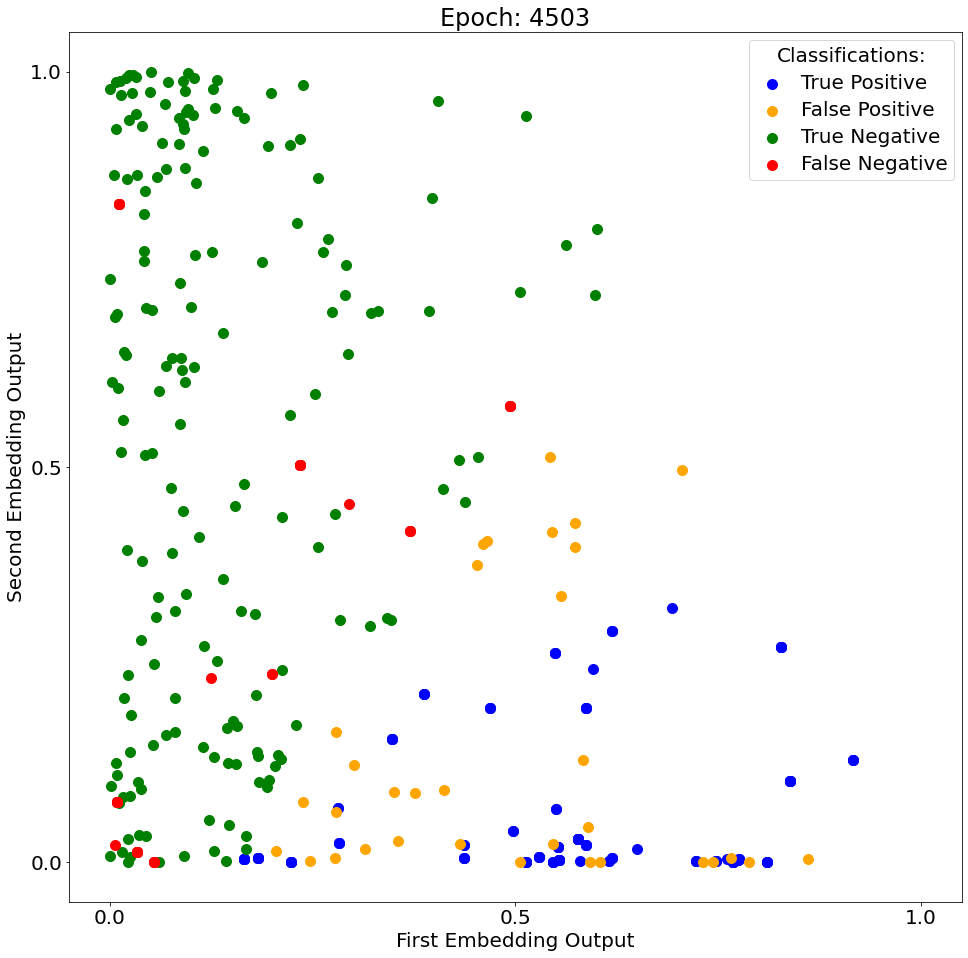

Epoch: 4503  Accuracy: 0.814621  FP: 33  TP: 135  TPR: 0.780347  TNR: 0.842857


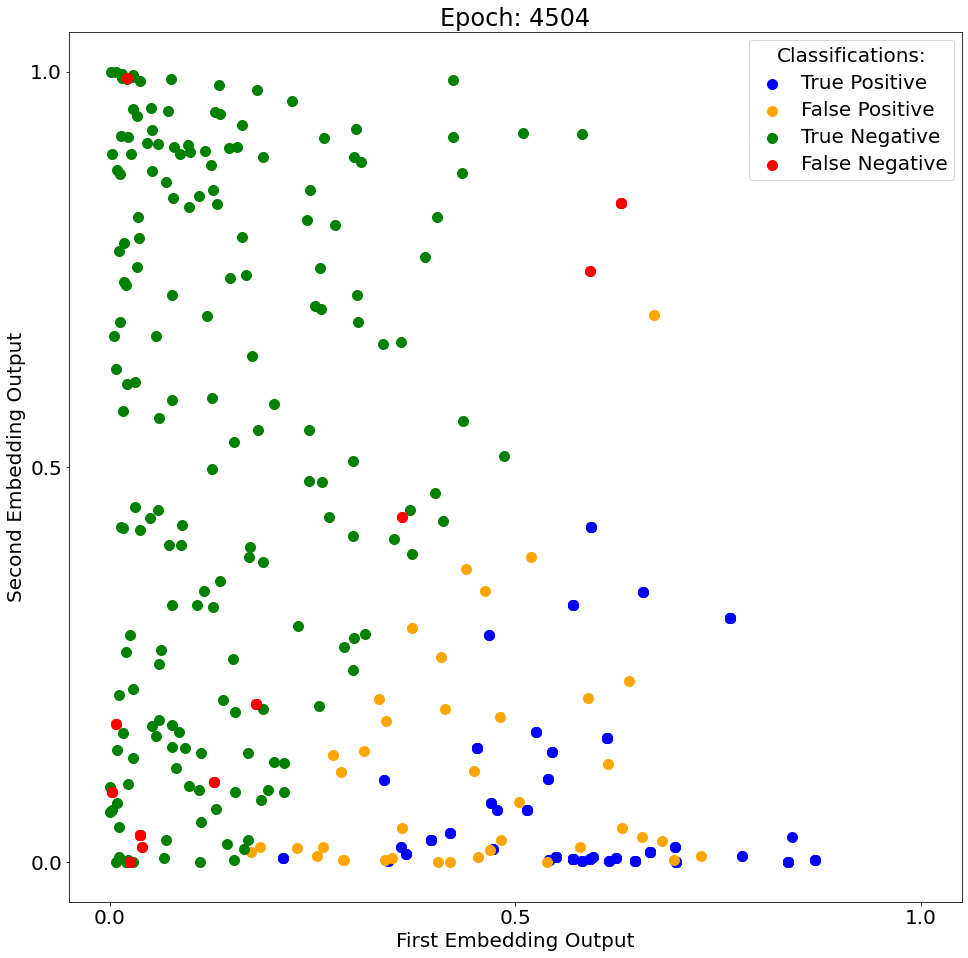

Epoch: 4504  Accuracy: 0.800499  FP: 40  TP: 142  TPR: 0.780220  TNR: 0.817352


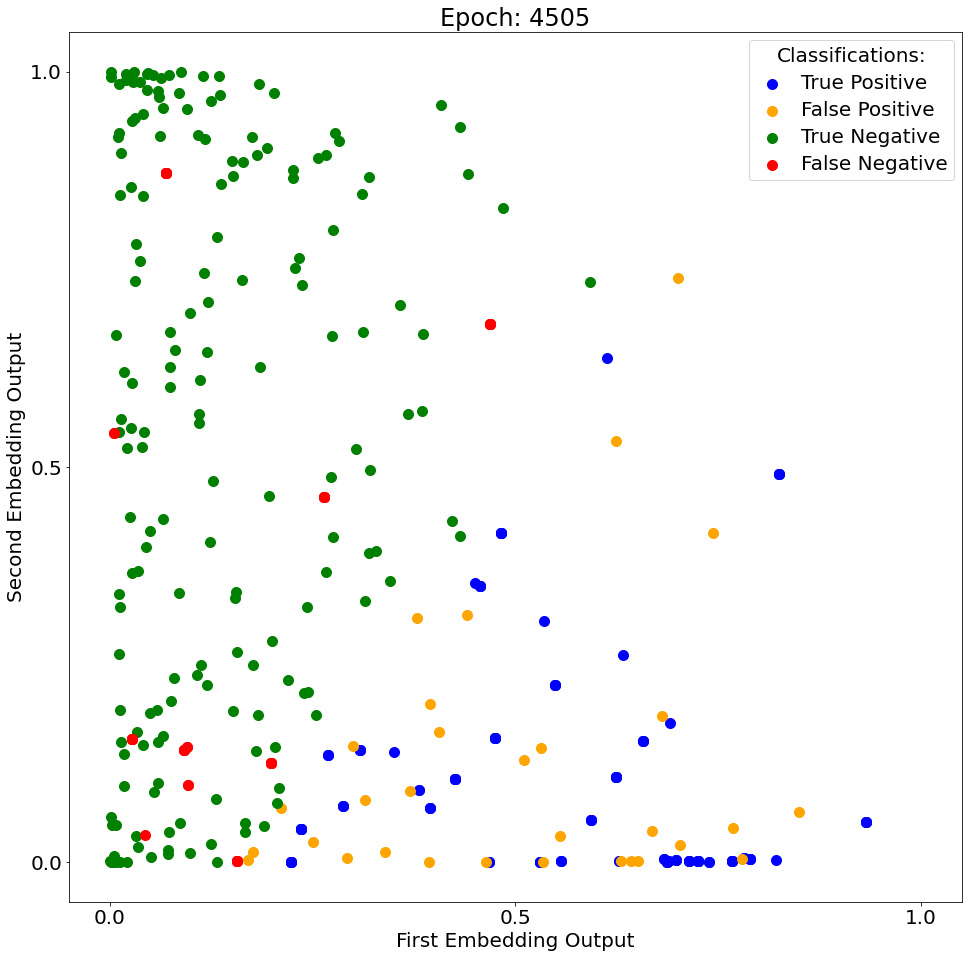

Epoch: 4505  Accuracy: 0.797436  FP: 31  TP: 135  TPR: 0.737705  TNR: 0.850242


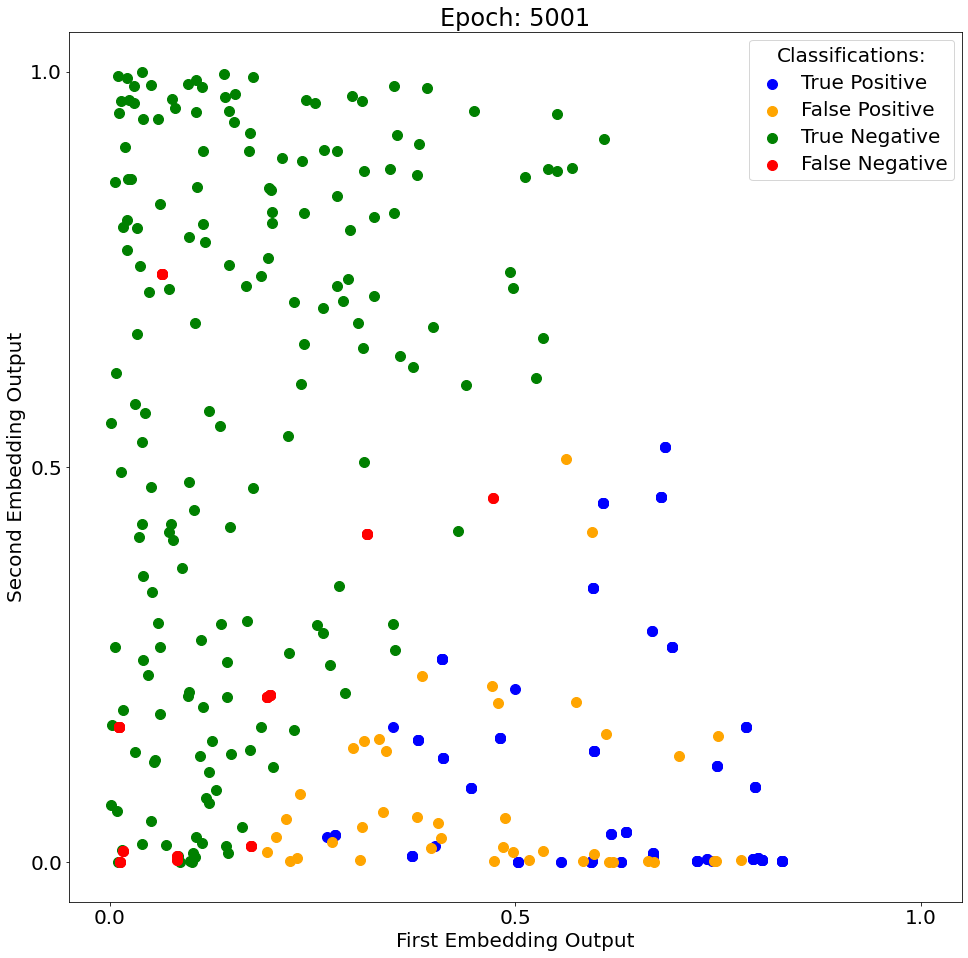

Epoch: 5001  Accuracy: 0.775561  FP: 42  TP: 134  TPR: 0.736264  TNR: 0.808219


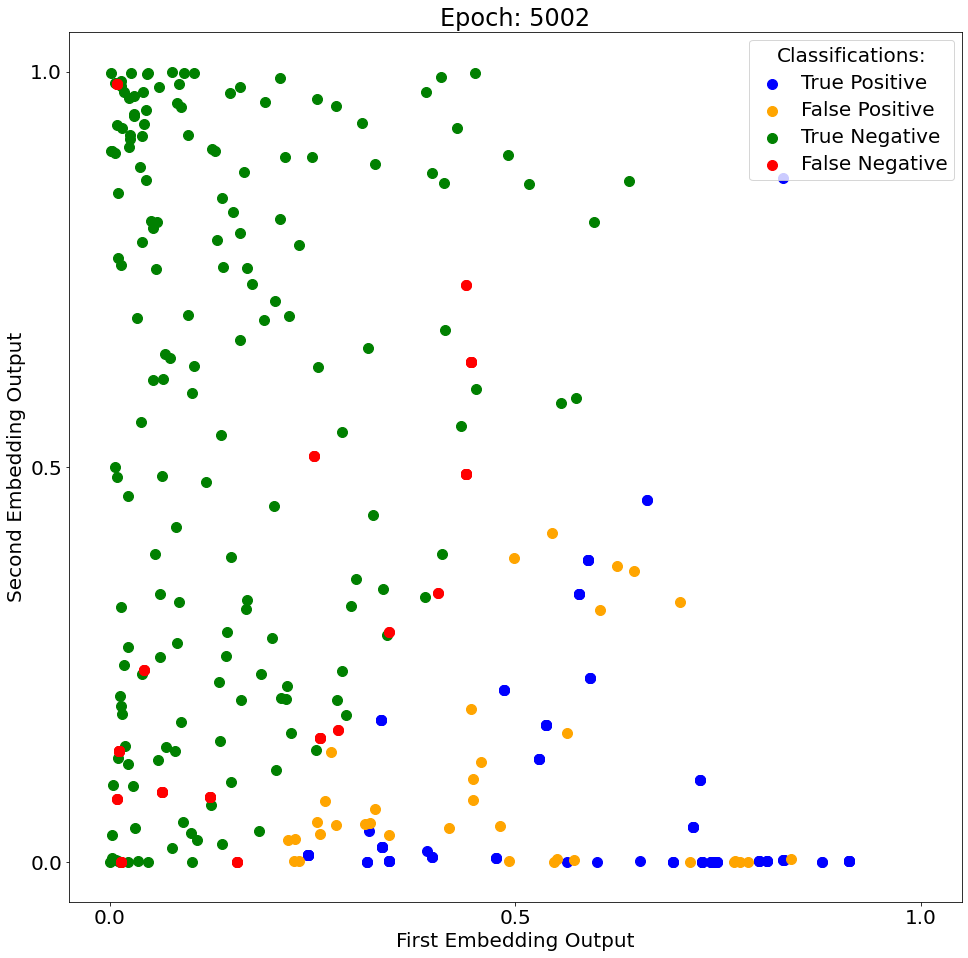

Epoch: 5002  Accuracy: 0.739583  FP: 36  TP: 114  TPR: 0.640449  TNR: 0.825243


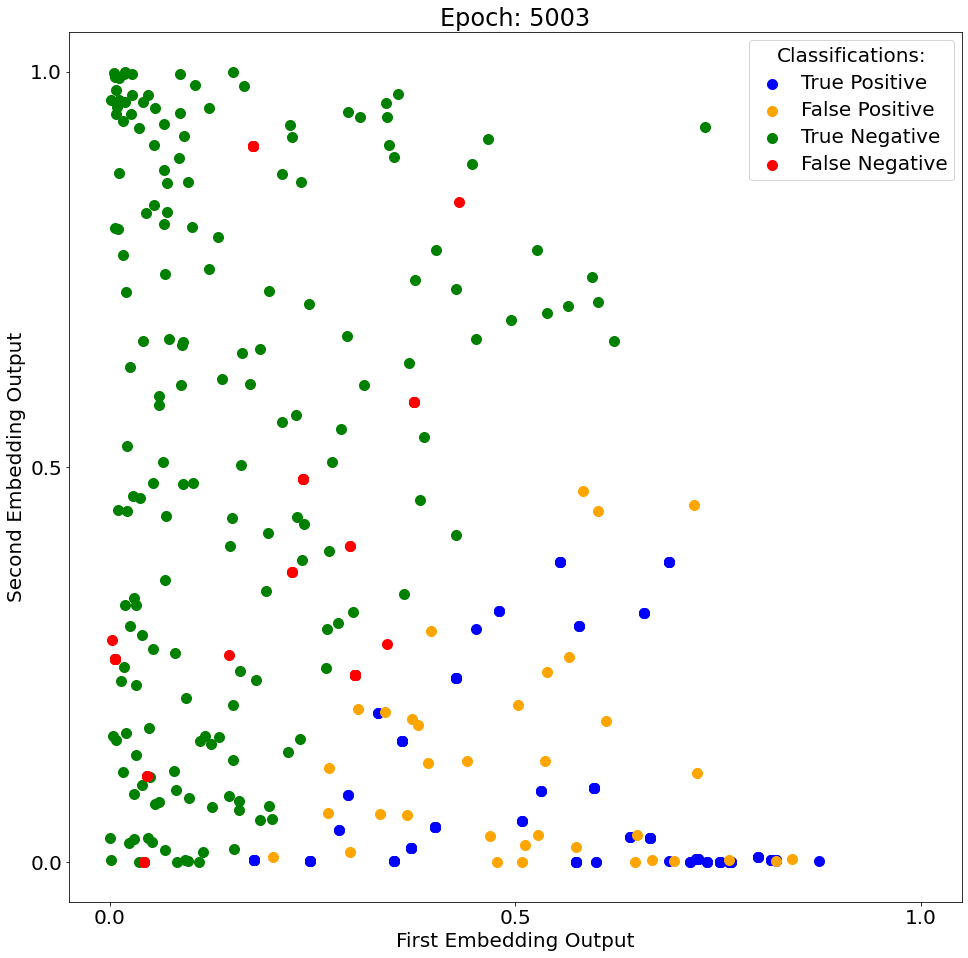

Epoch: 5003  Accuracy: 0.791123  FP: 35  TP: 128  TPR: 0.739884  TNR: 0.833333


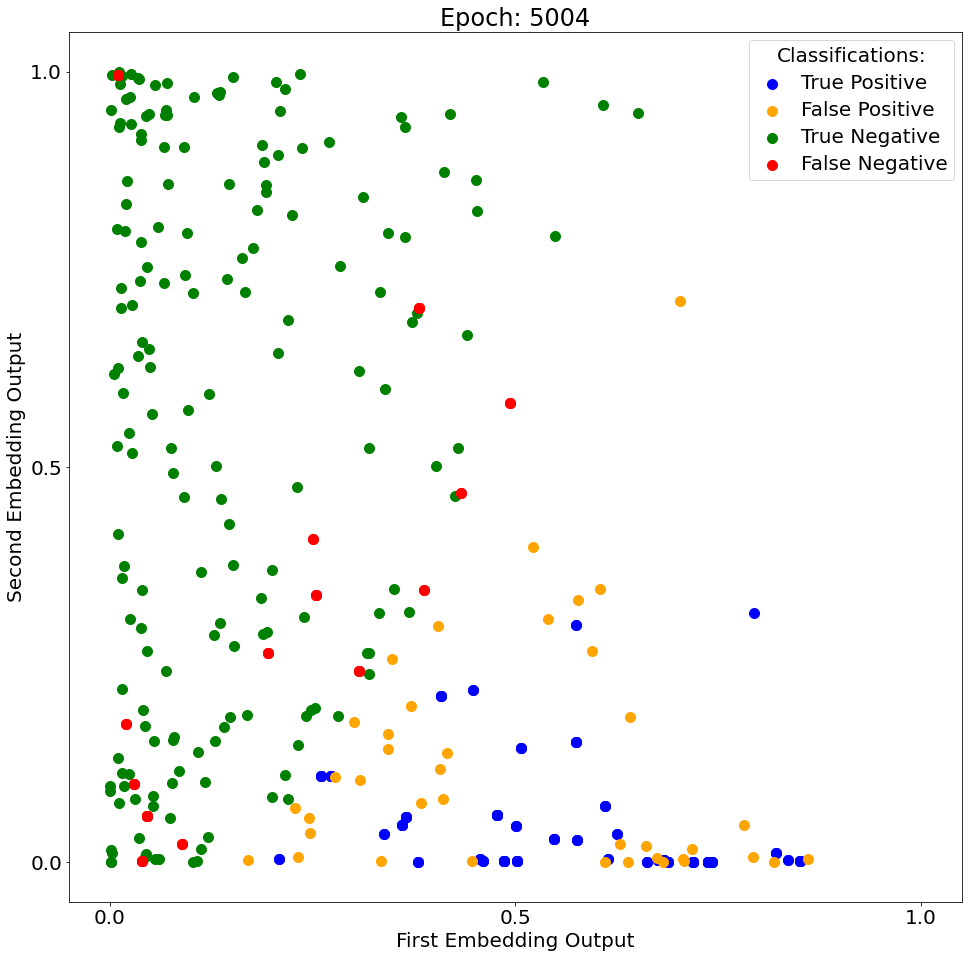

Epoch: 5004  Accuracy: 0.780549  FP: 39  TP: 133  TPR: 0.730769  TNR: 0.821918


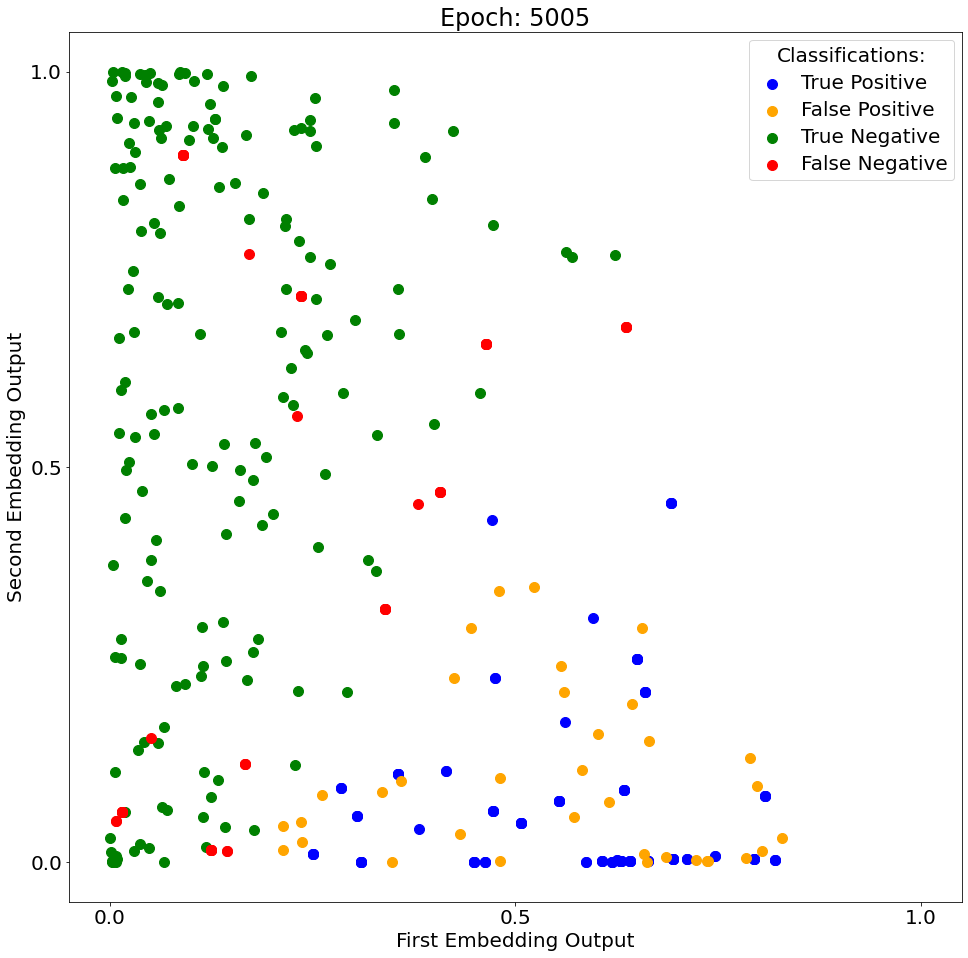

Epoch: 5005  Accuracy: 0.766667  FP: 35  TP: 127  TPR: 0.693989  TNR: 0.830918


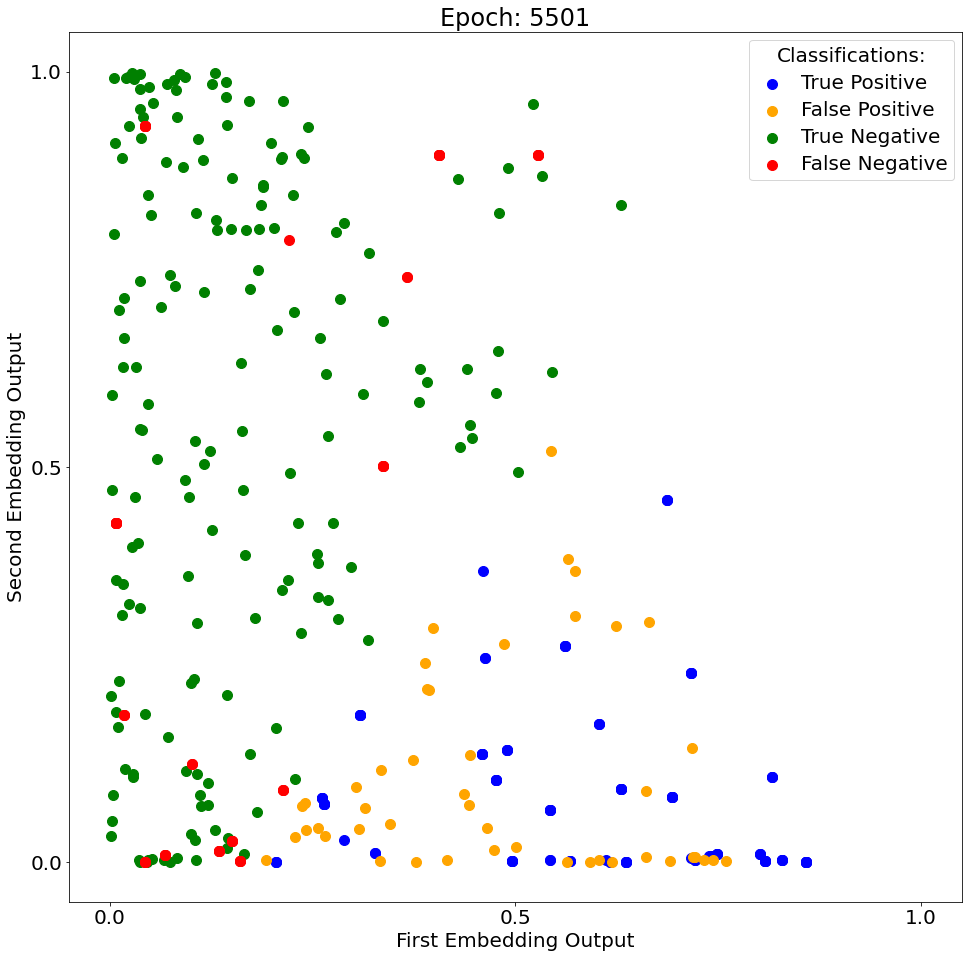

Epoch: 5501  Accuracy: 0.735661  FP: 46  TP: 122  TPR: 0.670330  TNR: 0.789954


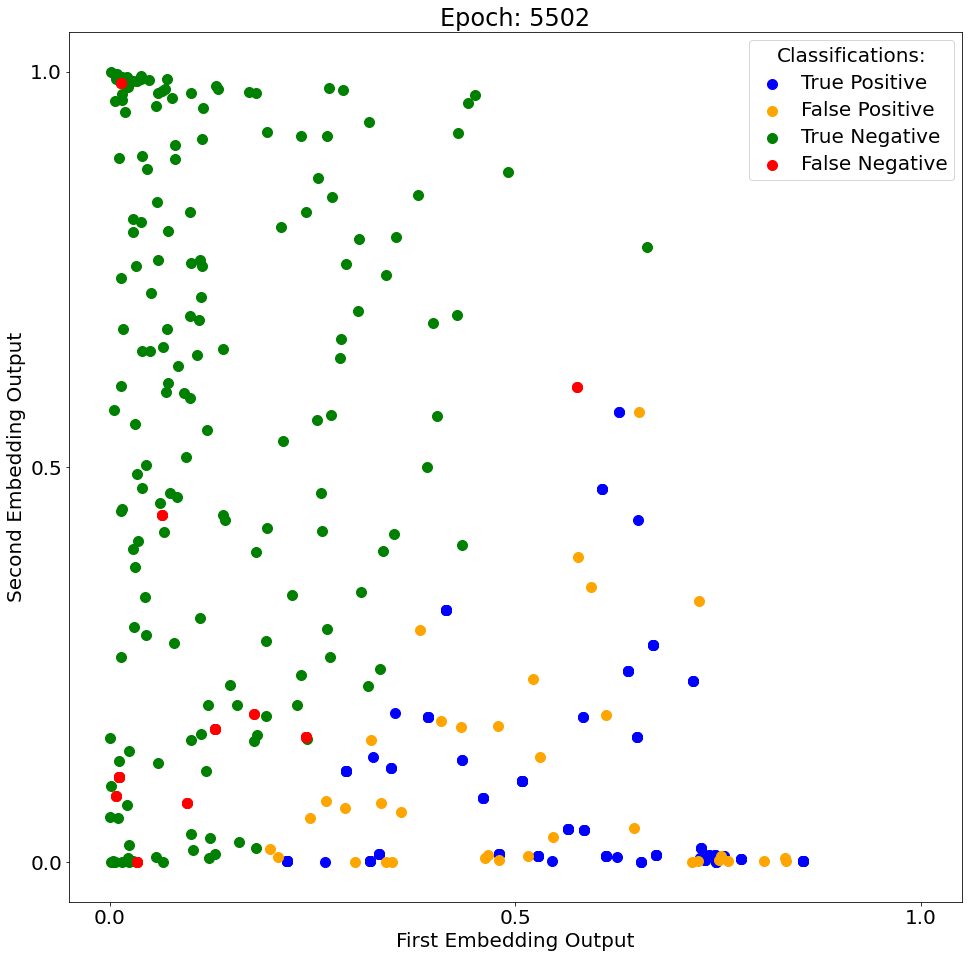

Epoch: 5502  Accuracy: 0.807292  FP: 36  TP: 140  TPR: 0.786517  TNR: 0.825243


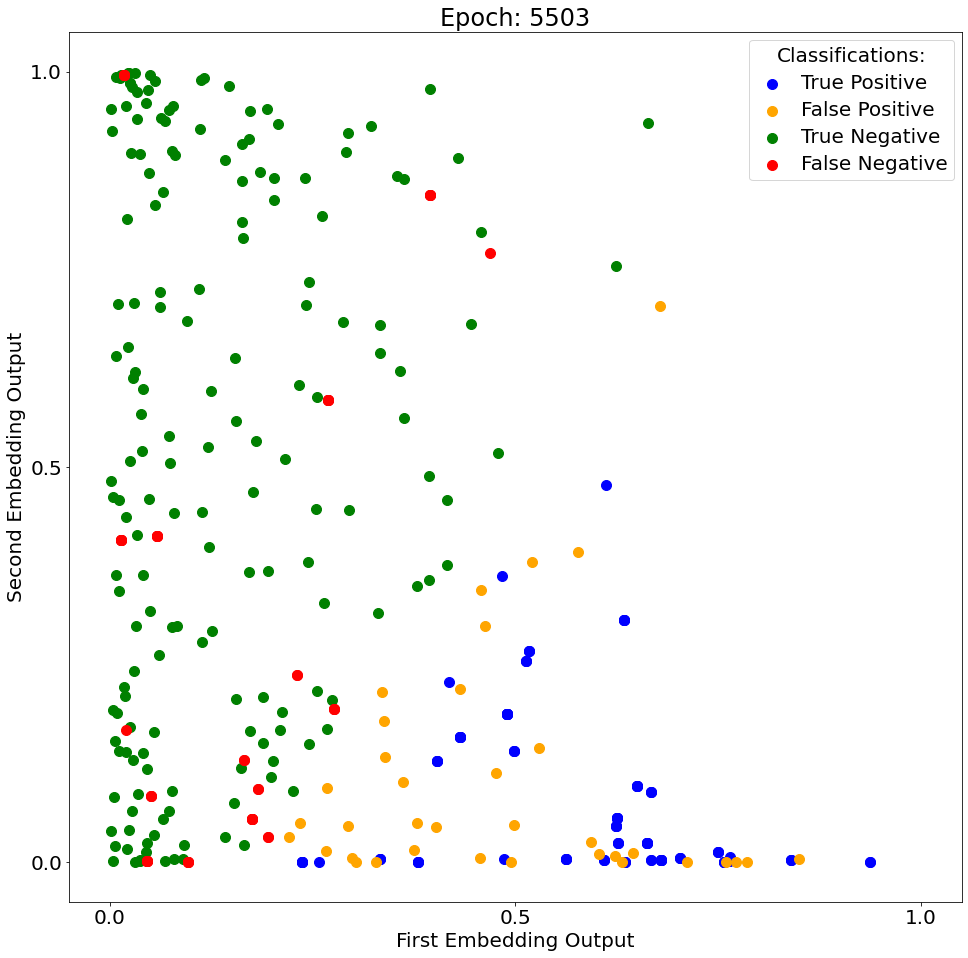

Epoch: 5503  Accuracy: 0.757180  FP: 36  TP: 116  TPR: 0.670520  TNR: 0.828571


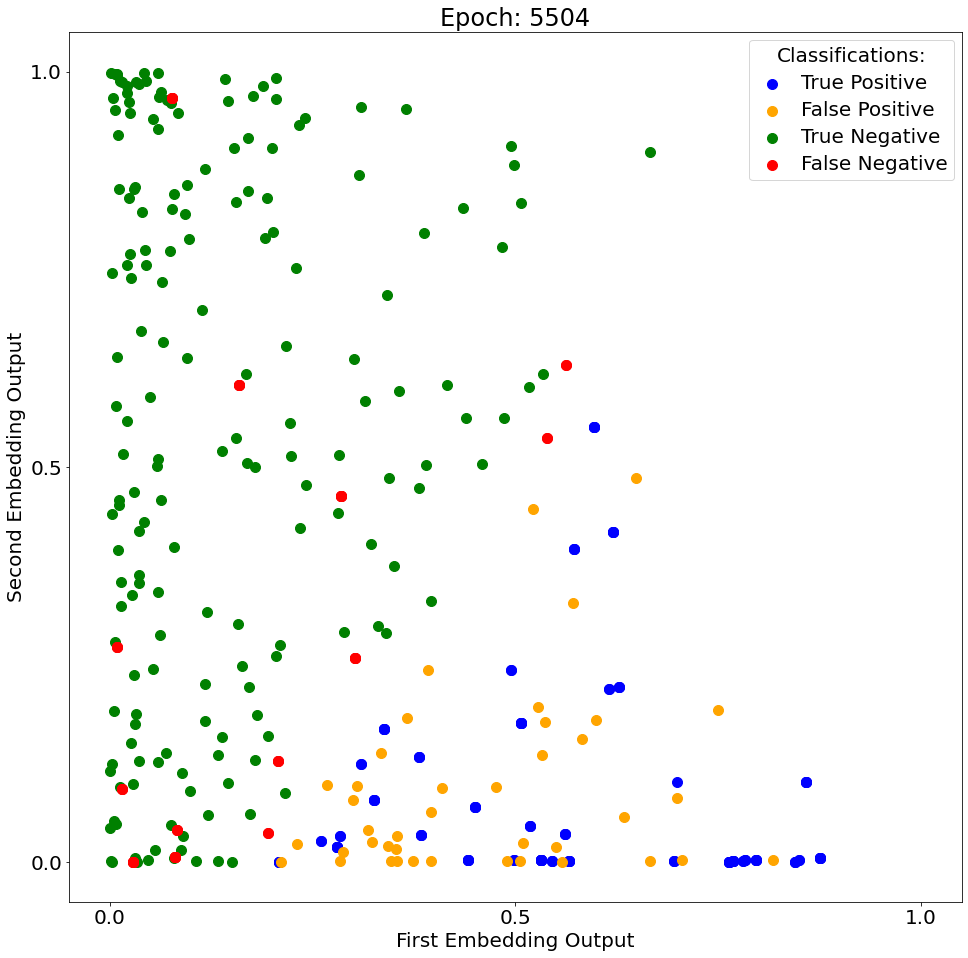

Epoch: 5504  Accuracy: 0.780549  FP: 41  TP: 135  TPR: 0.741758  TNR: 0.812785


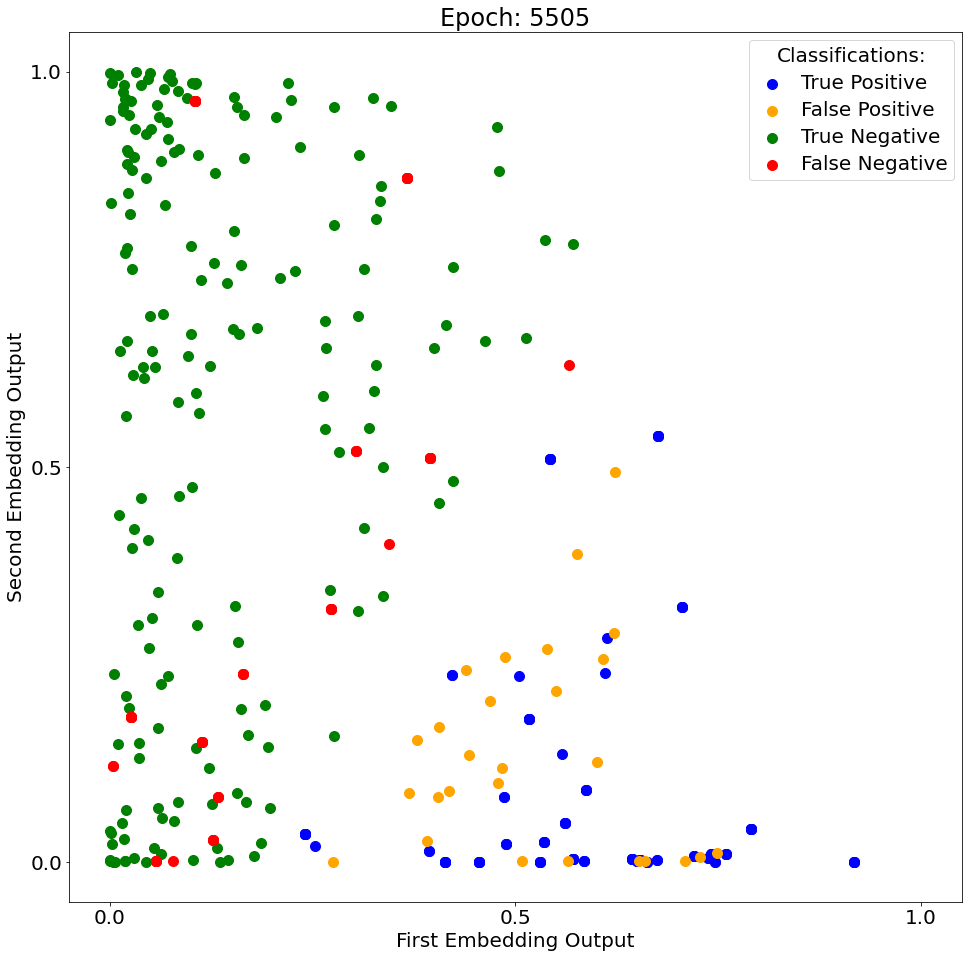

Epoch: 5505  Accuracy: 0.776923  FP: 27  TP: 123  TPR: 0.672131  TNR: 0.869565


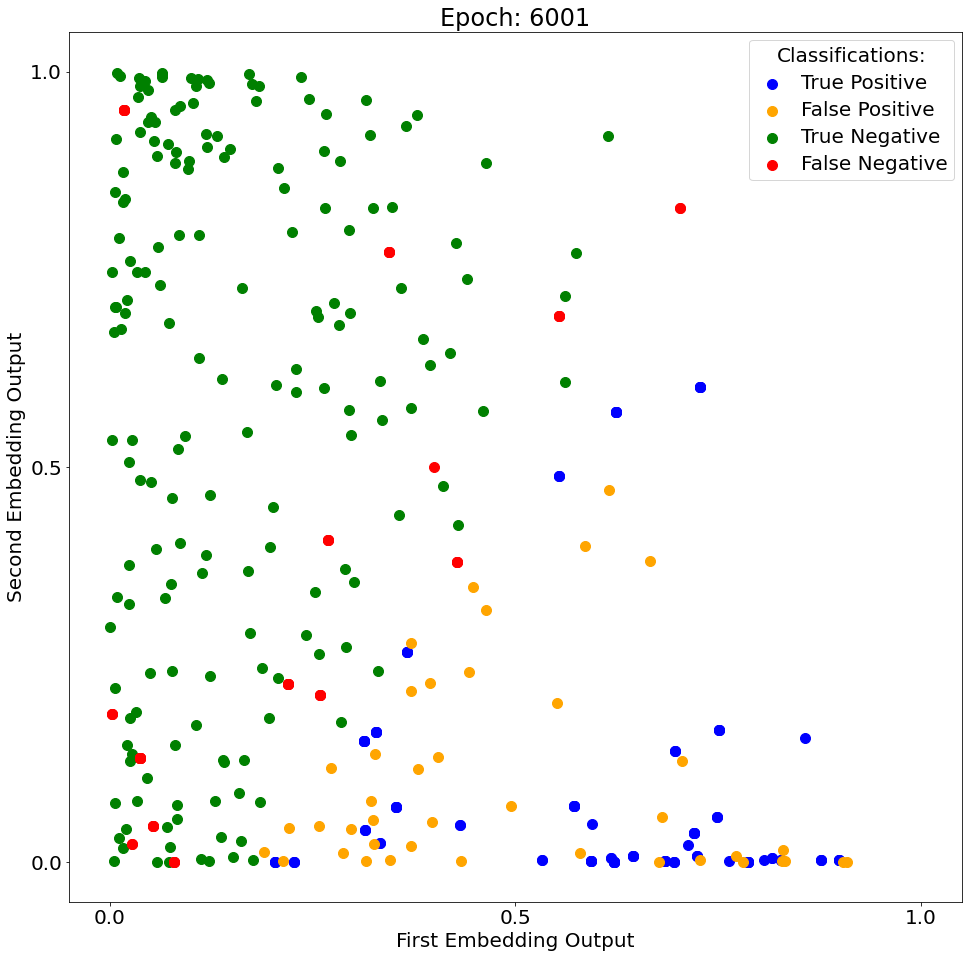

Epoch: 6001  Accuracy: 0.755611  FP: 41  TP: 125  TPR: 0.686813  TNR: 0.812785


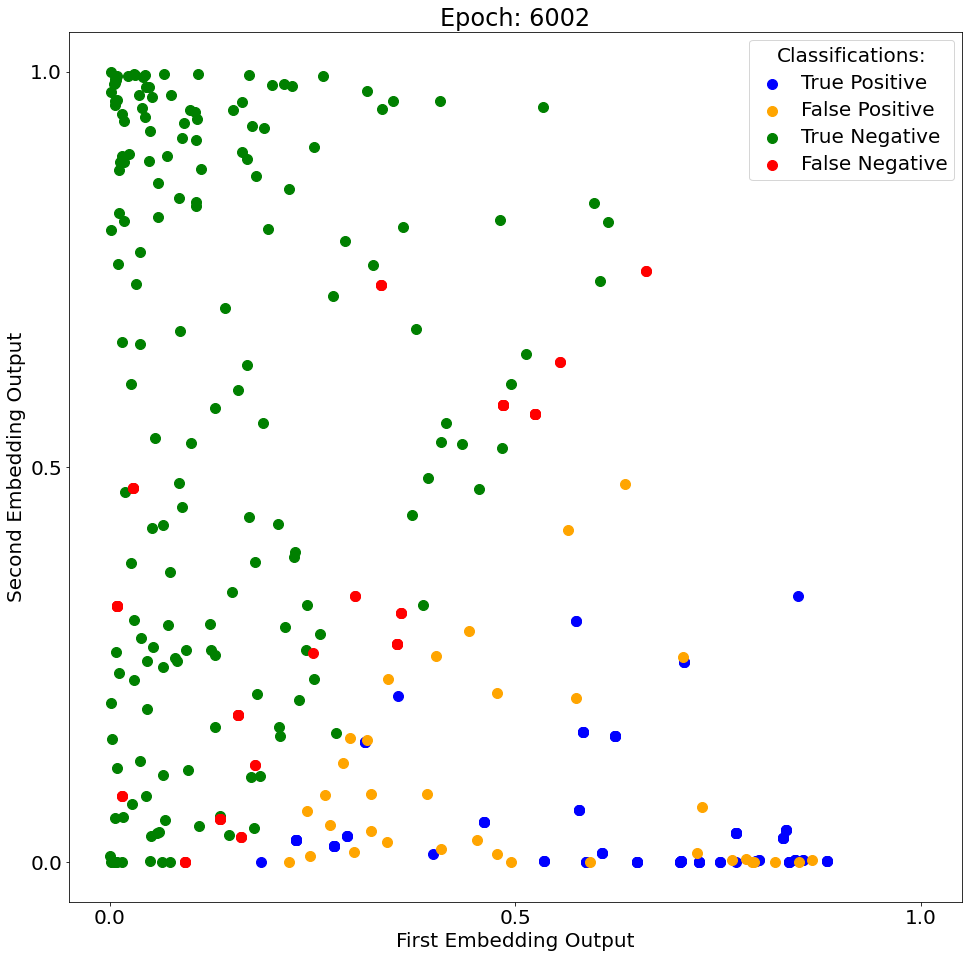

Epoch: 6002  Accuracy: 0.742188  FP: 35  TP: 114  TPR: 0.640449  TNR: 0.830097


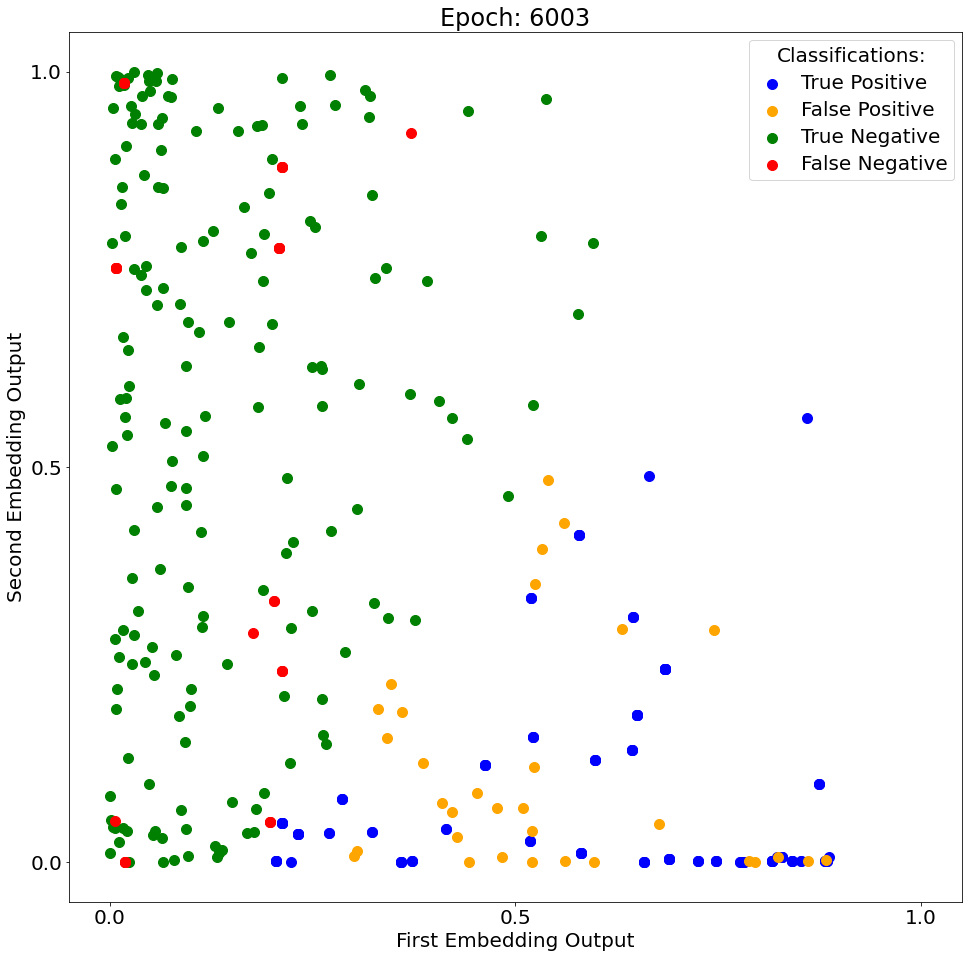

Epoch: 6003  Accuracy: 0.825065  FP: 32  TP: 138  TPR: 0.797688  TNR: 0.847619


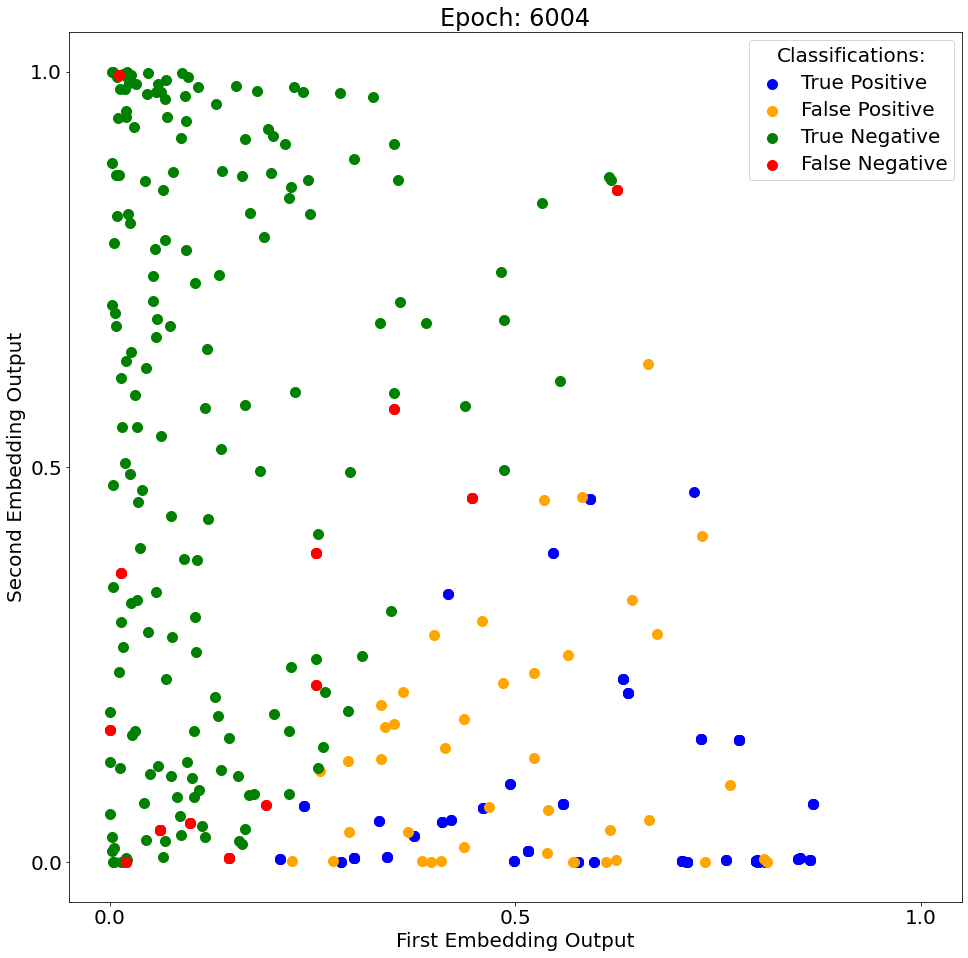

Epoch: 6004  Accuracy: 0.773067  FP: 42  TP: 133  TPR: 0.730769  TNR: 0.808219


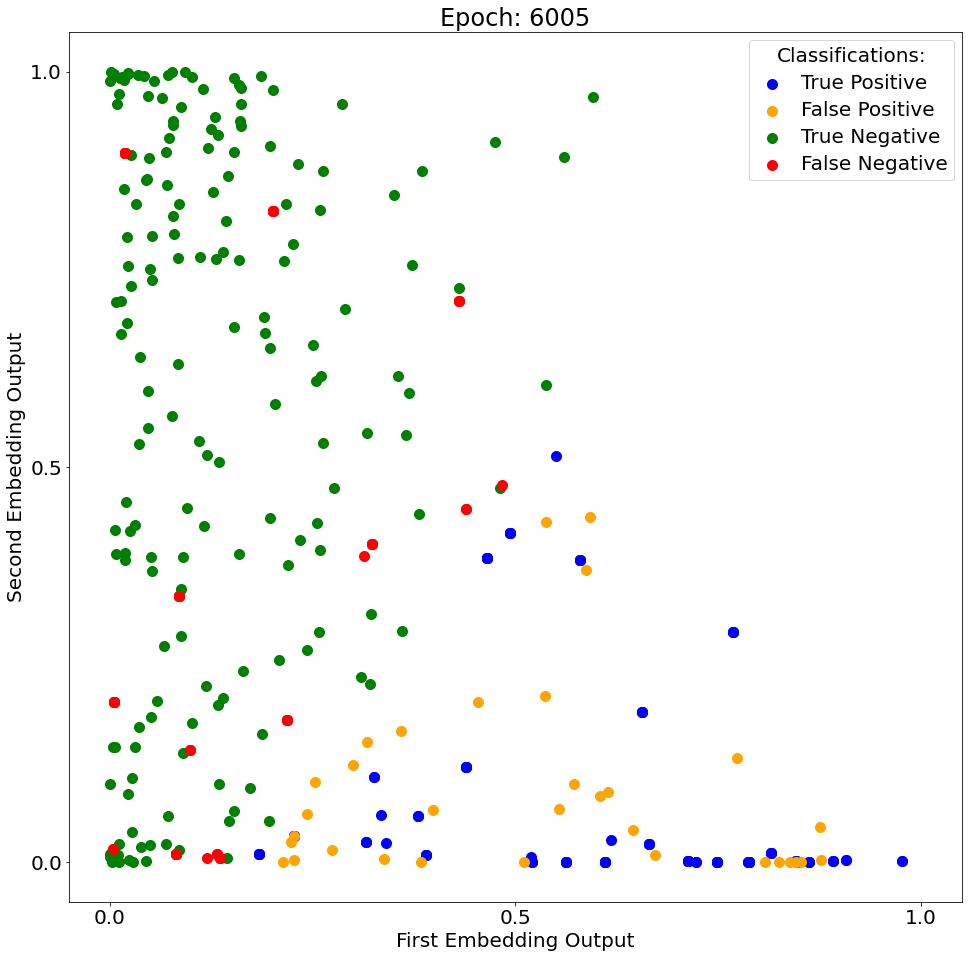

Epoch: 6005  Accuracy: 0.756410  FP: 33  TP: 121  TPR: 0.661202  TNR: 0.840580


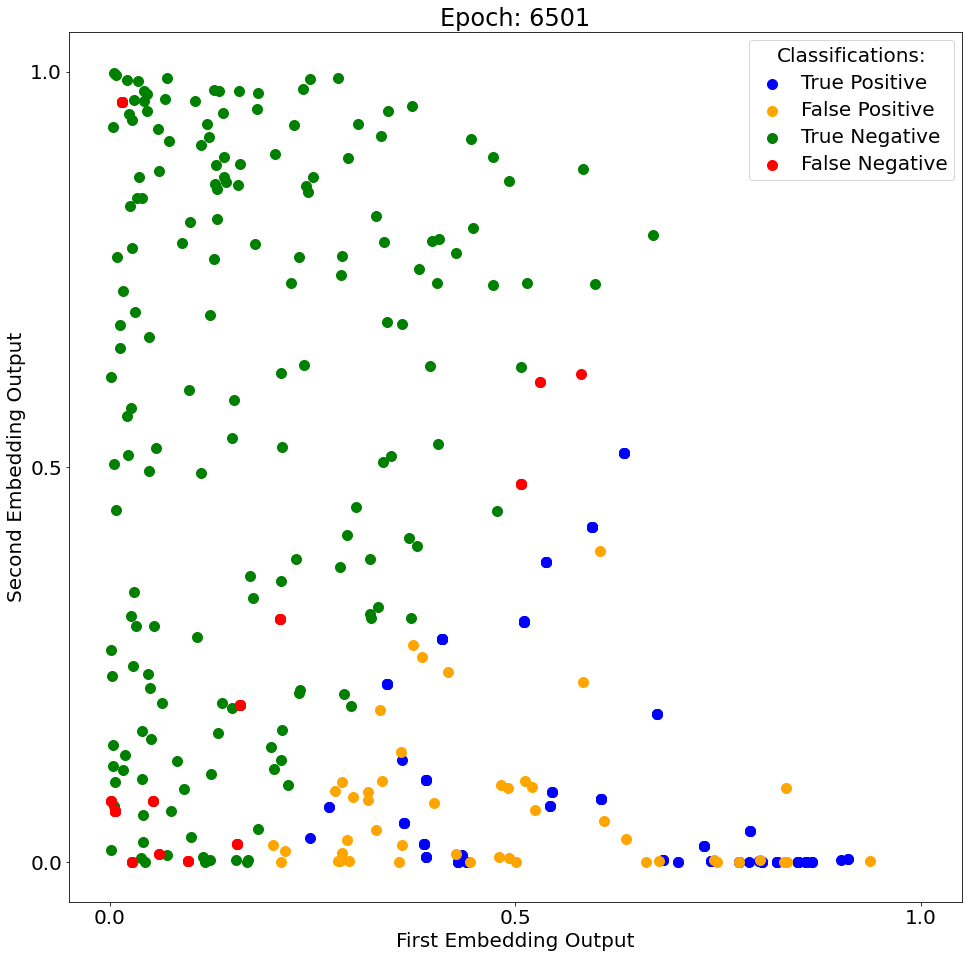

Epoch: 6501  Accuracy: 0.750623  FP: 47  TP: 129  TPR: 0.708791  TNR: 0.785388


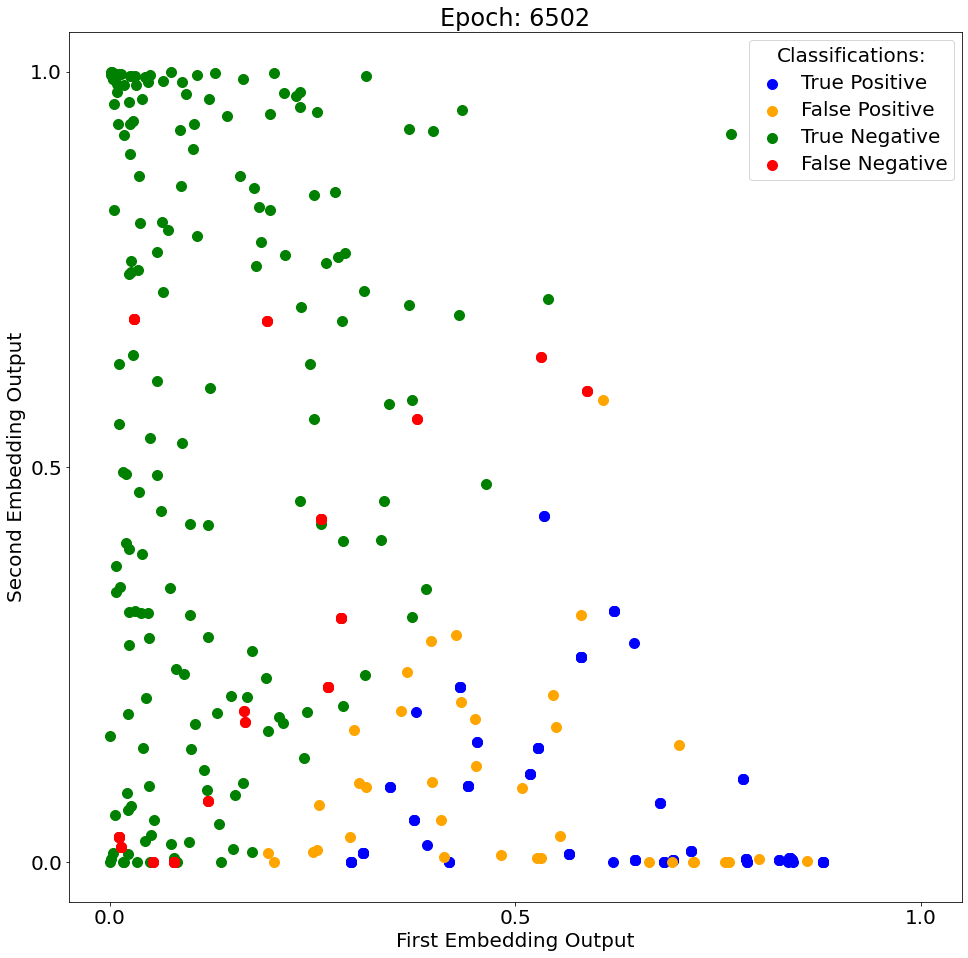

Epoch: 6502  Accuracy: 0.750000  FP: 37  TP: 119  TPR: 0.668539  TNR: 0.820388


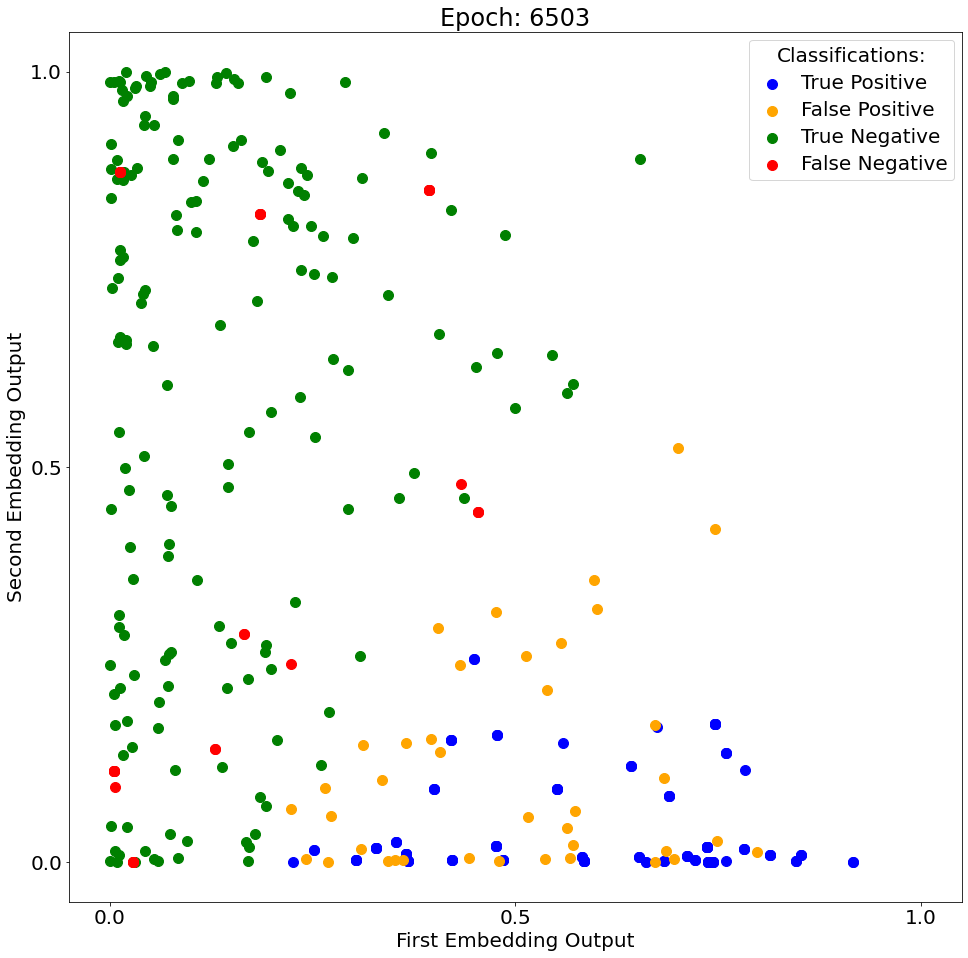

Epoch: 6503  Accuracy: 0.809399  FP: 39  TP: 139  TPR: 0.803468  TNR: 0.814286


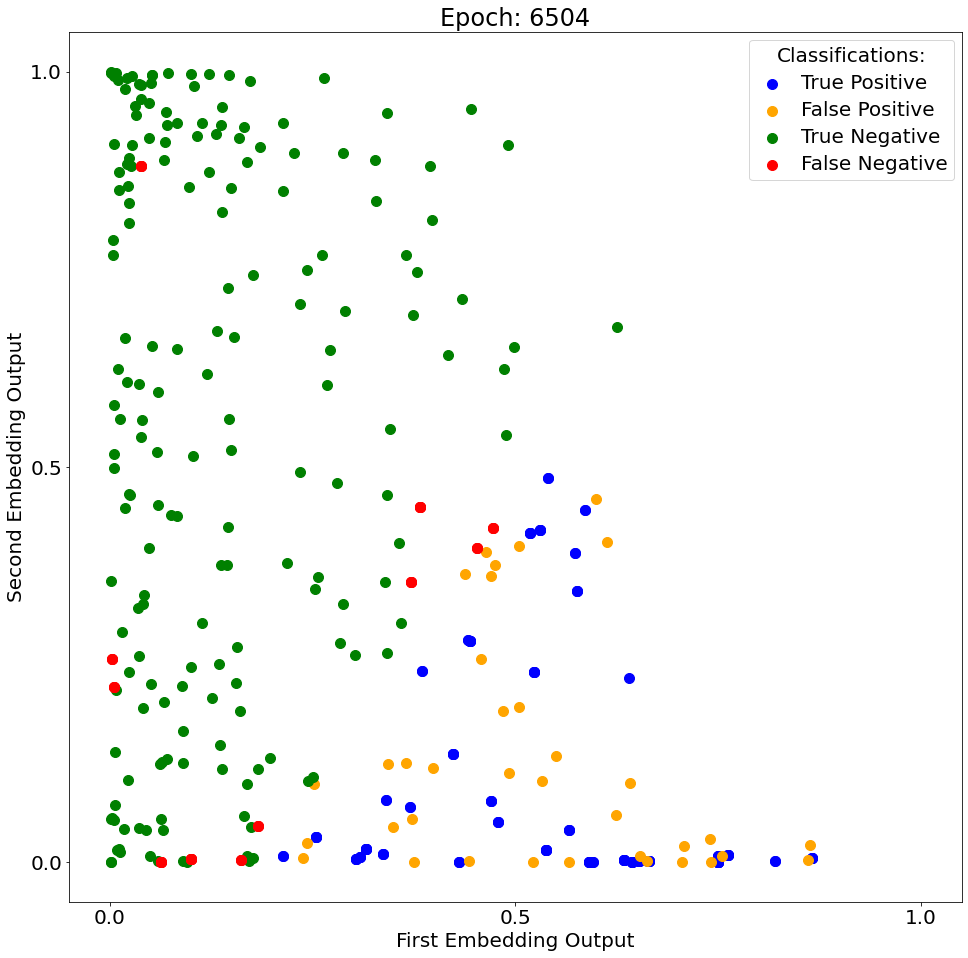

Epoch: 6504  Accuracy: 0.802993  FP: 36  TP: 139  TPR: 0.763736  TNR: 0.835616


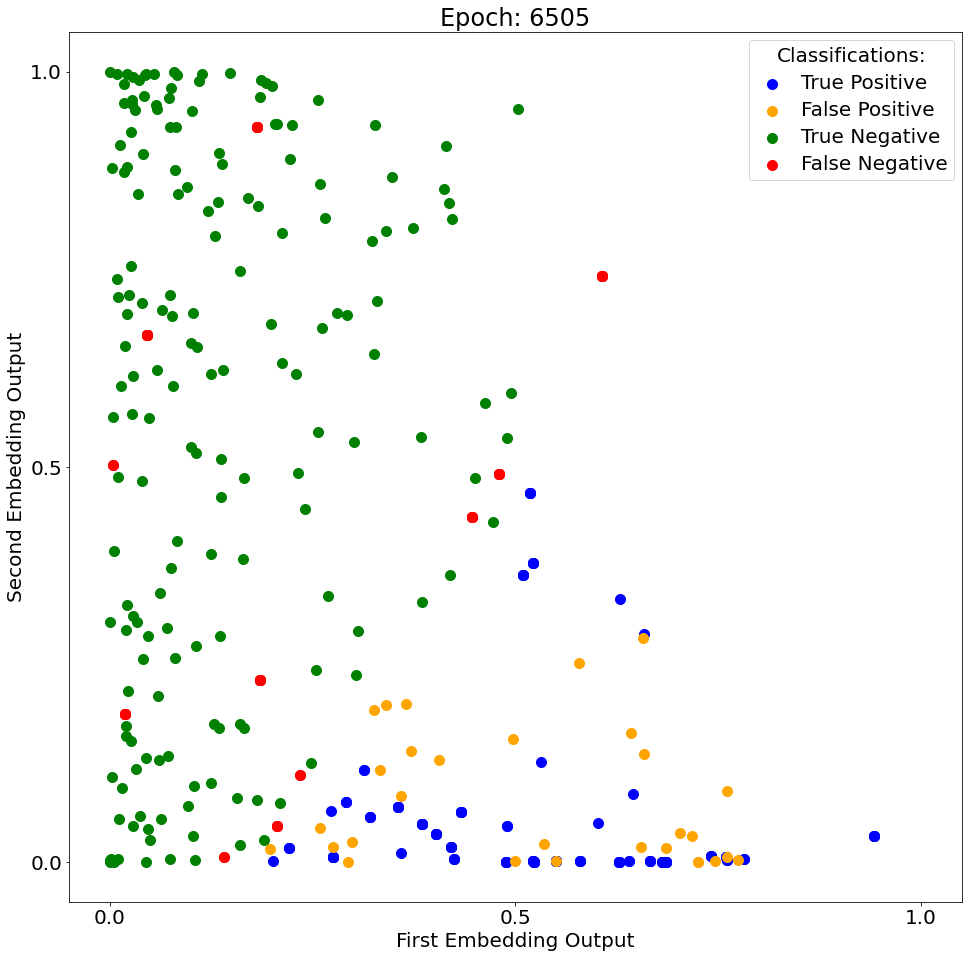

Epoch: 6505  Accuracy: 0.792308  FP: 30  TP: 132  TPR: 0.721311  TNR: 0.855072


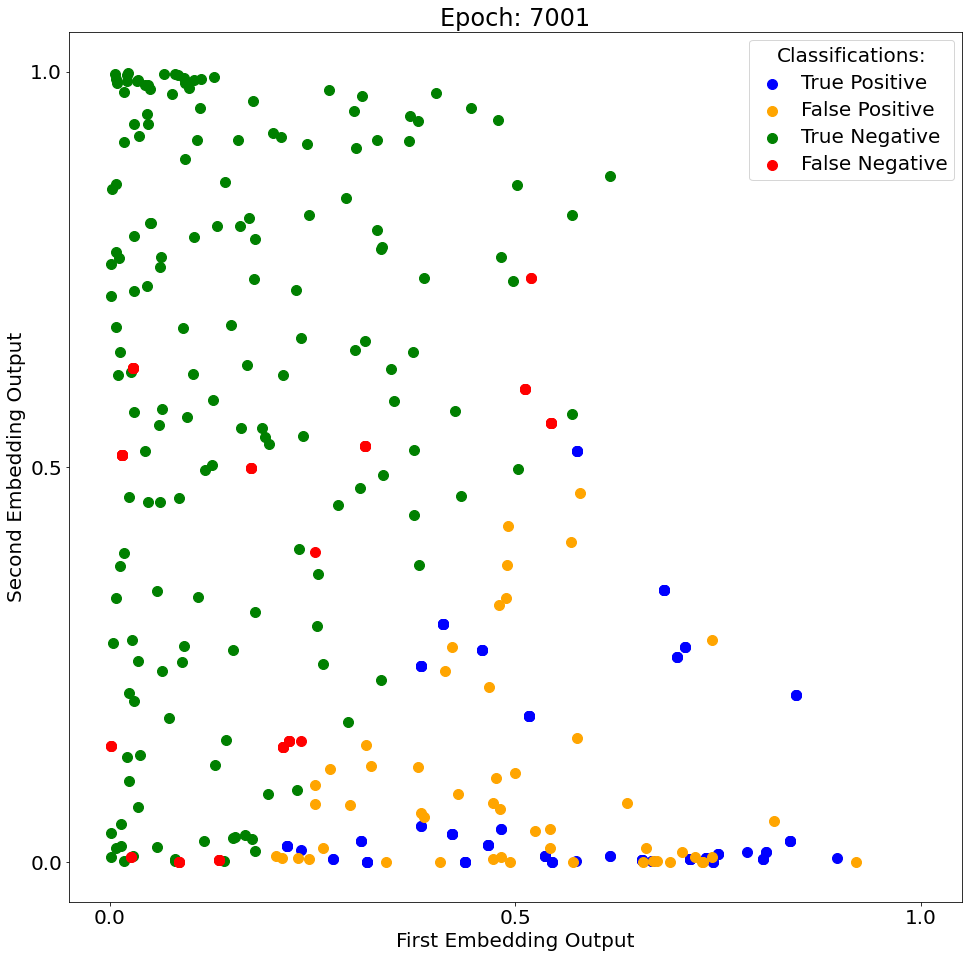

Epoch: 7001  Accuracy: 0.718204  FP: 52  TP: 121  TPR: 0.664835  TNR: 0.762557


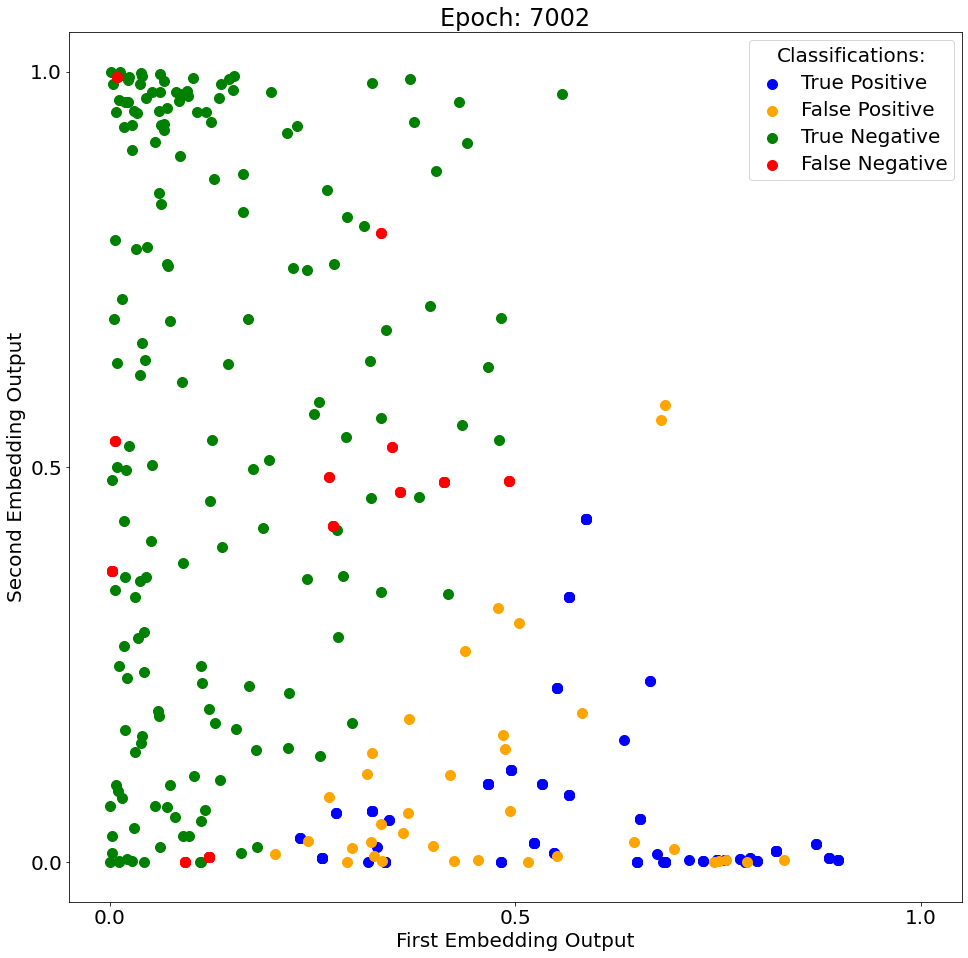

Epoch: 7002  Accuracy: 0.783854  FP: 36  TP: 131  TPR: 0.735955  TNR: 0.825243


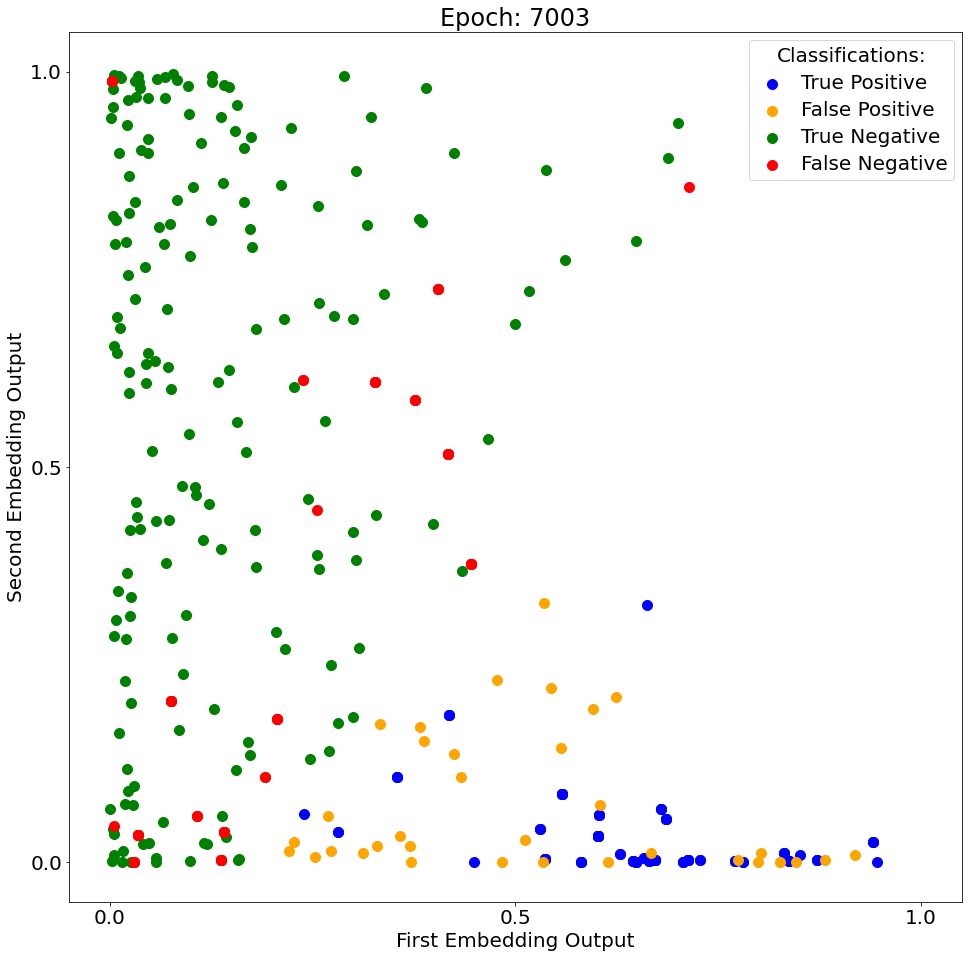

Epoch: 7003  Accuracy: 0.738903  FP: 34  TP: 107  TPR: 0.618497  TNR: 0.838095


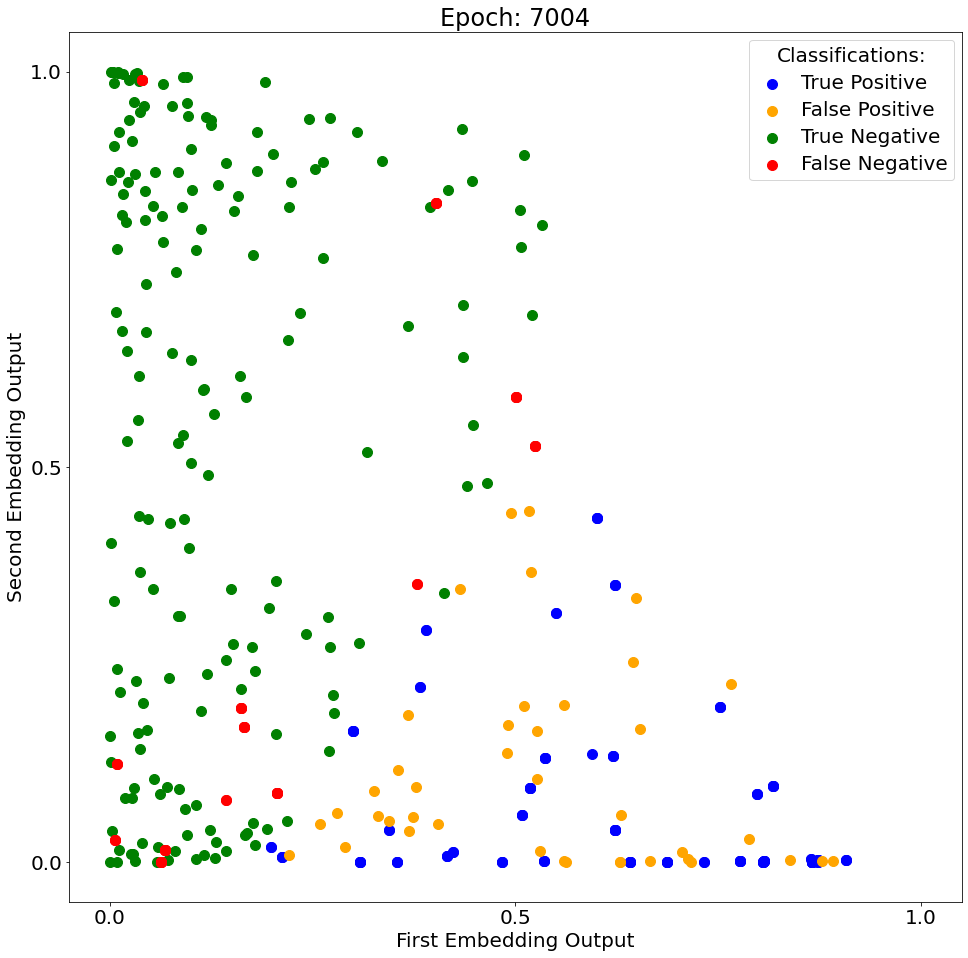

Epoch: 7004  Accuracy: 0.768080  FP: 41  TP: 130  TPR: 0.714286  TNR: 0.812785


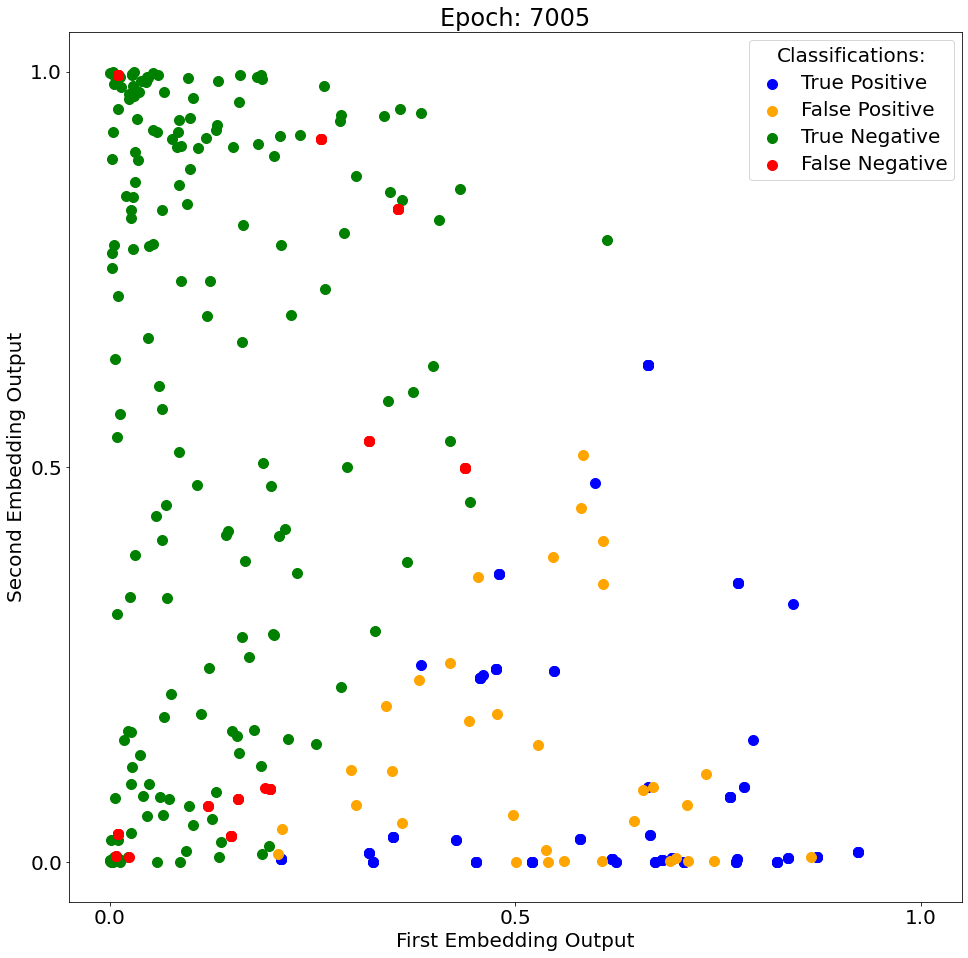

Epoch: 7005  Accuracy: 0.776923  FP: 34  TP: 130  TPR: 0.710383  TNR: 0.835749


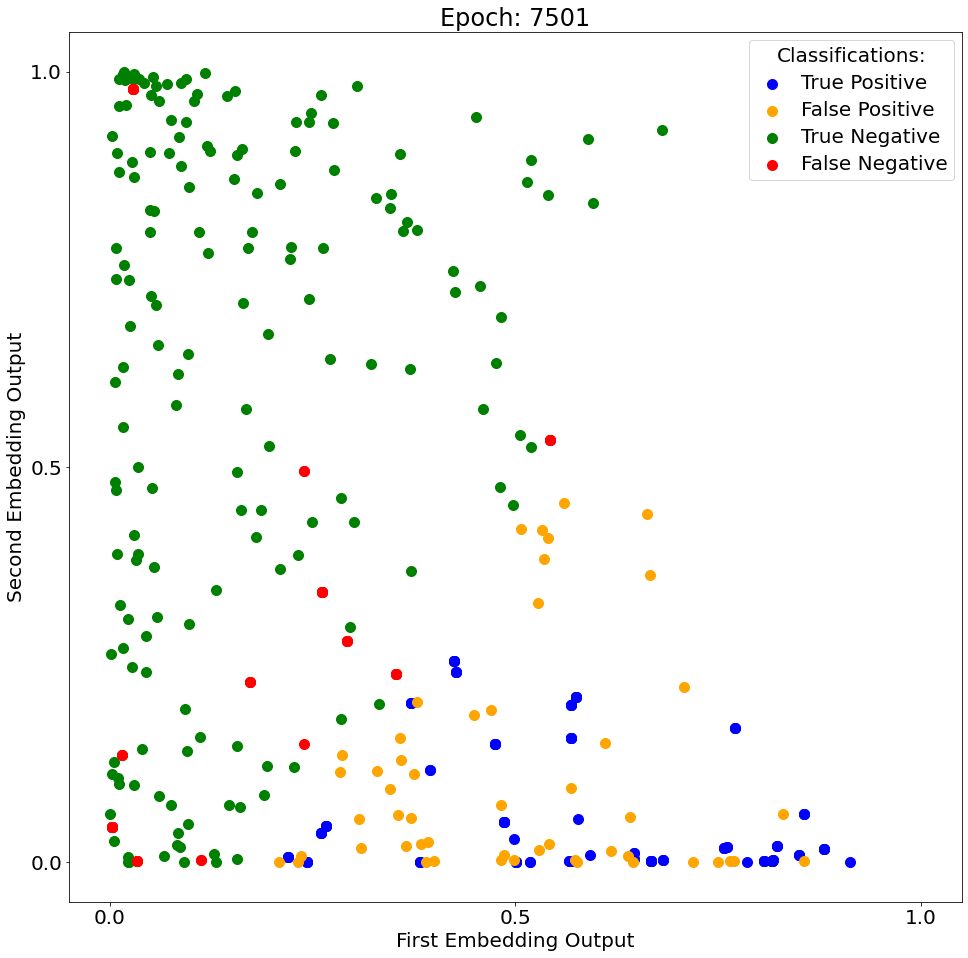

Epoch: 7501  Accuracy: 0.750623  FP: 51  TP: 133  TPR: 0.730769  TNR: 0.767123


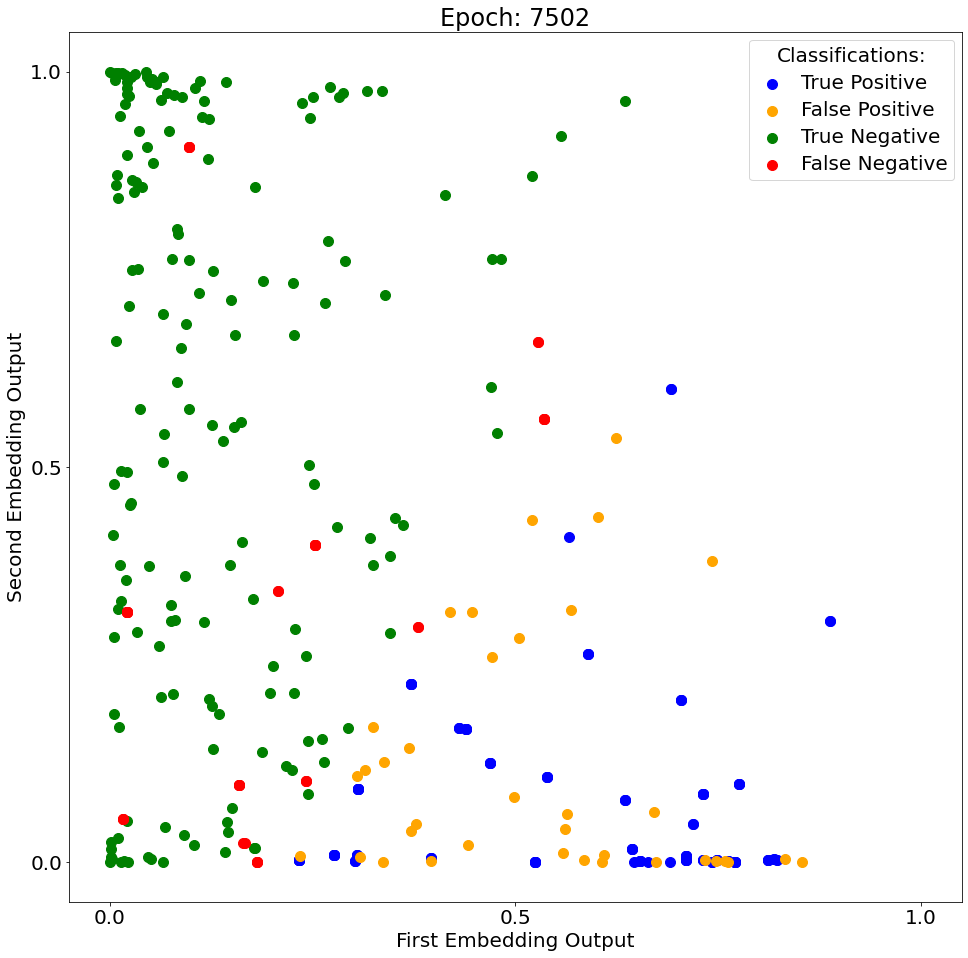

Epoch: 7502  Accuracy: 0.791667  FP: 36  TP: 134  TPR: 0.752809  TNR: 0.825243


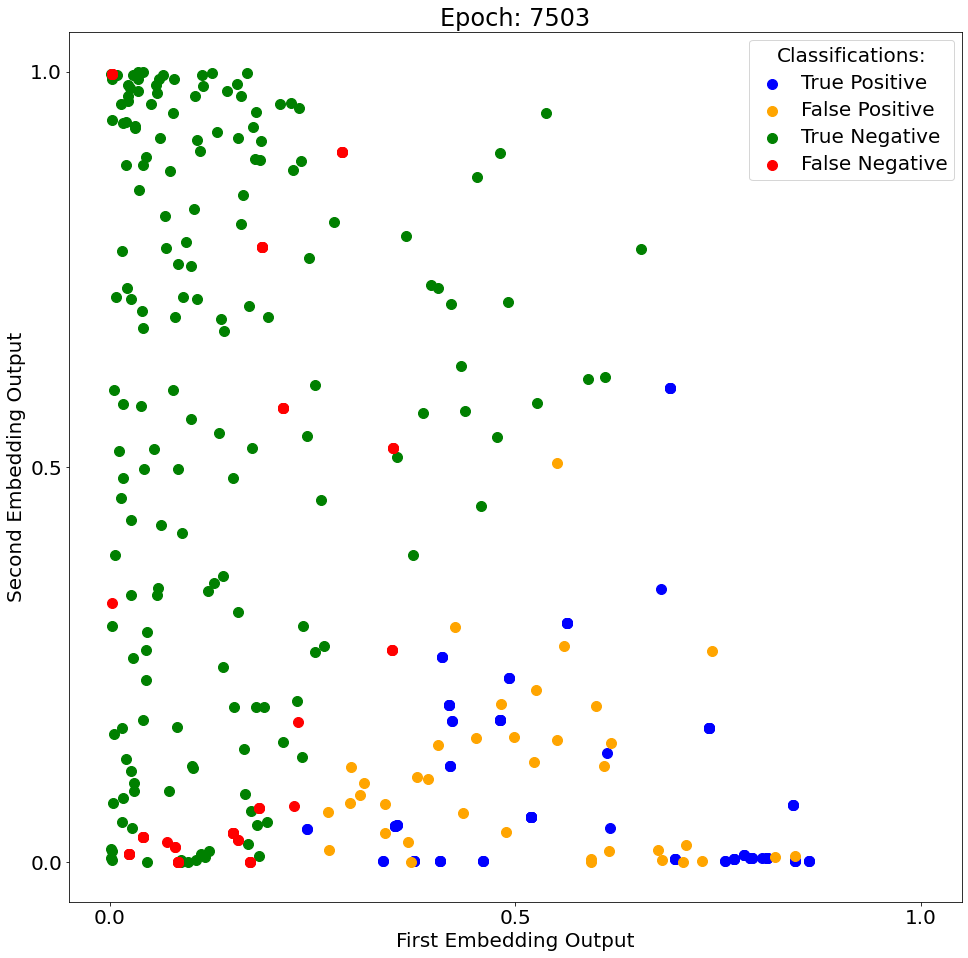

Epoch: 7503  Accuracy: 0.738903  FP: 38  TP: 111  TPR: 0.641618  TNR: 0.819048


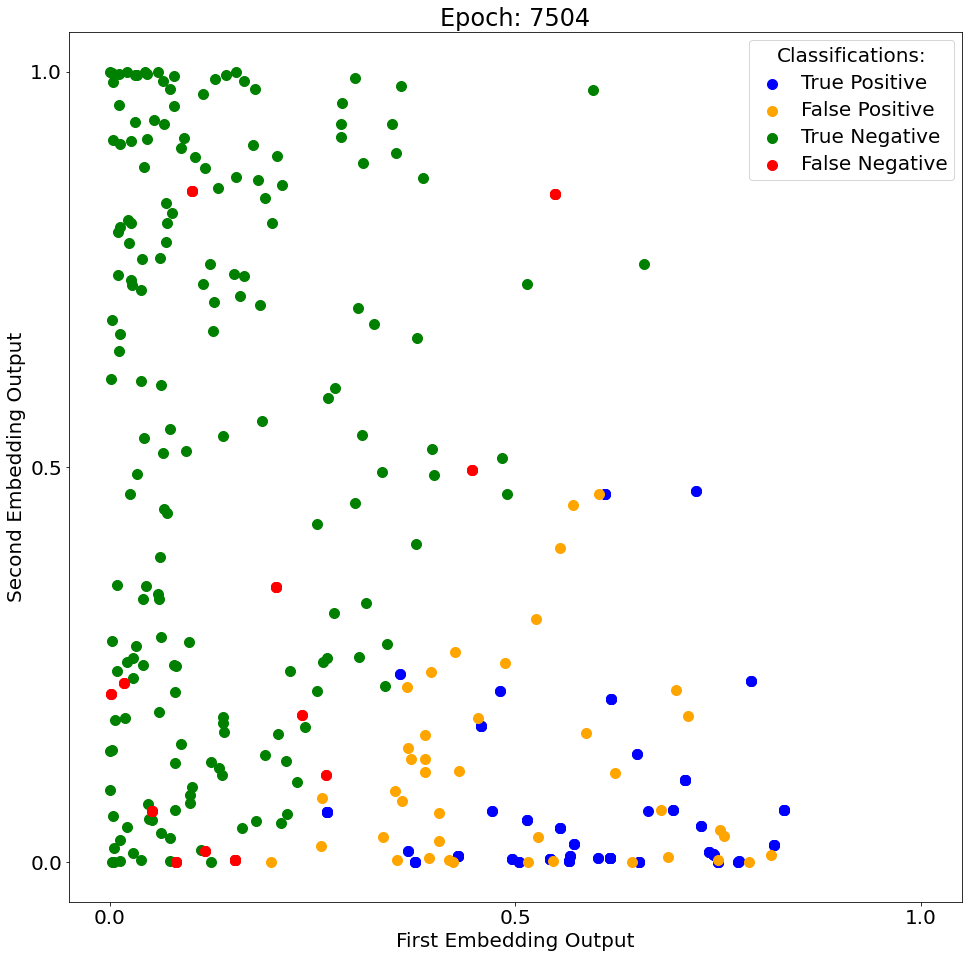

Epoch: 7504  Accuracy: 0.785536  FP: 42  TP: 138  TPR: 0.758242  TNR: 0.808219


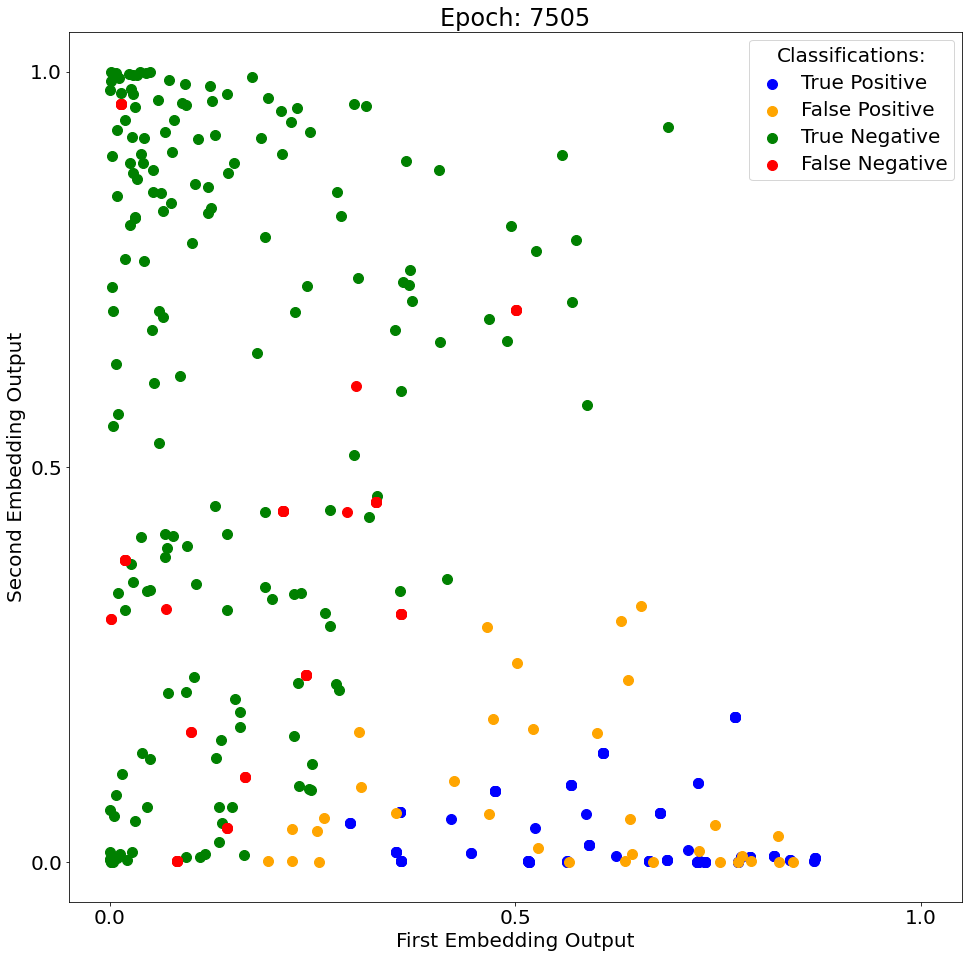

Epoch: 7505  Accuracy: 0.764103  FP: 34  TP: 125  TPR: 0.683060  TNR: 0.835749


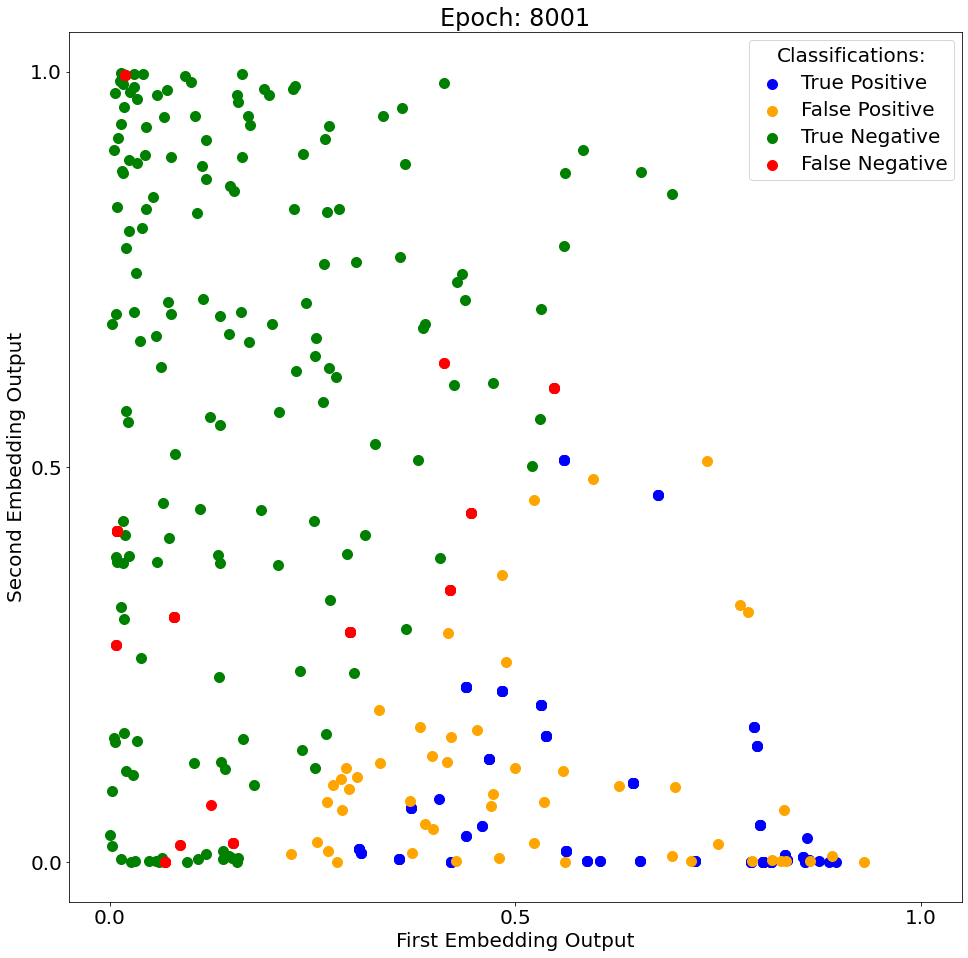

Epoch: 8001  Accuracy: 0.735661  FP: 52  TP: 128  TPR: 0.703297  TNR: 0.762557


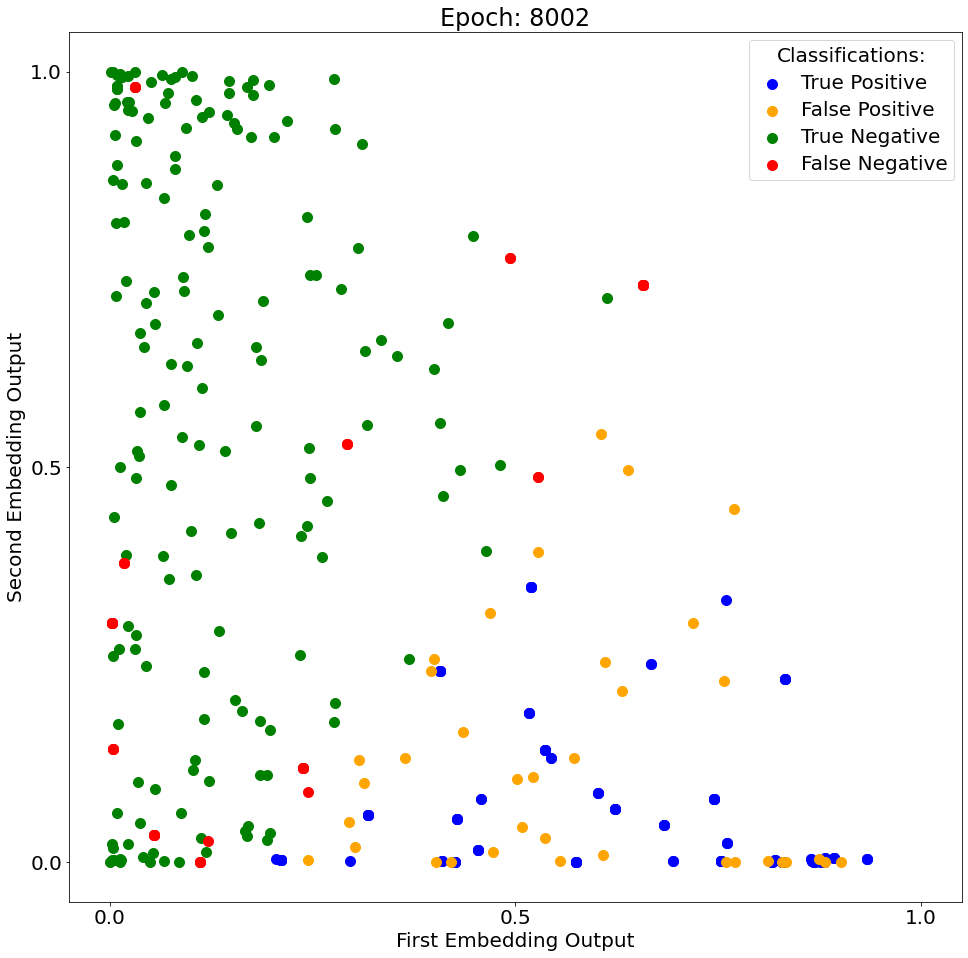

Epoch: 8002  Accuracy: 0.783854  FP: 36  TP: 131  TPR: 0.735955  TNR: 0.825243


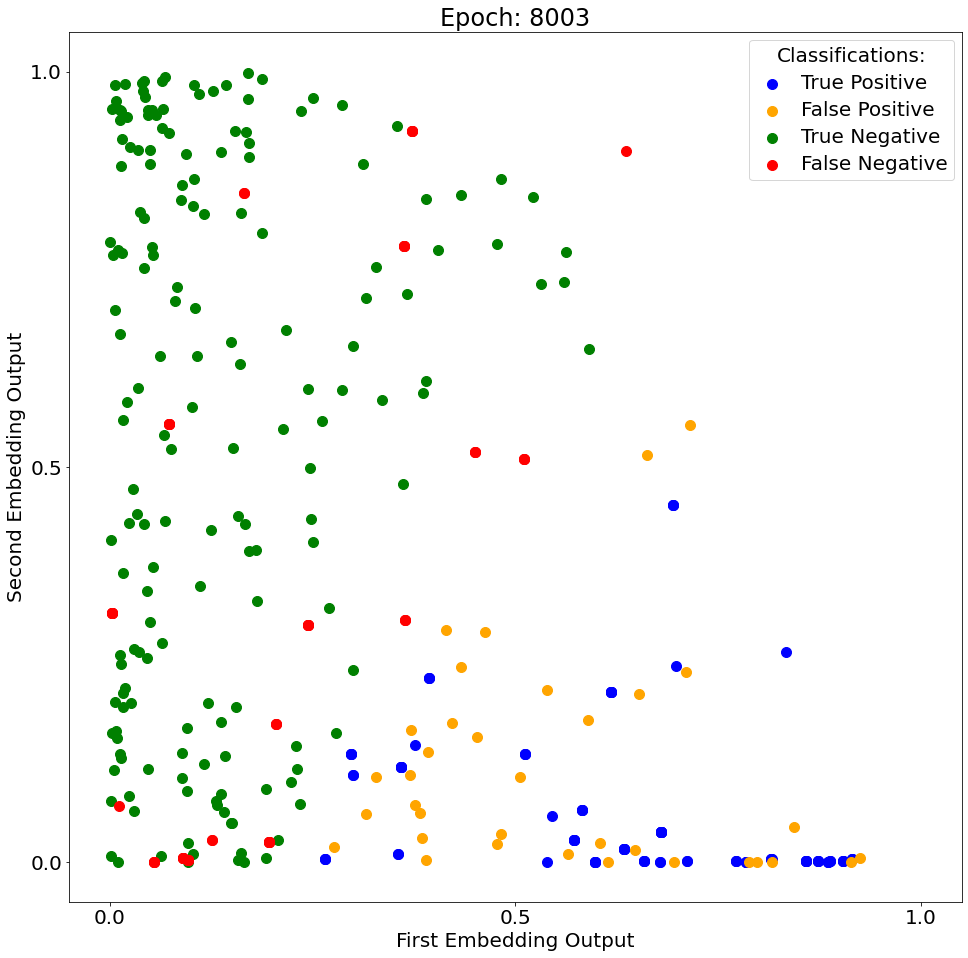

Epoch: 8003  Accuracy: 0.744125  FP: 35  TP: 110  TPR: 0.635838  TNR: 0.833333


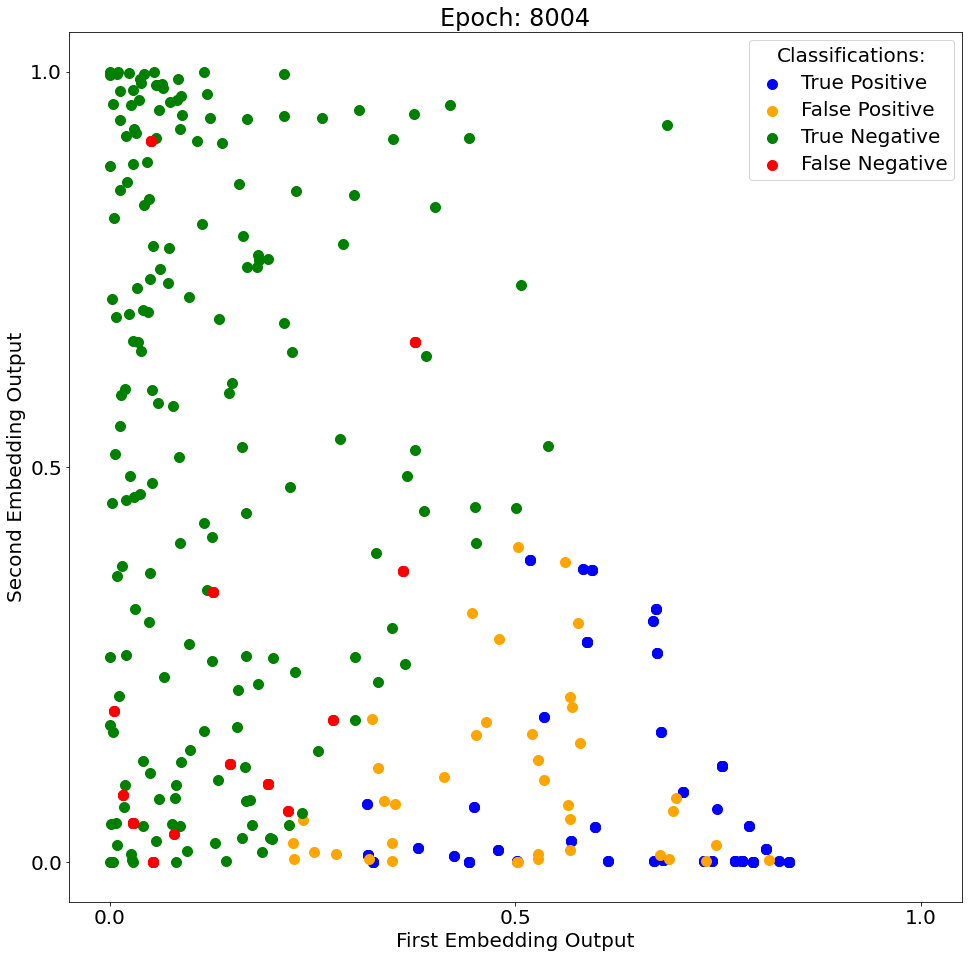

Epoch: 8004  Accuracy: 0.770574  FP: 40  TP: 130  TPR: 0.714286  TNR: 0.817352


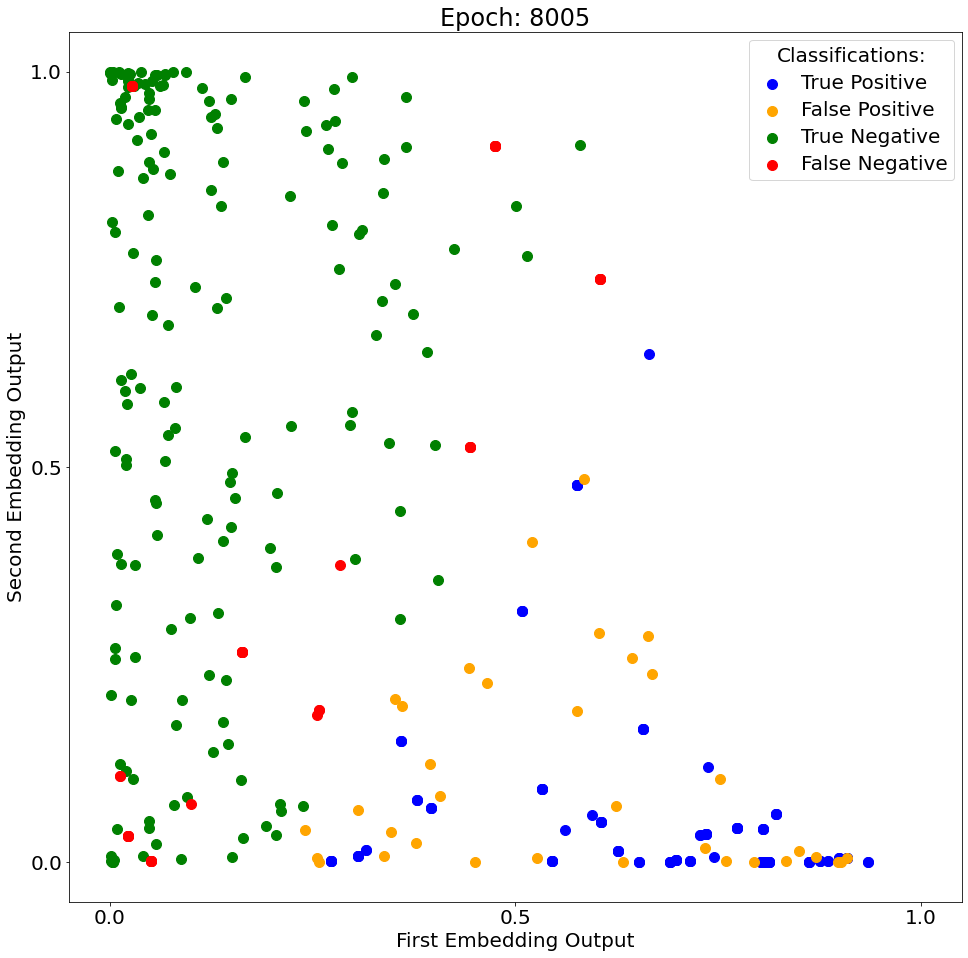

Epoch: 8005  Accuracy: 0.792308  FP: 34  TP: 136  TPR: 0.743169  TNR: 0.835749


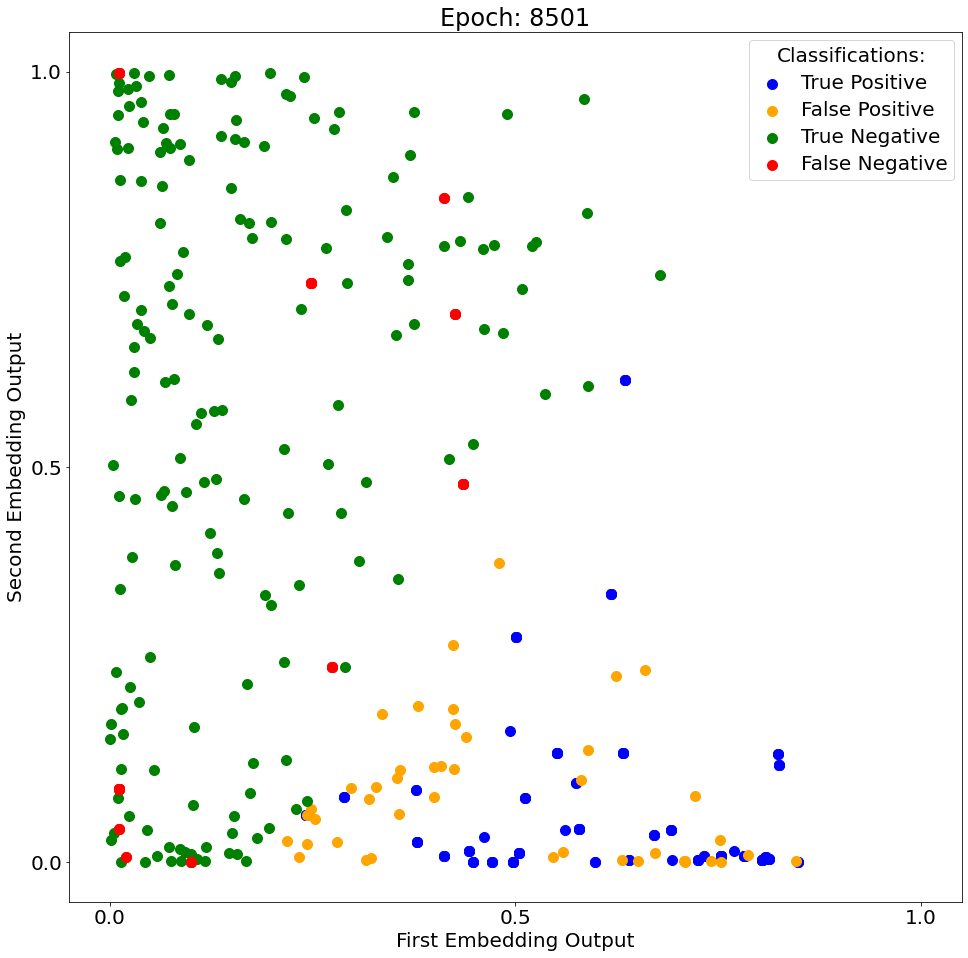

Epoch: 8501  Accuracy: 0.773067  FP: 44  TP: 135  TPR: 0.741758  TNR: 0.799087


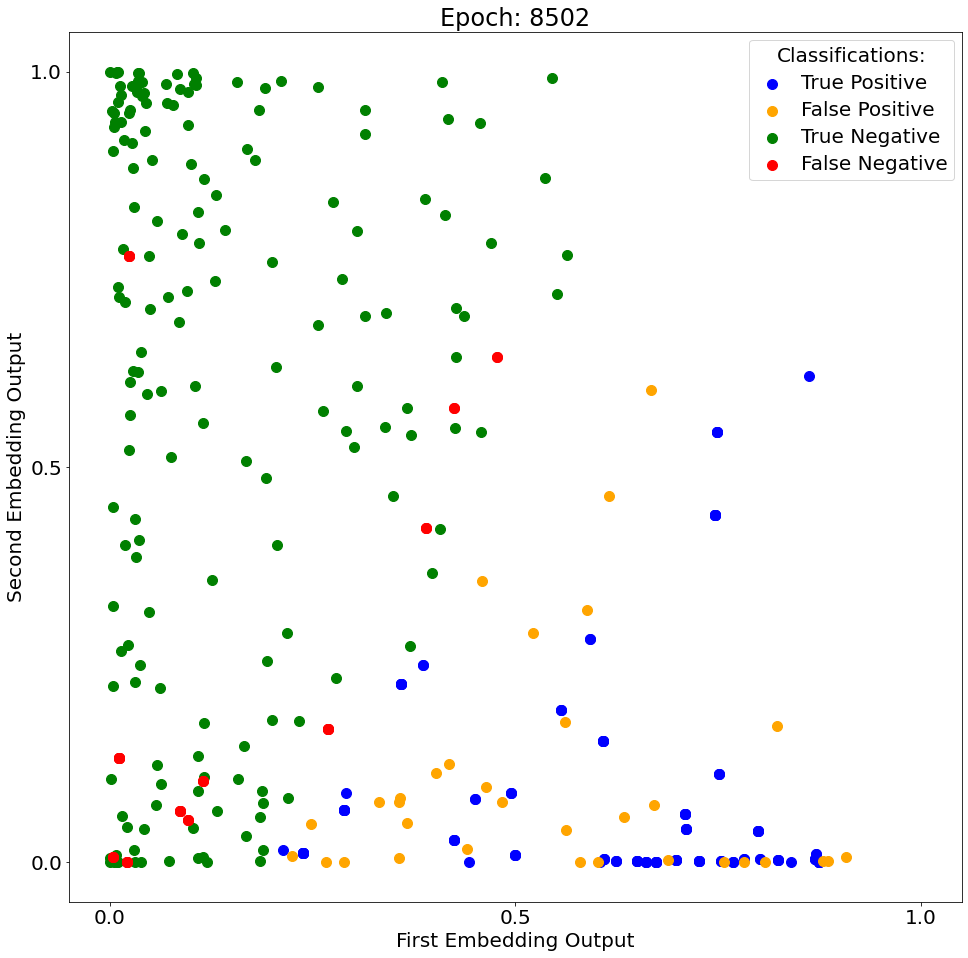

Epoch: 8502  Accuracy: 0.807292  FP: 33  TP: 137  TPR: 0.769663  TNR: 0.839806


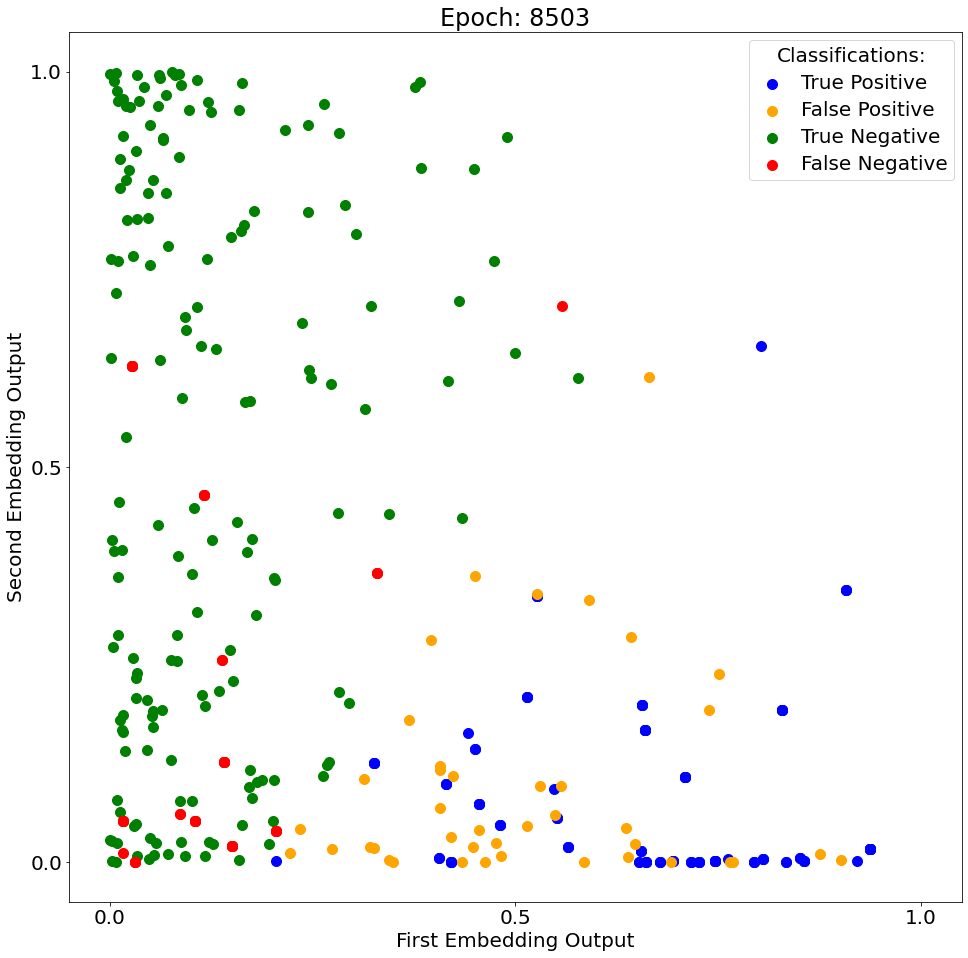

Epoch: 8503  Accuracy: 0.759791  FP: 41  TP: 122  TPR: 0.705202  TNR: 0.804762


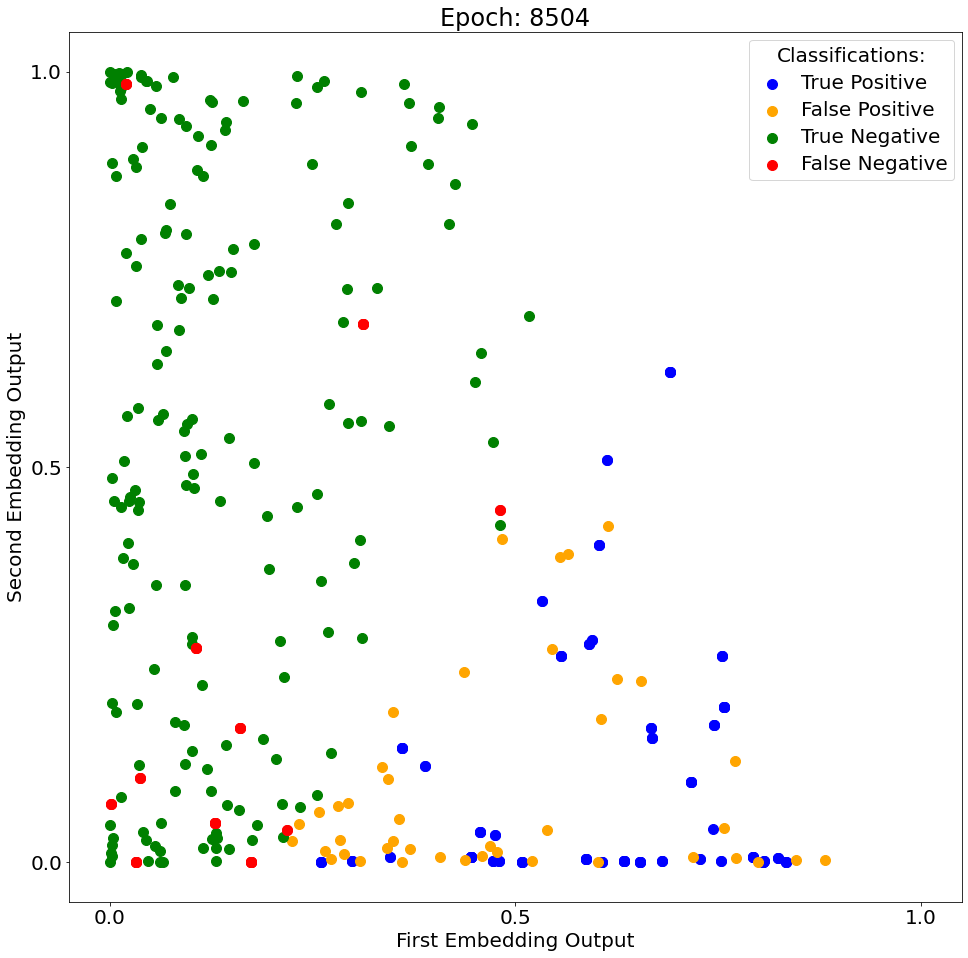

Epoch: 8504  Accuracy: 0.785536  FP: 42  TP: 138  TPR: 0.758242  TNR: 0.808219


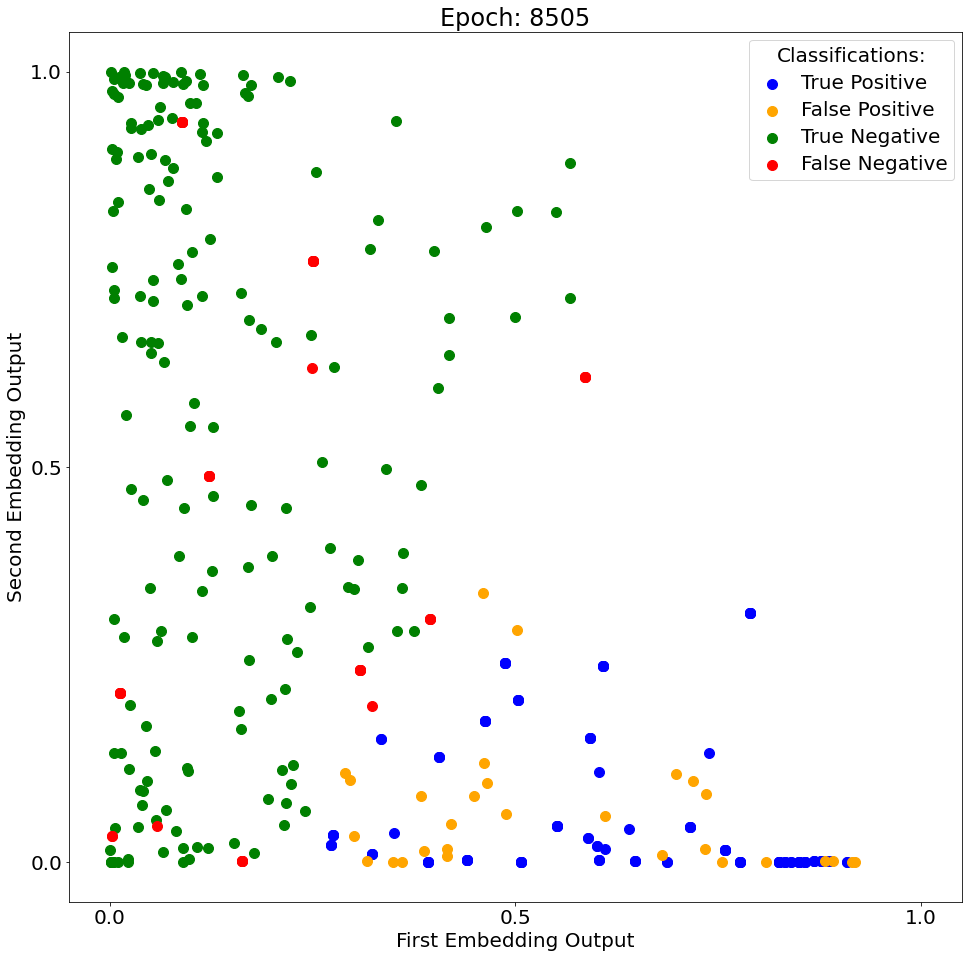

Epoch: 8505  Accuracy: 0.802564  FP: 29  TP: 135  TPR: 0.737705  TNR: 0.859903


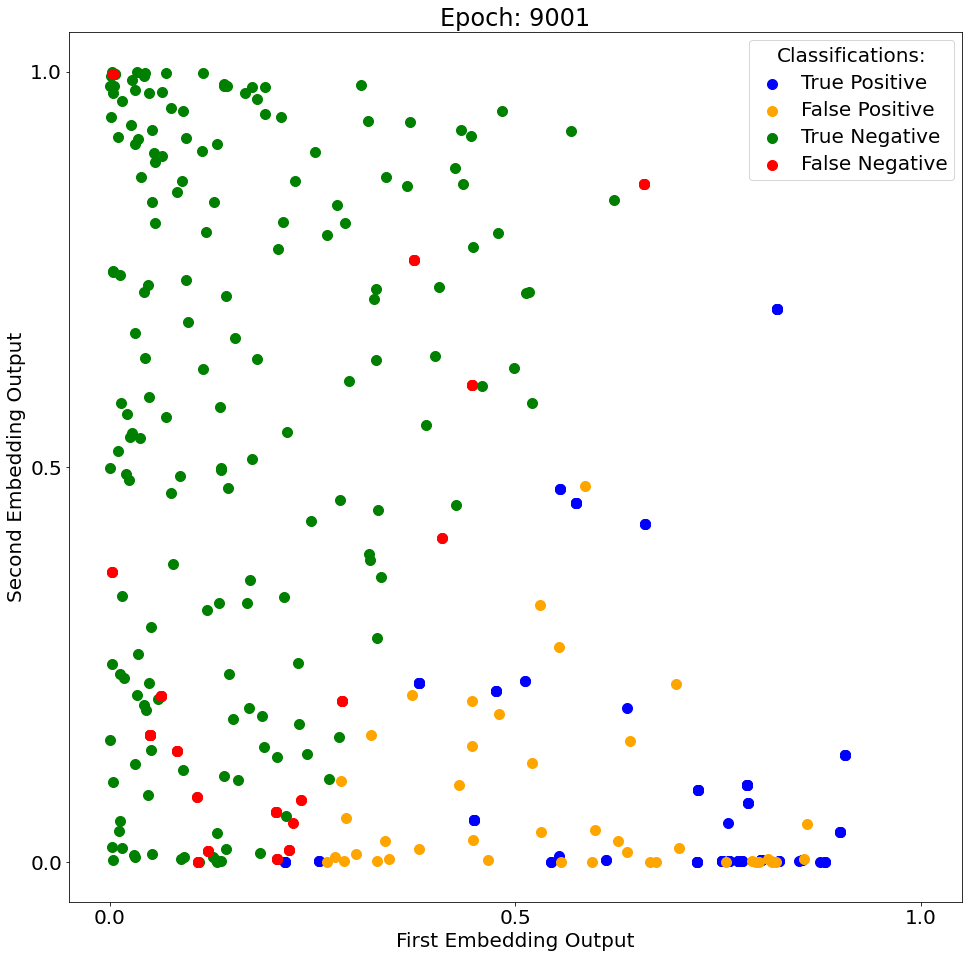

Epoch: 9001  Accuracy: 0.718204  FP: 43  TP: 112  TPR: 0.615385  TNR: 0.803653


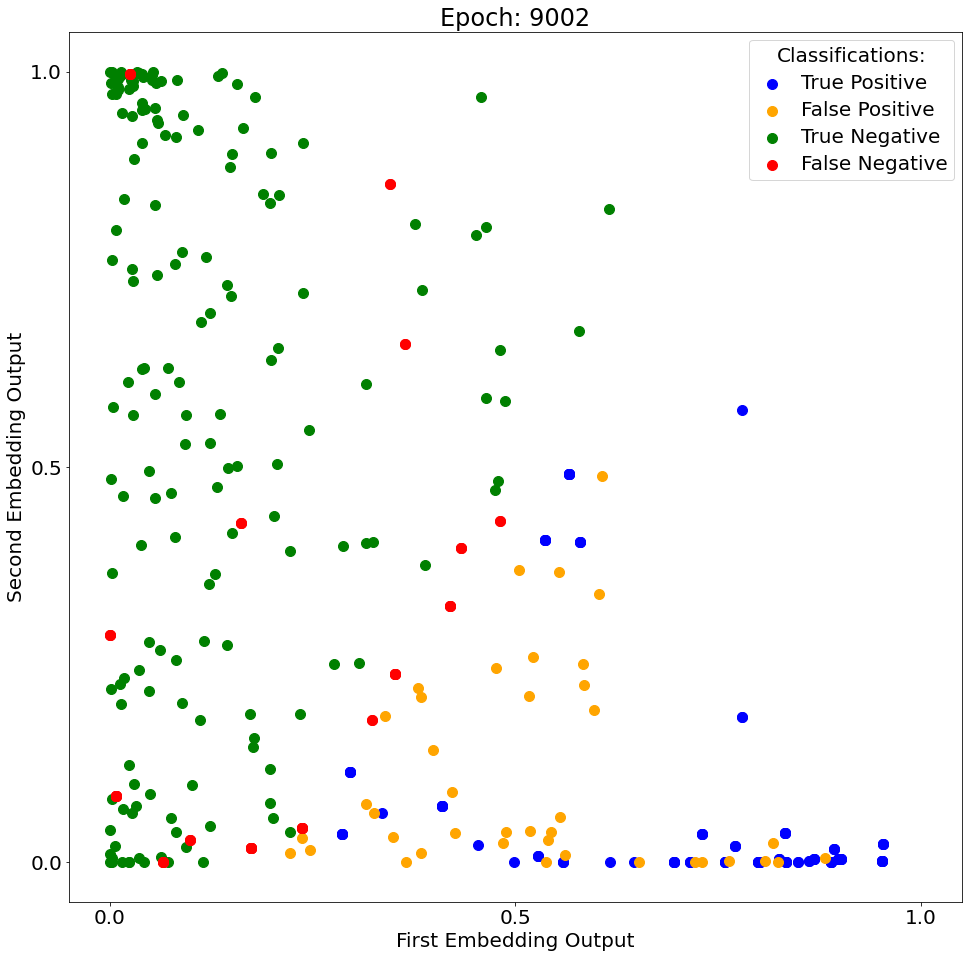

Epoch: 9002  Accuracy: 0.744792  FP: 40  TP: 120  TPR: 0.674157  TNR: 0.805825


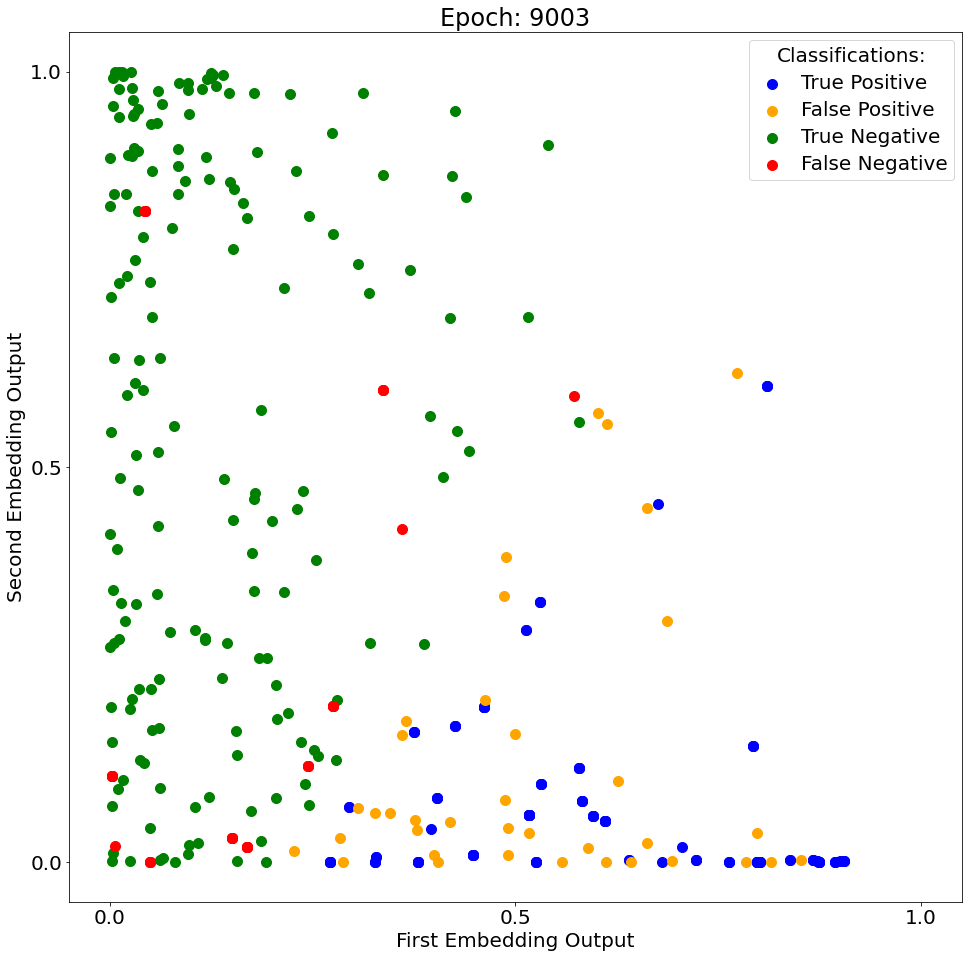

Epoch: 9003  Accuracy: 0.796345  FP: 37  TP: 132  TPR: 0.763006  TNR: 0.823810


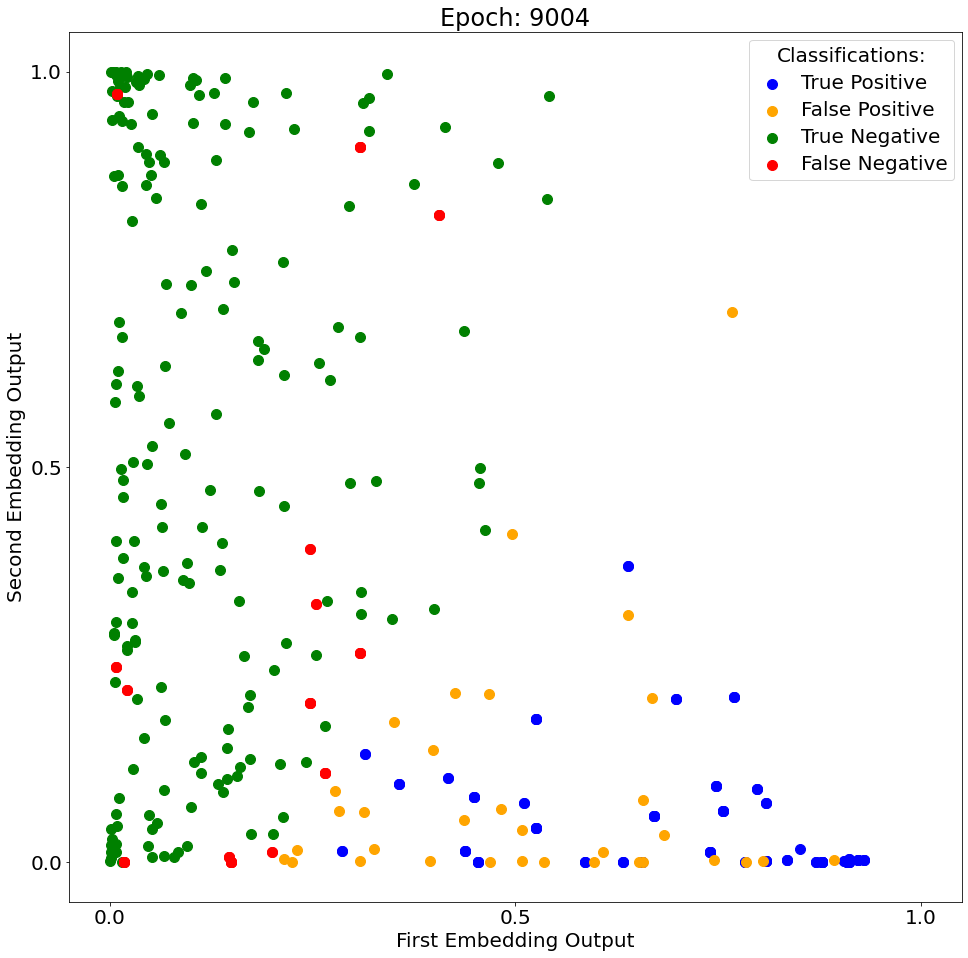

Epoch: 9004  Accuracy: 0.793017  FP: 33  TP: 132  TPR: 0.725275  TNR: 0.849315


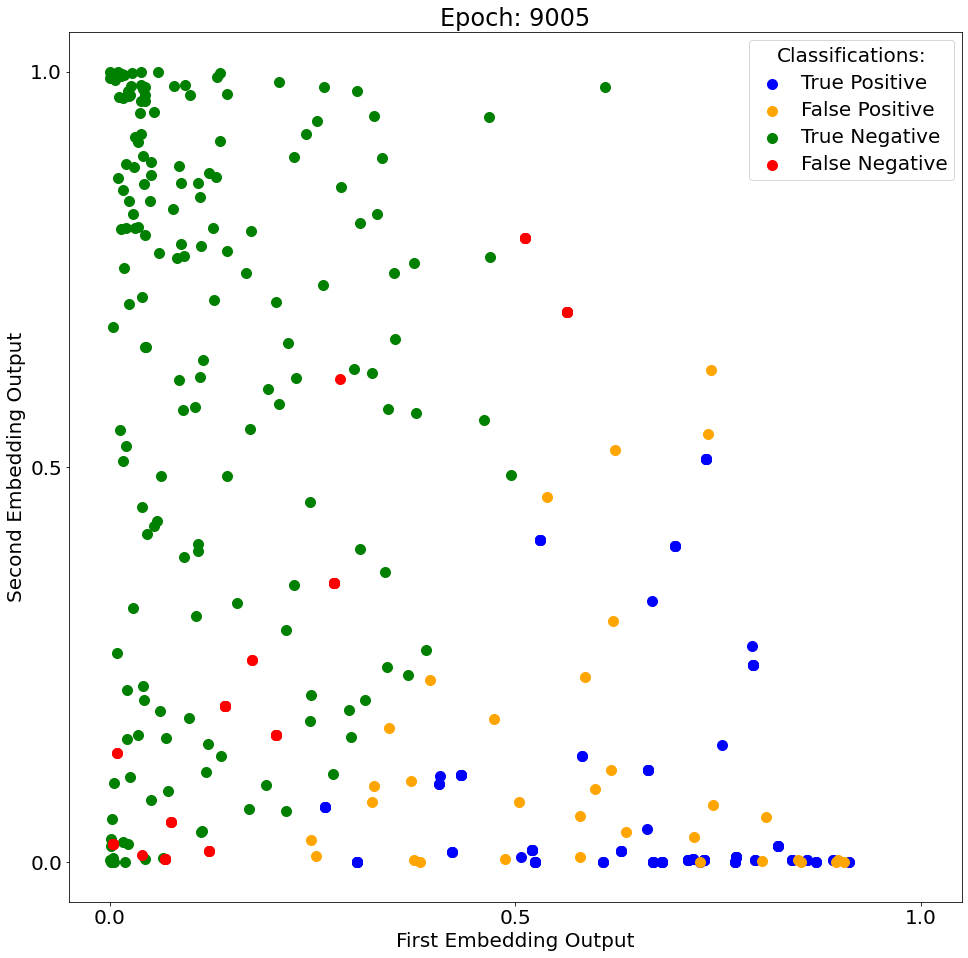

Epoch: 9005  Accuracy: 0.782051  FP: 33  TP: 131  TPR: 0.715847  TNR: 0.840580


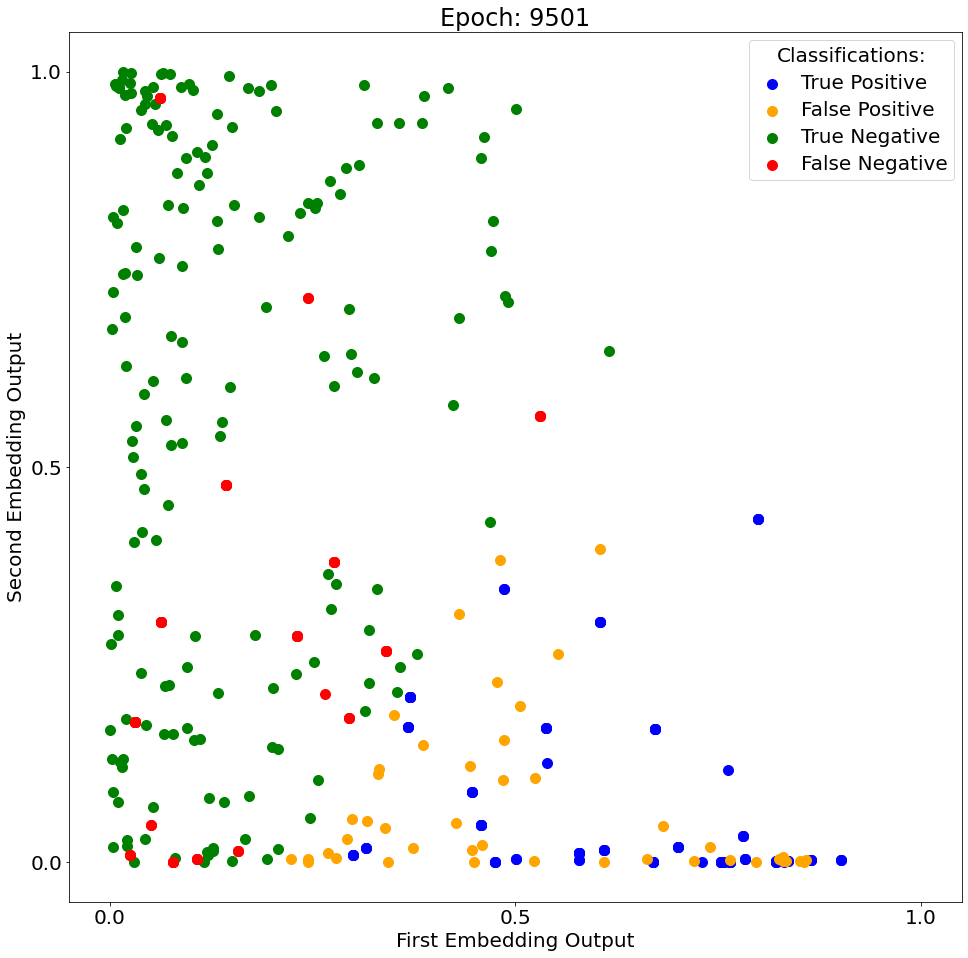

Epoch: 9501  Accuracy: 0.725686  FP: 44  TP: 116  TPR: 0.637363  TNR: 0.799087


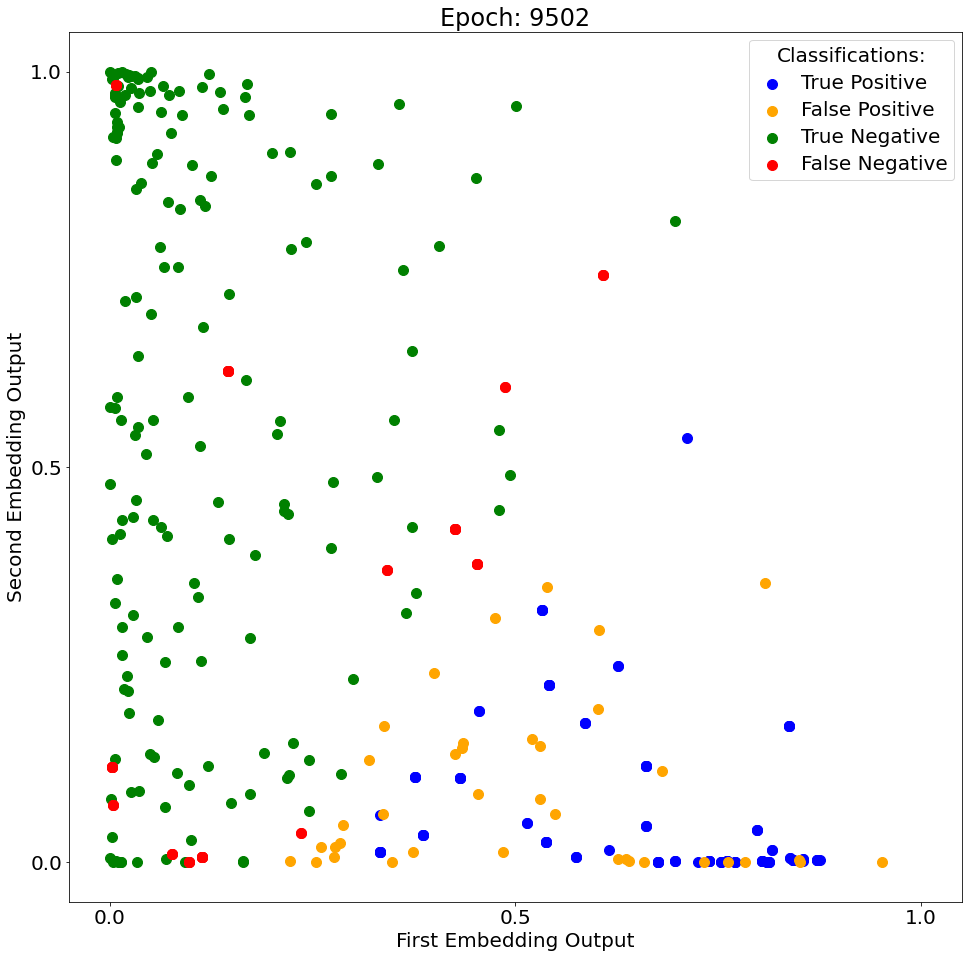

Epoch: 9502  Accuracy: 0.752604  FP: 38  TP: 121  TPR: 0.679775  TNR: 0.815534


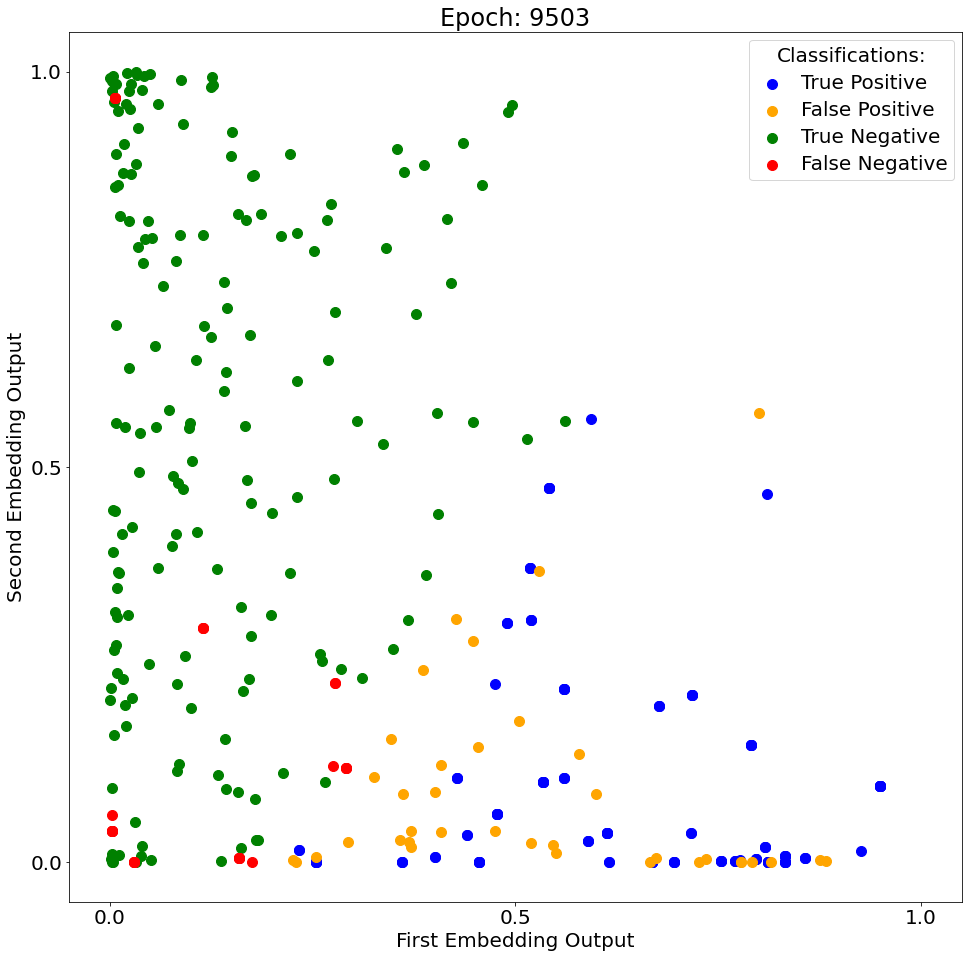

Epoch: 9503  Accuracy: 0.819843  FP: 37  TP: 141  TPR: 0.815029  TNR: 0.823810


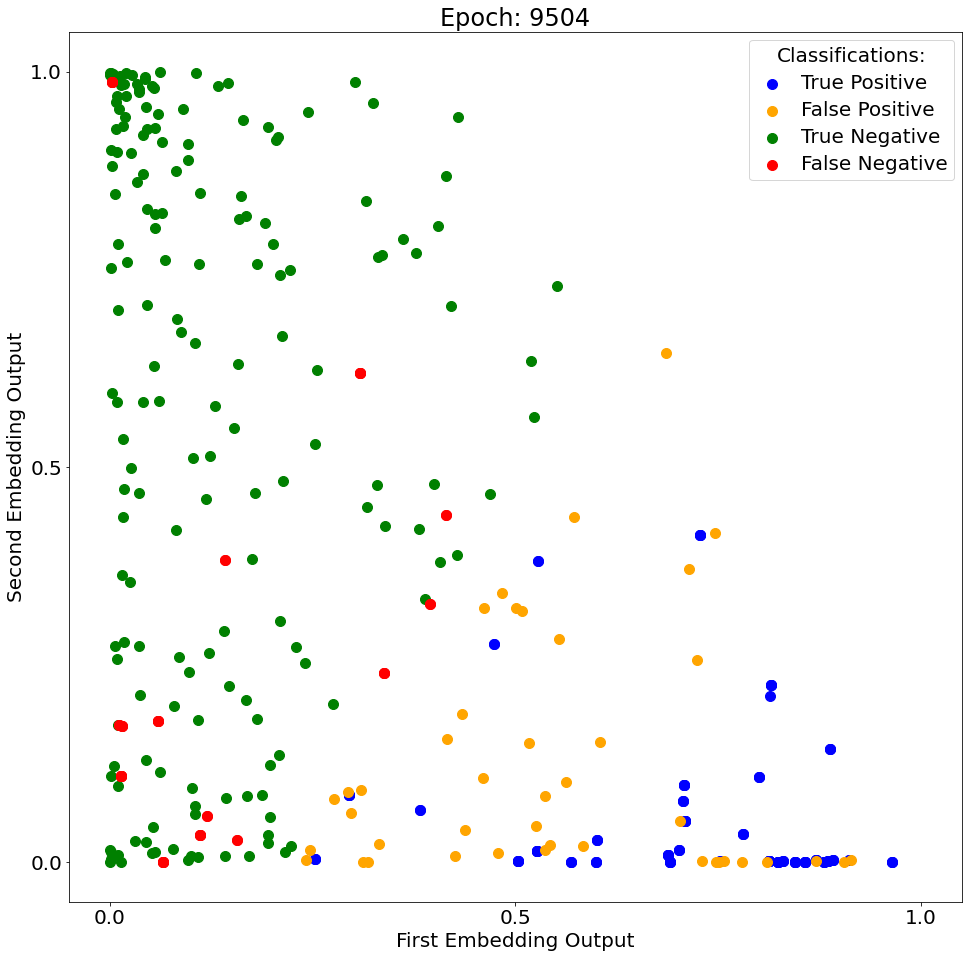

Epoch: 9504  Accuracy: 0.775561  FP: 43  TP: 135  TPR: 0.741758  TNR: 0.803653


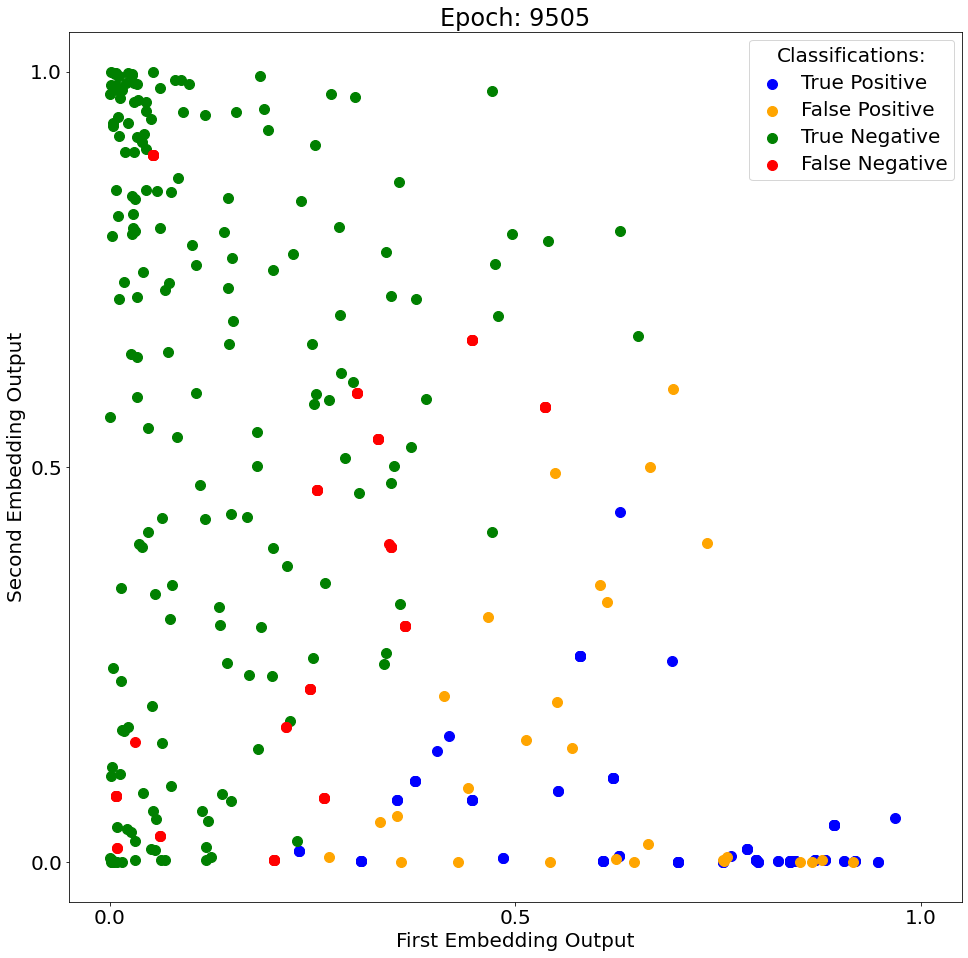

Epoch: 9505  Accuracy: 0.743590  FP: 28  TP: 111  TPR: 0.606557  TNR: 0.864734


In [13]:
count=0

#loops for all nodes
for j in range(0,int(len(embeddings)/5)):
    for train_index, test_index in sss.split(X_train,Y_train):
        #creates new test index and colour list
        test_index = X_train.iloc[test_index]
        colours=[]
        #loops for each nodes label 
        for i in range(0,len(Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]])):
            temp = Dataset[0].y[torch.tensor(list(test_index))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(test_index)))]][i]
            
            #checks if true/false positive/negative and labels colour appropriately
            try:
                if temp[outs[count][i]==1]==1:
                    colours.append(0)
            except:
                pass
            try:
                if temp[outs[count][i]==1]==0:
                    colours.append(1)
            except:
                pass
            try:
                if temp[outs[count][i]==0]==0:
                    colours.append(2)
            except:
                pass
            try:
                if temp[outs[count][i]==0]==1:
                    colours.append(3)
            except:
                pass
        
    
        #checks colours list is correct length
        if len(colours)==len(embeddings[count]):
            #plots using function
            plot_embedding(count,embeddings[count],torch.Tensor(colours),['True Positive','False Positive','True Negative','False Negative'])
            print(f"Epoch: {counts[count]}",
                f" Accuracy: {accs[count]:2f}",
                f" FP: {fps[count]}",
                f" TP: {tps[count]}",
                f" TPR: {tprs[count]:2f}",
                f" TNR: {tnrs[count]:2f}")
        count+=1

Test Classification Results and Plots:

In [14]:
#repeats above for test data
colours=[]
#finds outputs
out, h = model(Dataset[0].x,Dataset[0].edge_index)   
out = (out[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]]).max(1)[1]
h = (h[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])
#loops for each nodes label 
for i in range(0,len(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])):
    temp = Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]][i]
    
    #checks if true/false positive/negative and labels colour appropriately
    try:
        if temp[outs[count][i]==1]==1:
            colours.append(0)
    except:
        pass
    try:
        if temp[outs[count][i]==1]==0:
            colours.append(1)
    except:
        pass
    try:
        if temp[outs[count][i]==0]==0:
            colours.append(2)
    except:
        pass
    try:
        if temp[outs[count][i]==0]==1:
            colours.append(3)
    except:
        pass

#checks colours list is correct length
if len(colours)==len(h):
    #plots using function
    plot_embedding('Test Dataset',h,torch.Tensor(colours),['True Positive','False Positive','True Negative','False Negative'])

#finds TP,FP,TN,FN and accuracy
tp = (out[(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])==1]).sum().item()
fp = (out[(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])==0]).sum().item()
tn = (out[(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])==0]==0).sum().item()
fn = (out[(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]])==1]==0).sum().item()
acc1 = out.eq(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]]).sum()
acc2 = Dataset[0]['mask'][torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]].sum()
acc =  acc1/acc2 

#determines TP/TN rates
if tp!=0 or fn!=0:
    tpr = tp/(tp+fn)
else:
    tpr = -0.0

if tn!=0 or fp!=0:
    tnr = tn/(tn+fp)
else:
    tnr = -0.0

#prints outputs    
print("Dataset Test: \n",
    f" Accuracy: {acc:2f}",
    f" FP: {fn}",
    f" TP: {tp}",
    f" TPR: {tpr:2f}",
    f" TNR: {tnr:2f}")

Dataset Test: 
  Accuracy: 0.841996  FP: 2  TP: 11  TPR: 0.846154  TNR: 0.841880


ROC Curve:

In [15]:
#linear regression model

#defines model
regr = linear_model.LinearRegression()

#defines data used
XTR = pd.DataFrame(Dataset[0].x[torch.tensor(list(X_train))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_train)))]].numpy())
YTR = pd.DataFrame(Dataset[0].y[torch.tensor(list(X_train))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_train)))]].numpy())
XTS = pd.DataFrame(Dataset[0].x[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]].numpy())
YTS = pd.DataFrame(Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]].numpy())

#trains model
regr.fit(XTR,YTR)

#tests model
pred = regr.predict(XTS)

ns_probs = [0 for _ in range(0,len(pred))]
test = YTS
pred = regr.predict(XTS)
PRED = torch.tensor(pred).max(1)[1]

Baseline: ROC AUC=0.500
GNN Model: ROC AUC=0.874
NN Model: ROC AUC=0.598
LR Model: ROC AUC=0.603


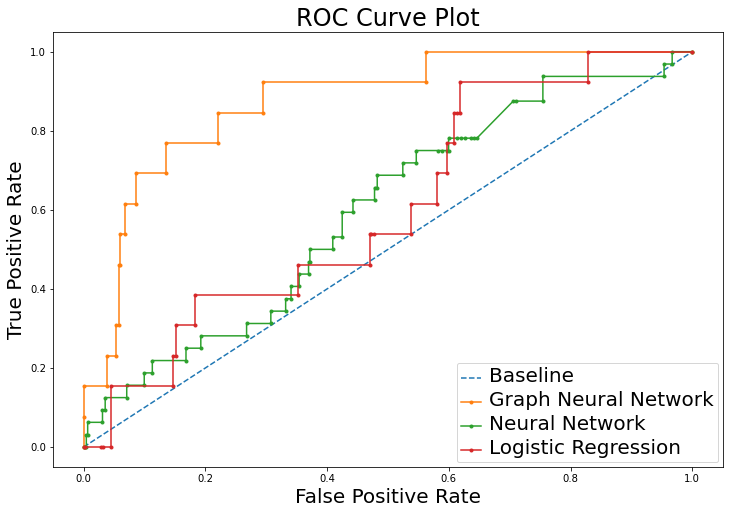

In [16]:
#gathers all output data
out, h = model(Dataset[0].x,Dataset[0].edge_index)
out = out[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]][:, 1]
nn_out = np.genfromtxt('NN_out.csv', delimiter=',')[1]
lr_out = pred

#gathers all labels
ns_probs = [0 for _ in range(0,len(torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]))]
test = Dataset[0].y[torch.tensor(list(X_test))[torch.index_select(Dataset[0]['mask'], 0, torch.tensor(list(X_test)))]]
nn_test = np.genfromtxt('NN_out.csv', delimiter=',')[0]
lr_test = test

#finds ROC AUC scores
ns_auc = roc_auc_score(test, ns_probs)
out_auc = roc_auc_score(test, out.detach().numpy())
nn_auc = roc_auc_score(nn_test, nn_out)
lr_auc = roc_auc_score(lr_test, lr_out)

# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc))
print('GNN Model: ROC AUC=%.3f' % (out_auc))
print('NN Model: ROC AUC=%.3f' % (nn_auc))
print('LR Model: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test, ns_probs)
out_fpr, out_tpr, _ = roc_curve(test, out.detach().numpy())
nn_fpr, nn_tpr, _ = roc_curve(nn_test, nn_out)
lr_fpr, lr_tpr, _ = roc_curve(lr_test, lr_out)

# plot the roc curve for the model
plt.figure(figsize=(12,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
plt.plot(out_fpr, out_tpr, marker='.', label='Graph Neural Network')
plt.plot(nn_fpr, nn_tpr, marker='.', label='Neural Network')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')

#labels plots
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve Plot', fontsize=24)

# show the legend
legend = plt.legend()
plt.setp(legend.get_title(),fontsize=20)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='20')

# show the plot
plt.show()

In [17]:
#print(nn_out)